In [1]:
import numpy as np
import pandas
import pm4py
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture
import scipy.stats as stats
import ot
import os
from tqdm import tqdm
import collections

import sys
sys.path.append('../../TaskExecutionTimeMining/')
from drbart_parser import *
from event_log_transformer import *

In [2]:
file_path = '../../../data/BPI Challenge 2017.xes'
event_log = pm4py.read_xes(file_path)

/home/michelkunkler/.local/share/virtualenvs/TaskExecutionTimeMining--mAzMuWa/lib/python3.10/site-packages/pm4py/util/dt_parsing/parser.py:77: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/31509 [00:00<?, ?it/s]

In [3]:
event_log = TransformEventLog.seconds_in_day(event_log)

In [45]:
drbart_schedule_start = DRBART(parser_dir = '../../../models/bpic_2017_schedule_start/concept-name_resource_seconds-in-day_activity-count_resource_count/')
drbart_start_suspend = DRBART(parser_dir = '../../../models/bpic_2017_start_suspend/concept-name_resource_seconds-in-day_activity-count_resource_count/')
drbart_suspend_resume = DRBART(parser_dir = '../../../models/bpic_2017_suspend_resume/concept-name_resource_seconds-in-day_activity-count_resource_count/')

def sample_schedule_start_time(seconds_in_day, resource, concept_name, resource_count, activity_count):
    known_resources = ['User_10','User_100','User_101','User_102','User_103','User_104','User_105','User_106','User_107','User_108','User_109','User_11','User_110','User_111','User_112','User_113','User_114','User_115','User_116','User_117','User_118','User_119','User_12','User_120','User_121','User_122','User_123','User_124','User_125','User_126','User_127','User_129','User_13','User_130','User_131','User_132','User_133','User_134','User_135','User_136','User_137','User_138','User_14','User_140','User_141','User_142','User_143','User_144','User_15','User_16','User_17','User_18','User_19','User_2','User_20','User_21','User_22','User_23','User_24','User_25','User_26','User_27','User_28','User_29','User_3','User_30','User_31','User_32','User_33','User_34','User_35','User_36','User_37','User_38','User_39','User_4','User_40','User_41','User_42','User_43','User_44','User_45','User_46','User_47','User_48','User_49','User_5','User_50','User_51','User_52','User_53','User_54','User_55','User_56','User_57','User_58','User_59','User_6','User_60','User_61','User_62','User_63','User_64','User_65','User_66','User_67','User_68','User_69','User_7','User_70','User_71','User_72','User_73','User_74','User_75','User_76','User_77','User_78','User_79','User_8','User_80','User_81','User_82','User_83','User_84','User_85','User_86','User_87','User_88','User_89','User_9','User_90','User_91','User_92','User_93','User_94','User_95','User_96','User_97','User_98','User_99']
    known_activities = ['W_Assess potential fraud','W_Call after offers','W_Call incomplete files','W_Complete application','W_Handle leads','W_Validate application']

    duration_ms_log = drbart_schedule_start.sample([resource,
                                         concept_name,
                                         *[0 if resource not in resource_count else resource_count[resource] for resource in known_resources],
                                         *[0 if activity not in activity_count else activity_count[activity] for activity in known_activities]
                                        ],
                                        [seconds_in_day])[1][0]
    return np.exp(duration_ms_log - np.log(1000))

def sample_start_complete_time(seconds_in_day, resource, concept_name, resource_count, activity_count):
    known_resources = ["User_10","User_100","User_101","User_102","User_103","User_104","User_105","User_106","User_107","User_108","User_109","User_11","User_110","User_111","User_112","User_113","User_114","User_115","User_116","User_117","User_118","User_119","User_12","User_120","User_121","User_122","User_123","User_124","User_125","User_126","User_127","User_129","User_13","User_130","User_131","User_132","User_133","User_134","User_135","User_136","User_137","User_138","User_14","User_140","User_141","User_142","User_143","User_144","User_15","User_16","User_17","User_18","User_19","User_2","User_20","User_21","User_22","User_23","User_24","User_25","User_26","User_27","User_28","User_29","User_3","User_30","User_31","User_32","User_33","User_34","User_35","User_36","User_37","User_38","User_39","User_4","User_40","User_41","User_42","User_43","User_44","User_45","User_46","User_47","User_48","User_49","User_5","User_50","User_51","User_52","User_53","User_54","User_55","User_56","User_57","User_58","User_59","User_6","User_60","User_61","User_62","User_63","User_64","User_65","User_66","User_67","User_68","User_69","User_7","User_70","User_71","User_72","User_73","User_74","User_75","User_76","User_77","User_78","User_79","User_8","User_80","User_81","User_82","User_83","User_84","User_85","User_86","User_87","User_88","User_89","User_9","User_90","User_91","User_92","User_93","User_94","User_95","User_96","User_97","User_98","User_99"]
    known_activities = ['W_Assess potential fraud','W_Call after offers','W_Call incomplete files','W_Complete application','W_Handle leads','W_Validate application']

    sampled_time =  drbart_start_suspend.sample([resource,
                                         concept_name,
                                         *[0 if resource not in resource_count else resource_count[resource] for resource in known_resources],
                                         *[0 if activity not in activity_count else activity_count[activity] for activity in known_activities]
                                        ],
                                        [seconds_in_day])[1][0]
    if sampled_time < 0:
        return sample_start_complete_time(seconds_in_day, resource, concept_name, resource_count, activity_count)
    else:
        return sampled_time

def sample_suspend_resume_time(seconds_in_day, resource, concept_name, resource_count, activity_count):
    known_resources = ["User_10","User_100","User_101","User_102","User_103","User_104","User_105","User_106","User_107","User_108","User_109","User_11","User_110","User_111","User_112","User_113","User_114","User_115","User_116","User_117","User_118","User_119","User_12","User_120","User_121","User_122","User_123","User_124","User_125","User_126","User_127","User_129","User_13","User_130","User_131","User_132","User_133","User_134","User_135","User_136","User_137","User_138","User_14","User_140","User_141","User_142","User_143","User_144","User_15","User_16","User_17","User_18","User_19","User_2","User_20","User_21","User_22","User_23","User_24","User_25","User_26","User_27","User_28","User_29","User_3","User_30","User_31","User_32","User_33","User_34","User_35","User_36","User_37","User_38","User_39","User_4","User_40","User_41","User_42","User_43","User_44","User_45","User_46","User_47","User_48","User_49","User_5","User_50","User_51","User_52","User_53","User_54","User_55","User_56","User_57","User_58","User_59","User_6","User_60","User_61","User_62","User_63","User_64","User_65","User_66","User_67","User_68","User_69","User_7","User_70","User_71","User_72","User_73","User_74","User_75","User_76","User_77","User_78","User_79","User_8","User_80","User_81","User_82","User_83","User_84","User_85","User_86","User_87","User_88","User_89","User_9","User_90","User_91","User_92","User_93","User_94","User_95","User_96","User_97","User_98","User_99"]
    known_activities = ['W_Assess potential fraud','W_Call after offers','W_Call incomplete files','W_Complete application','W_Handle leads','W_Validate application']
    sampled_time = drbart_suspend_resume.sample([resource,
                                     concept_name,
                                     *[0 if resource not in resource_count else resource_count[resource] for resource in known_resources],
                                     *[0 if activity not in activity_count else activity_count[activity] for activity in known_activities]
                                    ],
                                    [seconds_in_day])[1][0]
    if sampled_time < 0:
        return sample_suspend_resume_time(seconds_in_day, resource, concept_name, resource_count, activity_count)
    else:
        return sampled_time


In [7]:
sample_schedule_start_time(1000, 'User_109', 'W_Handle leads', {}, {})

0.13961956042640267

In [8]:
sample_start_complete_time(1000, 'User_109', 'W_Handle leads', {}, {})

58.91115174990457

In [9]:
sample_suspend_resume_time(1000, 'User_109', 'W_Handle leads', {}, {})

216213.53729502697

In [10]:
event_log

Action org:resource            concept:name  EventOrigin  \
0            Created       User_1    A_Create Application  Application   
1        statechange       User_1             A_Submitted  Application   
2            Created       User_1          W_Handle leads     Workflow   
3            Deleted       User_1          W_Handle leads     Workflow   
4            Created       User_1  W_Complete application     Workflow   
...              ...          ...                     ...          ...   
1202262      Deleted       User_1     W_Call after offers     Workflow   
1202263      Created       User_1     W_Call after offers     Workflow   
1202264  statechange      User_28             A_Cancelled  Application   
1202265  statechange      User_28             O_Cancelled        Offer   
1202266      Deleted      User_28     W_Call after offers     Workflow   

                       EventID lifecycle:transition  \
0        Application_652823628             complete   
1         ApplState_1582051990             complete   
2          Workitem_1298499574             schedule   
3          Workitem_1673366067             withdraw   
4          Workitem_1493664571             schedule   
...                        ...                  ...   
1202262    Workitem_1817549786            ate_abort   
1202263     Workitem_363876066             schedule   
1202264   ApplState_1869071797             complete   
1202265   OfferState_420066181             complete   
1202266    Workitem_1934044935             withdraw   

                          time:timestamp           case:LoanGoal  \
0       2016-01-01 09:51:15.304000+00:00  Existing loan takeover   
1       2016-01-01 09:51:15.352000+00:00  Existing loan takeover   
2       2016-01-01 09:51:15.774000+00:00  Existing loan takeover   
3       2016-01-01 09:52:36.392000+00:00  Existing loan takeover   
4       2016-01-01 09:52:36.403000+00:00  Existing loan takeover   
...                                  ...                     ...   
1202262 2017-01-06 06:33:02.212000+00:00        Home improvement   
1202263 2017-01-06 06:33:02.221000+00:00        Home improvement   
1202264 2017-01-16 09:51:21.114000+00:00        Home improvement   
1202265 2017-01-16 09:51:21.139000+00:00        Home improvement   
1202266 2017-01-16 09:51:21.146000+00:00        Home improvement   

        case:ApplicationType       case:concept:name  case:RequestedAmount  \
0                 New credit   Application_652823628               20000.0   
1                 New credit   Application_652823628               20000.0   
2                 New credit   Application_652823628               20000.0   
3                 New credit   Application_652823628               20000.0   
4                 New credit   Application_652823628               20000.0   
...                      ...                     ...                   ...   
1202262           New credit  Application_1350494635               20000.0   
1202263           New credit  Application_1350494635               20000.0   
1202264           New credit  Application_1350494635               20000.0   
1202265           New credit  Application_1350494635               20000.0   
1202266           New credit  Application_1350494635               20000.0   

         FirstWithdrawalAmount  NumberOfTerms Accepted  MonthlyCost Selected  \
0                          NaN            NaN      NaN          NaN      NaN   
1                          NaN            NaN      NaN          NaN      NaN   
2                          NaN            NaN      NaN          NaN      NaN   
3                          NaN            NaN      NaN          NaN      NaN   
4                          NaN            NaN      NaN          NaN      NaN   
...                        ...            ...      ...          ...      ...   
1202262                    NaN            NaN      NaN          NaN      NaN   
1202263                    NaN            NaN      NaN          NaN   

In [47]:
case_name = 'Application_652823628'
r = [sample_end_time(case_name)[1] for i in range(1000)]

In [48]:
nr = np.array(r)
print('mean', datetime.datetime.fromtimestamp(np.mean(nr)))
print('median', datetime.datetime.fromtimestamp(np.median(nr)))
#print('variance', datetime.datetime.fromtimestamp(np.var(nr)))
print('min', datetime.datetime.fromtimestamp(np.min(nr)))
print('max', datetime.datetime.fromtimestamp(np.max(nr)))
#print(nr)
print(datetime.datetime.fromtimestamp(sample_end_time(case_name)[0]))
print(datetime.datetime.fromtimestamp(sample_end_time(case_name)[2]))

mean 2016-01-23 19:13:23.713422
median 2016-01-19 01:06:31.850440
min 2016-01-04 22:20:52.032793
max 2016-06-18 17:38:20.006751
2016-01-01 10:51:15.774000
2016-01-14 16:49:11.423000


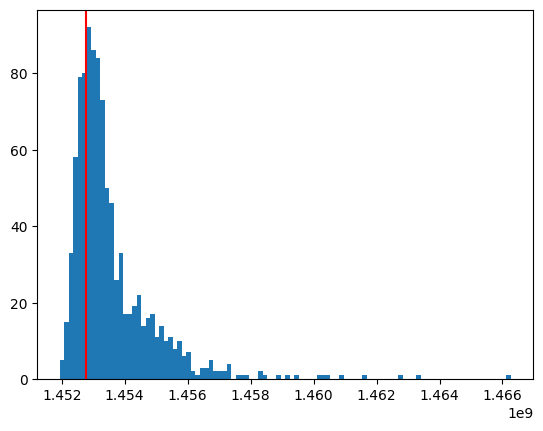

In [53]:
plt.hist(nr, bins=100)
plt.axvline(x=sample_end_time(case_name)[2], color='red')

Application_652823628 [4.97907175e-07]


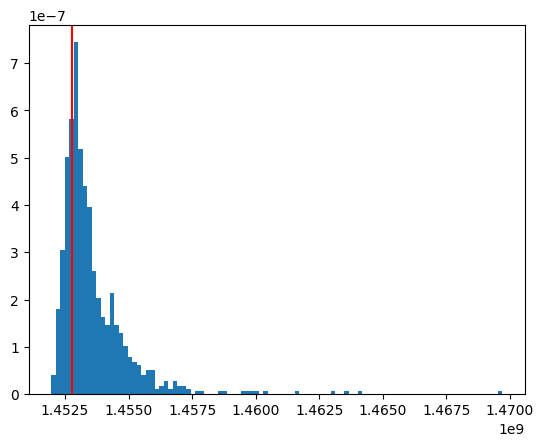

Application_1691306052 [3.48065187e-07]


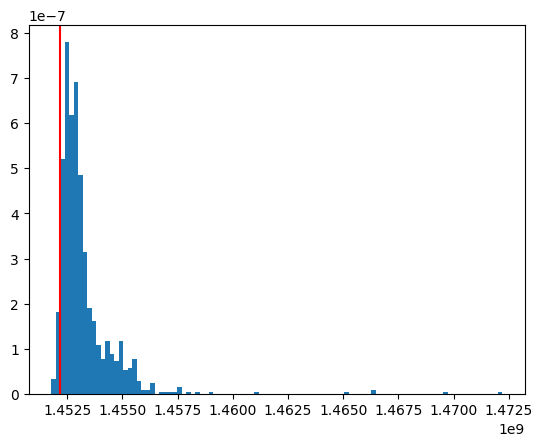

Application_428409768 [4.75779884e-07]


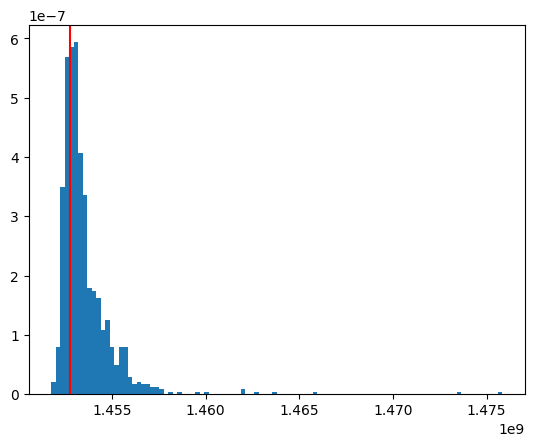

Application_1746793196 [1.5290938e-07]


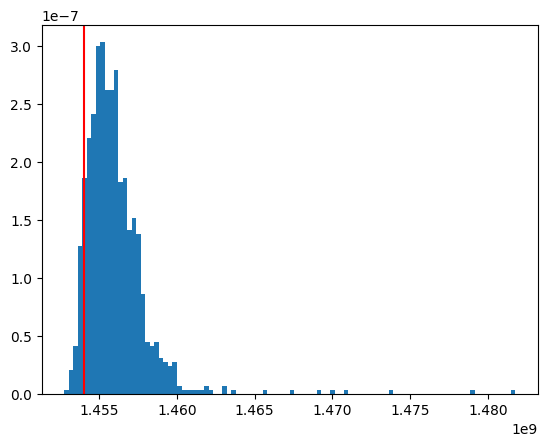

Application_828200680 [8.43727892e-08]


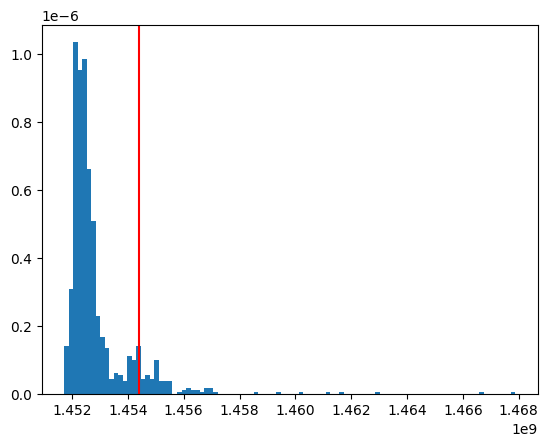

Application_1085880569 [9.98586656e-09]


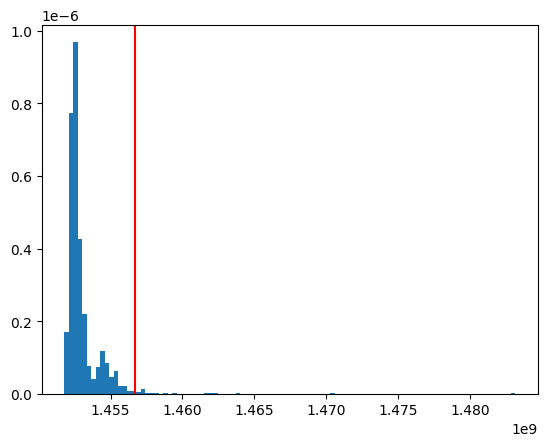

Application_1266995739 [7.17155255e-08]


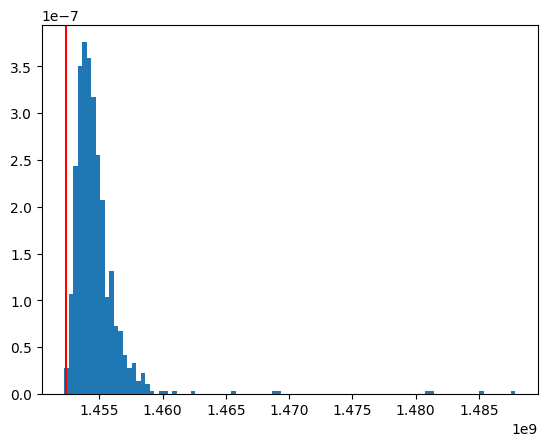

Application_1878239836 [5.59392308e-07]


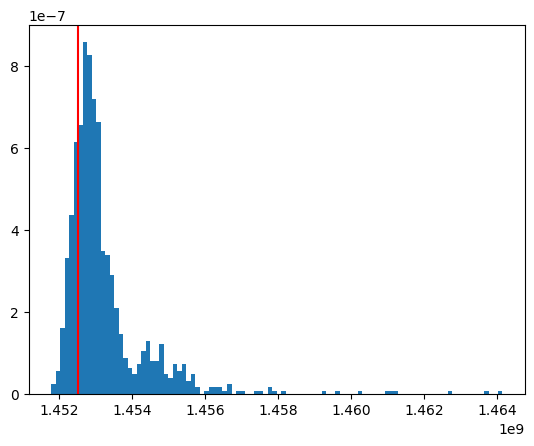

Application_619403287 [2.96759608e-07]


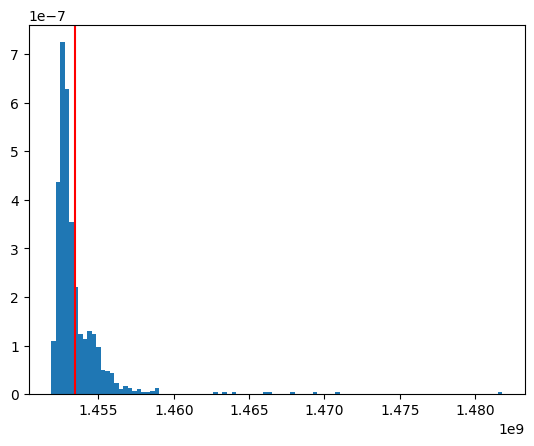

Application_1710223761 [9.41768849e-08]


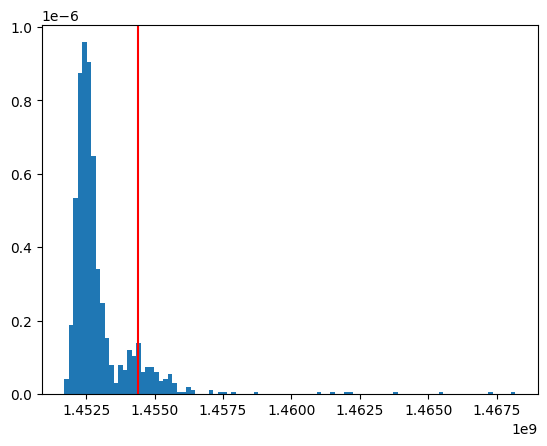

Application_1529124572 [2.49495822e-07]


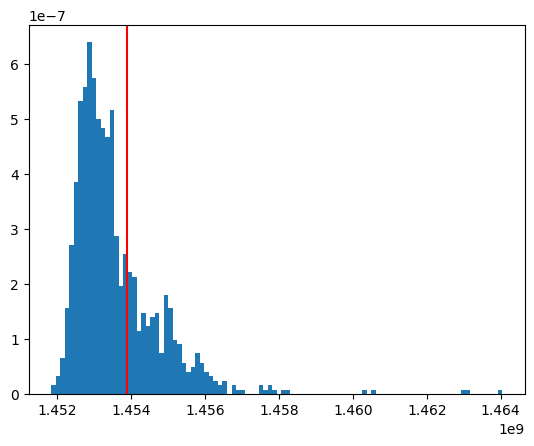

Application_387012864 [9.32238968e-08]


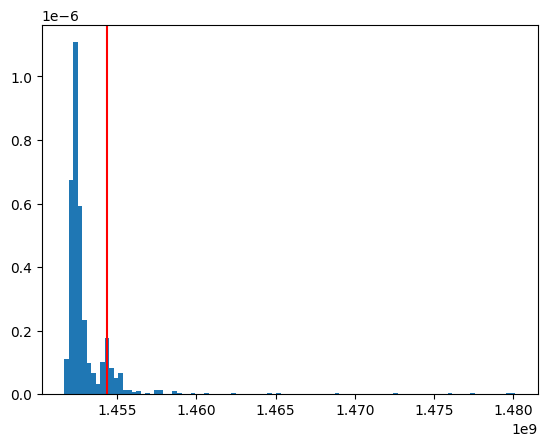

Application_1120819670 [3.92471796e-07]


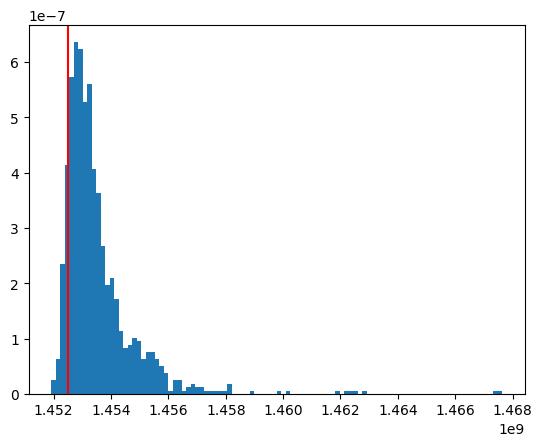

Application_42838382 [8.16305043e-09]


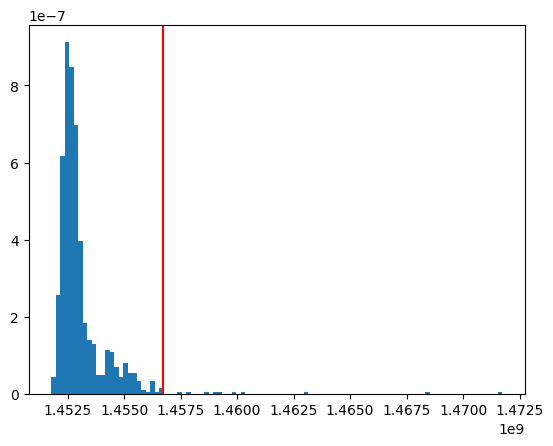

Application_180547487 [1.84819848e-07]


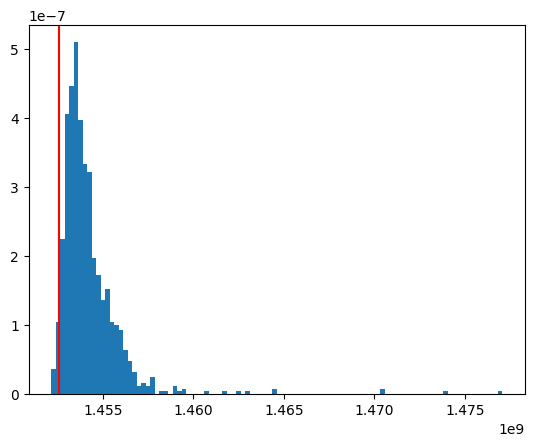

Application_1966208034 [8.02808972e-08]


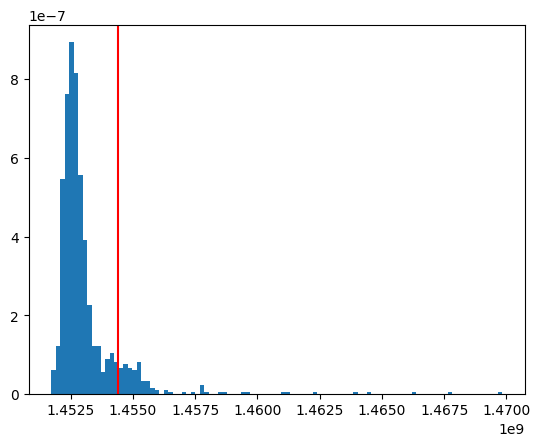

Application_1806387393 [4.0367438e-07]


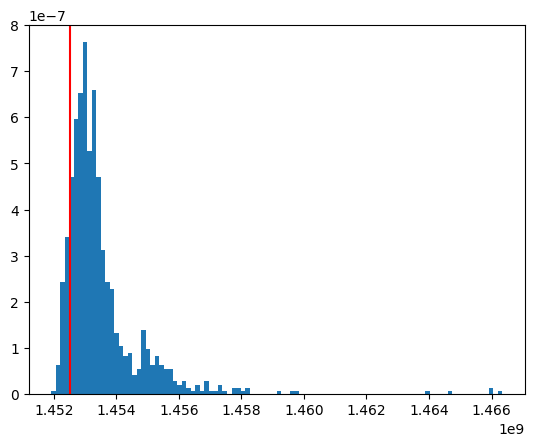

Application_1111870538 [5.24471992e-07]


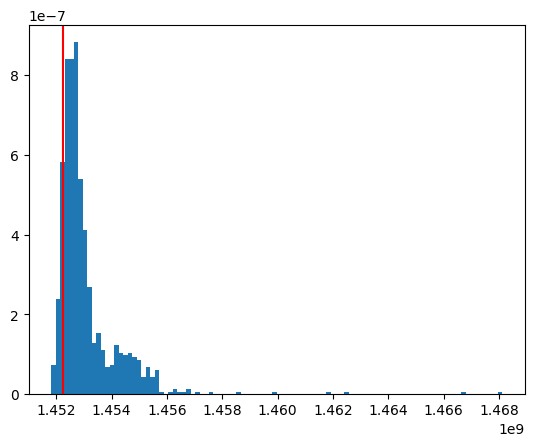

Application_1017492916 [8.11939971e-08]


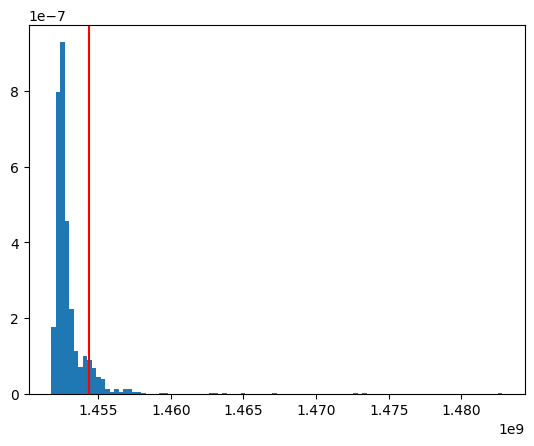

Application_2082119944 [6.18096176e-07]


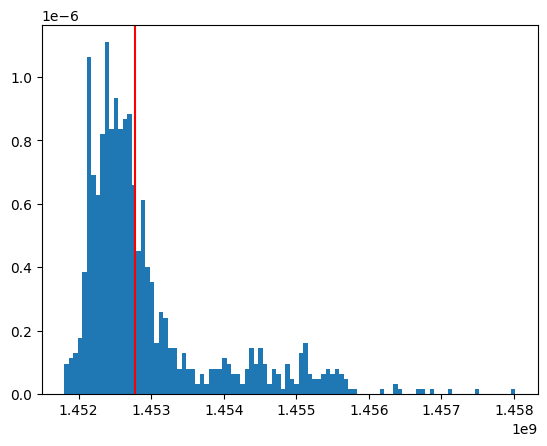

Application_758985626 [4.91265374e-08]


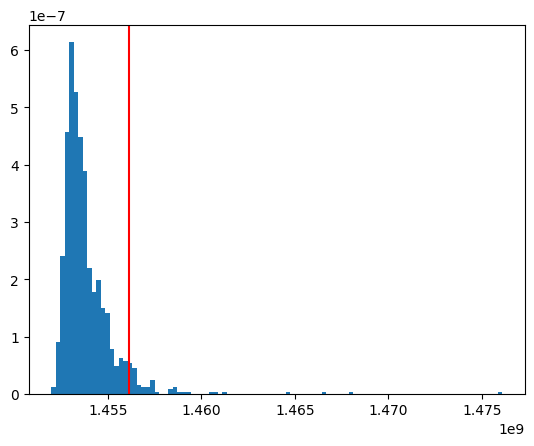

Application_1018615109 [3.00699037e-07]


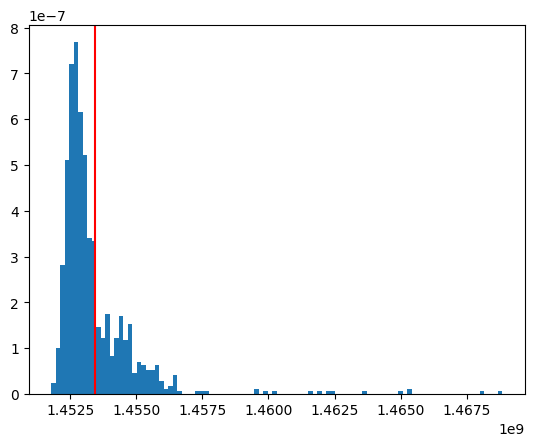

Application_319587802 [3.35503986e-07]


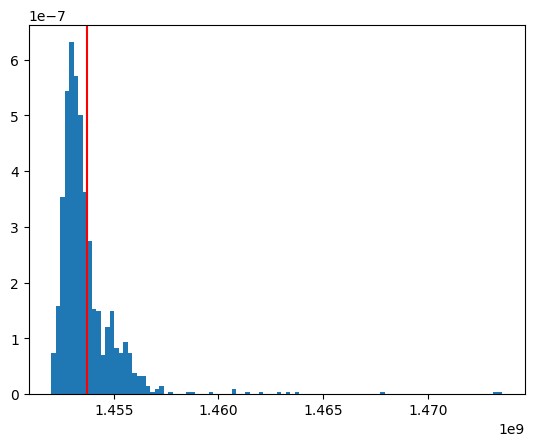

Application_1846626914 [4.34111768e-07]


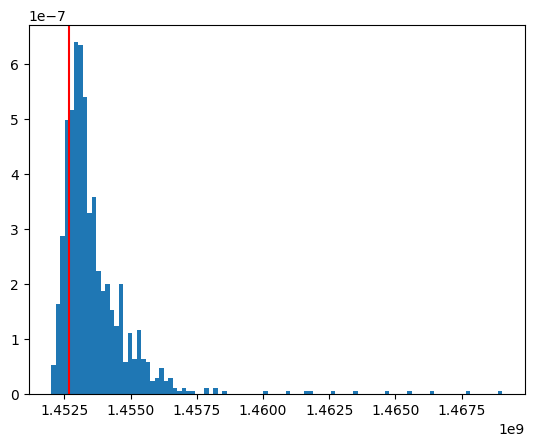

Application_546206358 [8.2993763e-07]


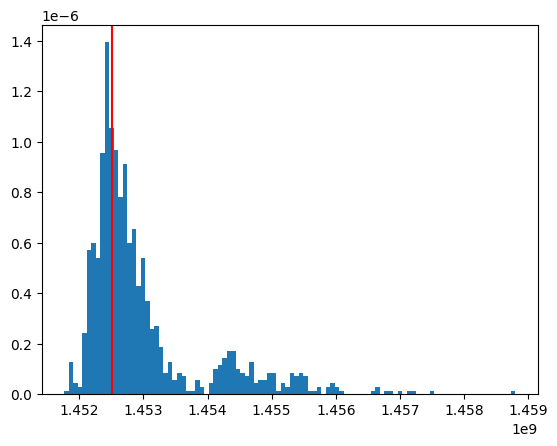

Application_196483749 [6.98191762e-09]


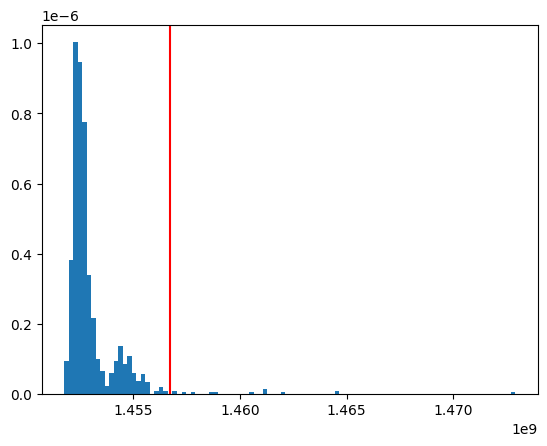

Application_1363980603 [1.17560077e-06]


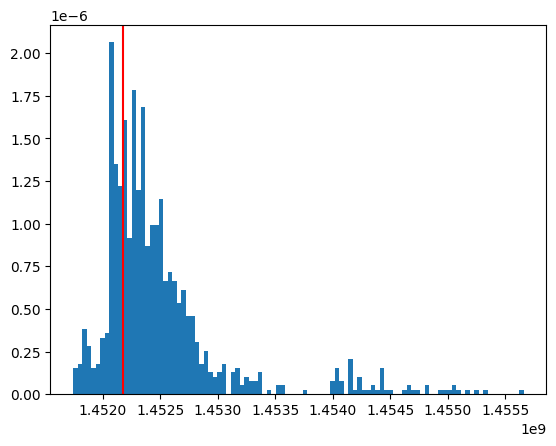

Application_1553362978 [3.081278e-09]


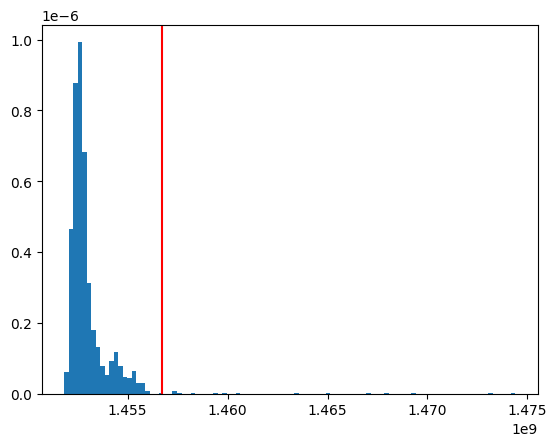

Application_1197857445 [1.98827202e-08]


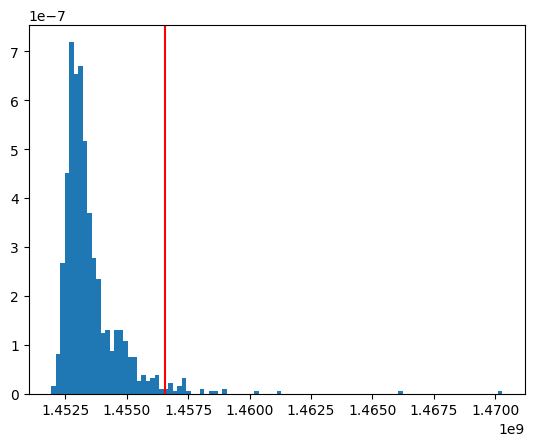

Application_931862671 [9.00981234e-08]


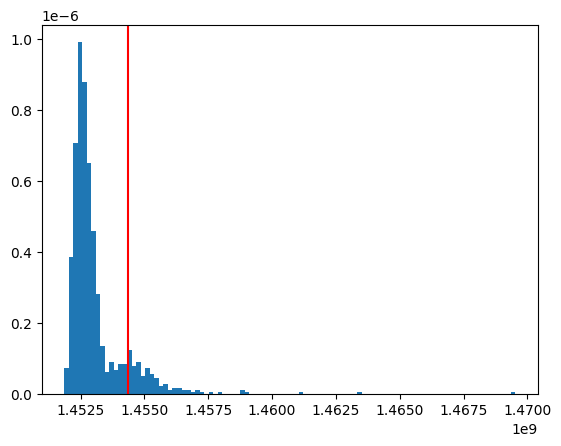

Application_2012588584 [3.51162084e-07]


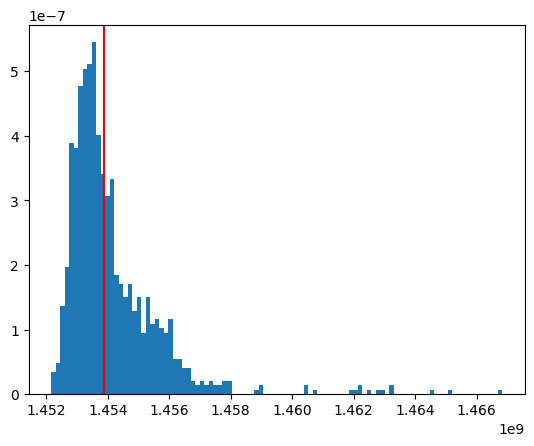

Application_1825972191 [1.30659117e-07]


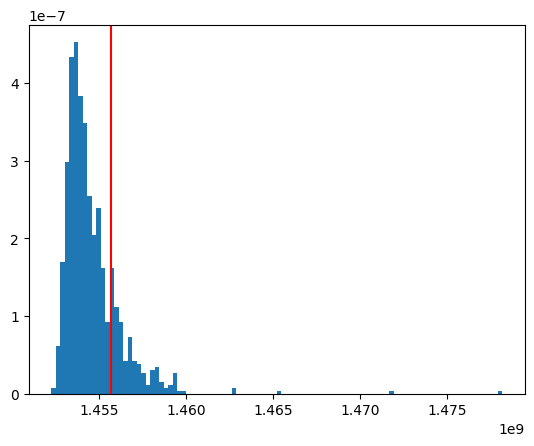

Application_1059184025 [3.56924186e-07]


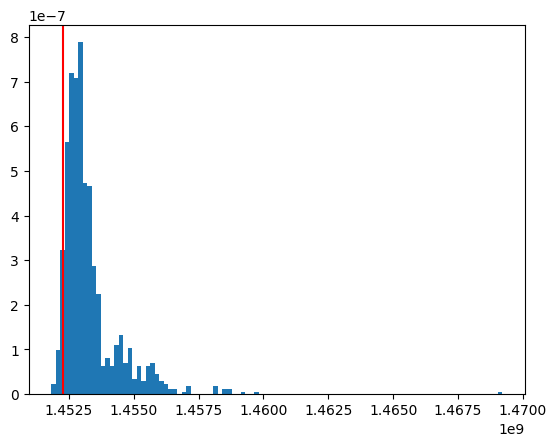

Application_1395142997 [2.97467439e-07]


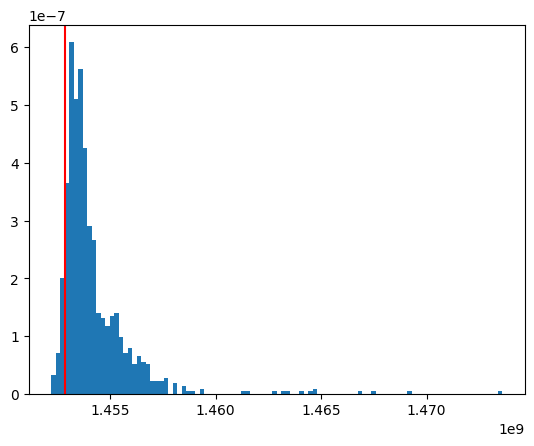

Application_2015287405 [1.2502633e-08]


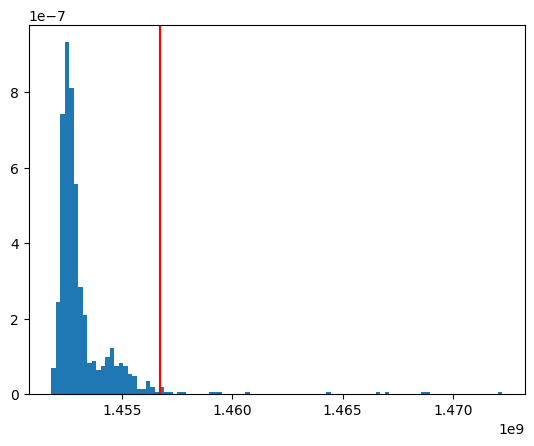

Application_1193723578 [4.1079847e-07]


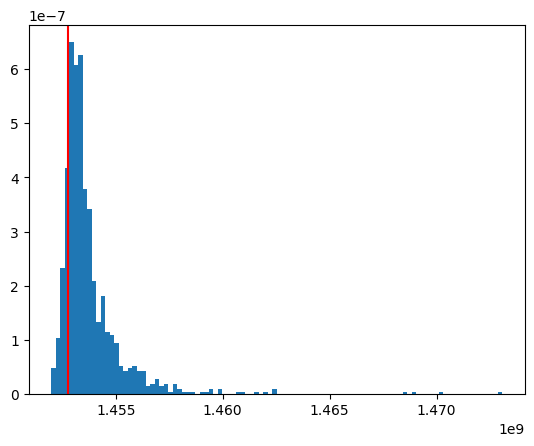

Application_2049529862 [2.85213057e-07]


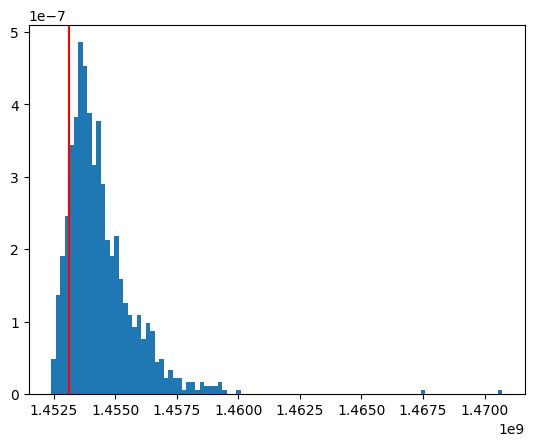

Application_1699757505 [2.6556597e-07]


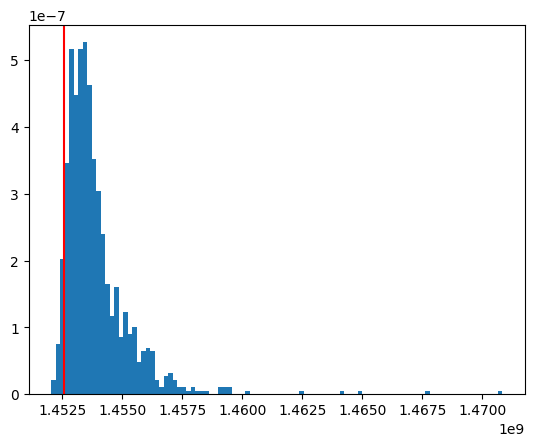

Application_493034835 [5.67791537e-07]


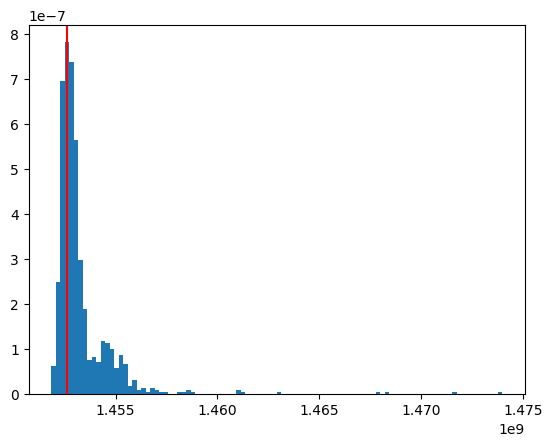

Application_842511489 [5.36296648e-07]


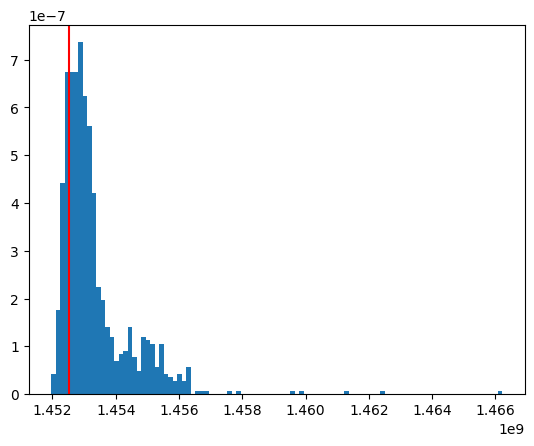

Application_1474017032 [2.31746603e-07]


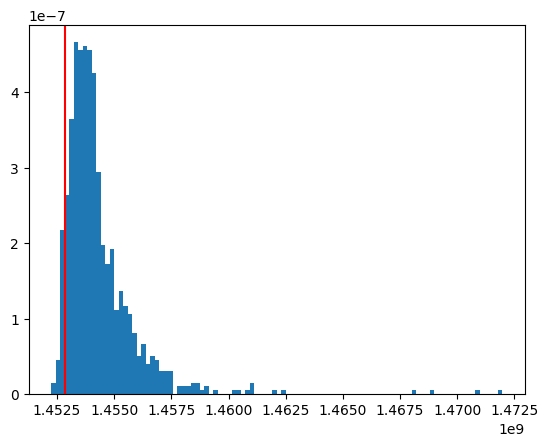

Application_1397856354 [9.01094314e-08]


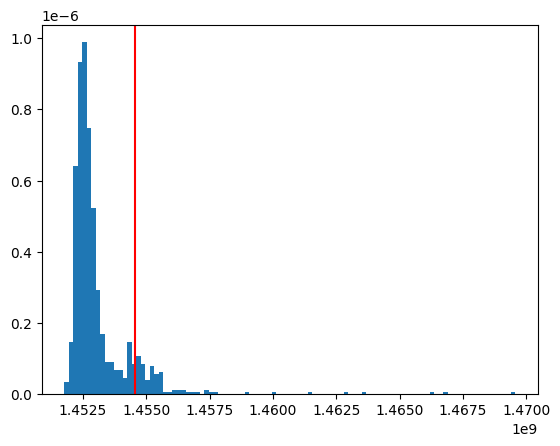

Application_767475240 [1.79351228e-07]


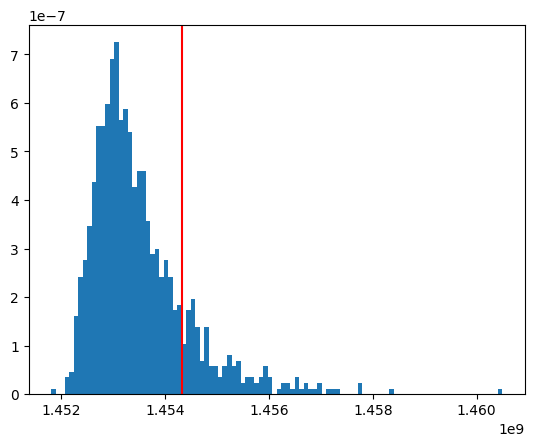

Application_980495316 [3.71624886e-07]


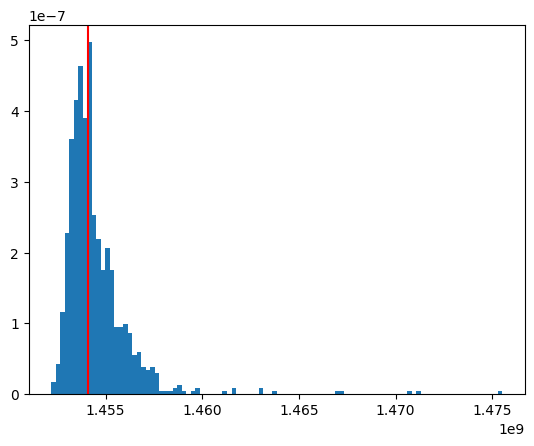

Application_2035768049 [5.67374574e-07]


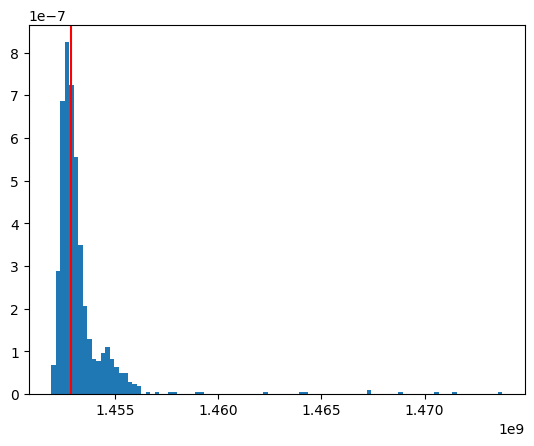

Application_1307111345 [3.98233143e-07]


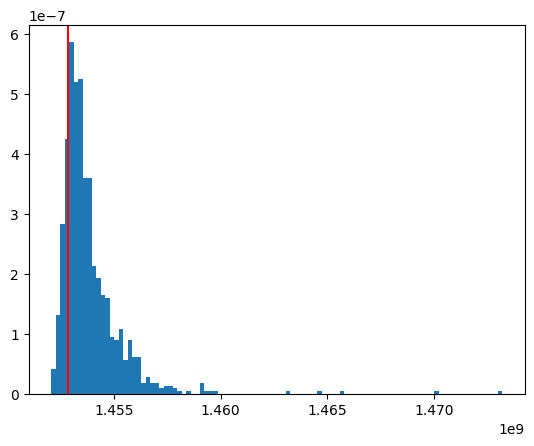

Application_821425679 [7.0320097e-07]


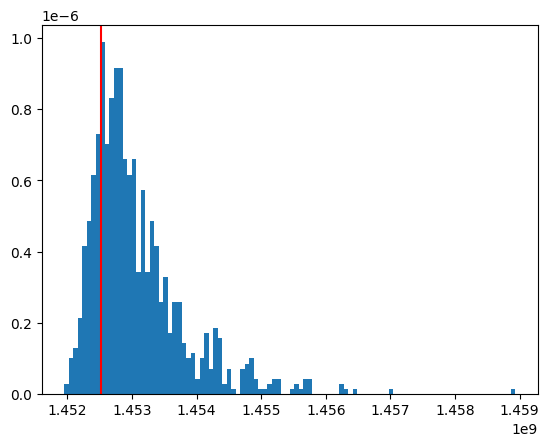

Application_1294530310 [3.31142087e-07]


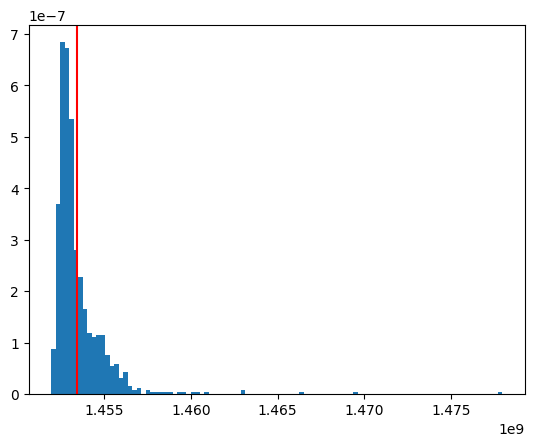

Application_470922426 [4.82778376e-07]


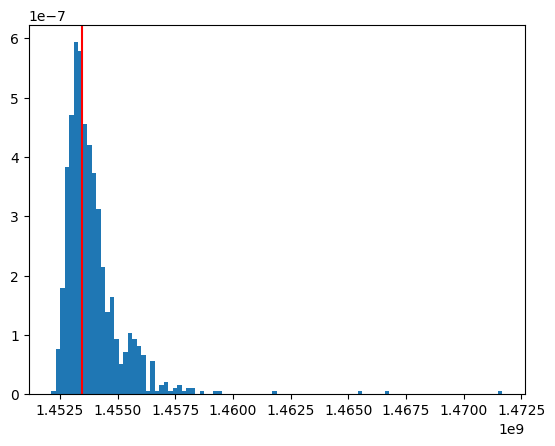

Application_1461440233 [7.15501731e-09]


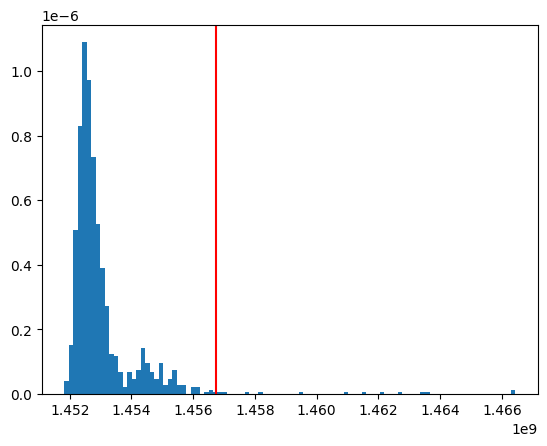

Application_857715587 [7.08650903e-08]


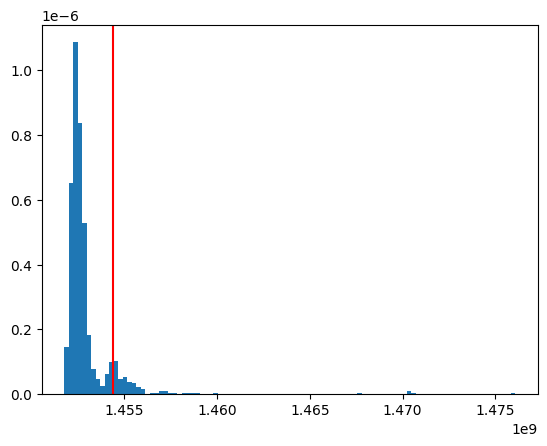

Application_351152063 [3.86164736e-07]


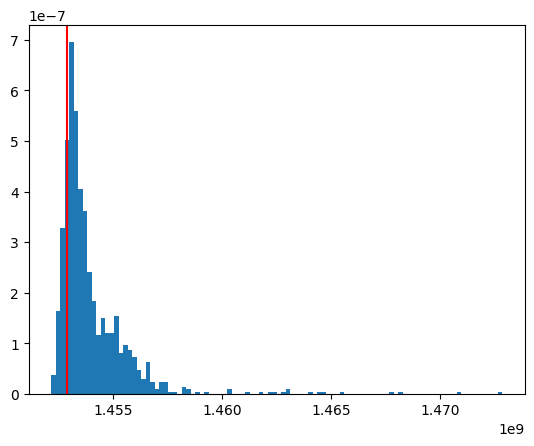

Application_1547844908 [2.50211964e-07]


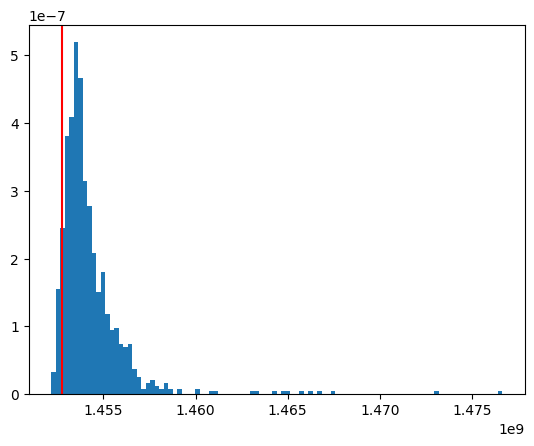

Application_2055987002 [6.96258893e-07]


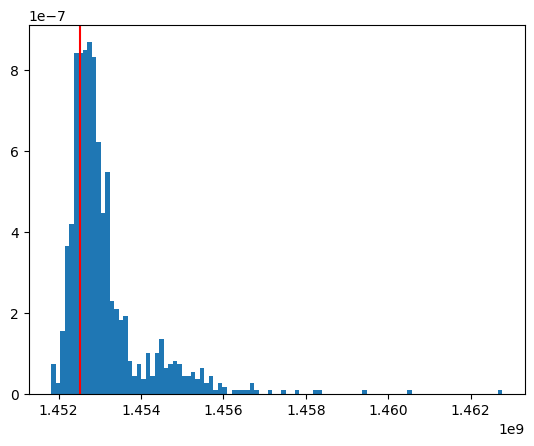

Application_1118236712 [7.75511084e-08]


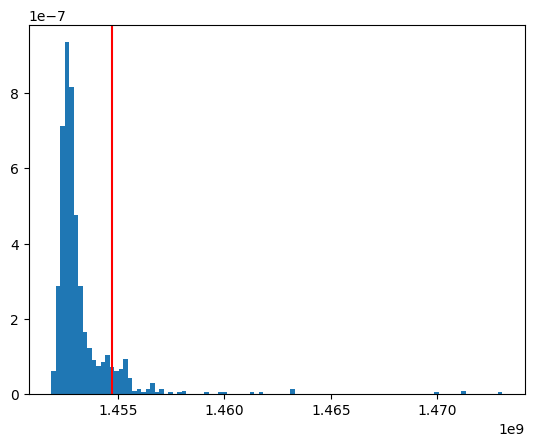

Application_1234535641 [8.37858394e-09]


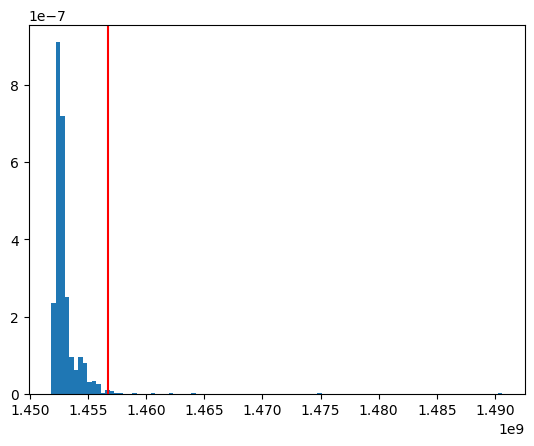

Application_1898882436 [1.02228465e-07]


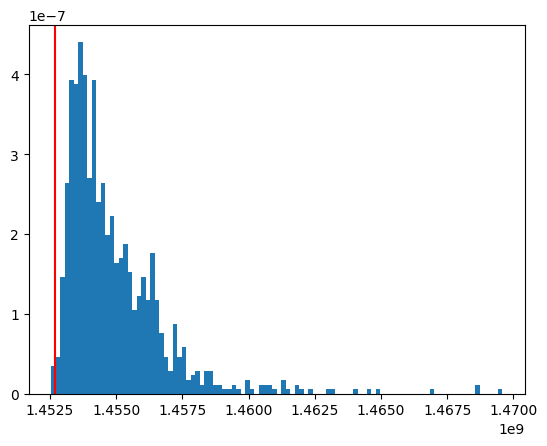

Application_2113276114 [2.5038606e-07]


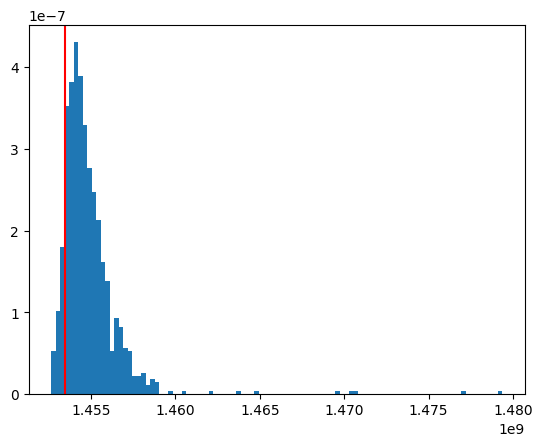

Application_1603124379 [2.41496722e-07]


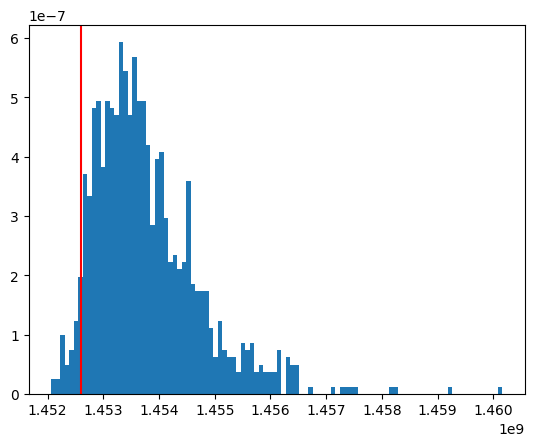

Application_2110144842 [9.67698425e-08]


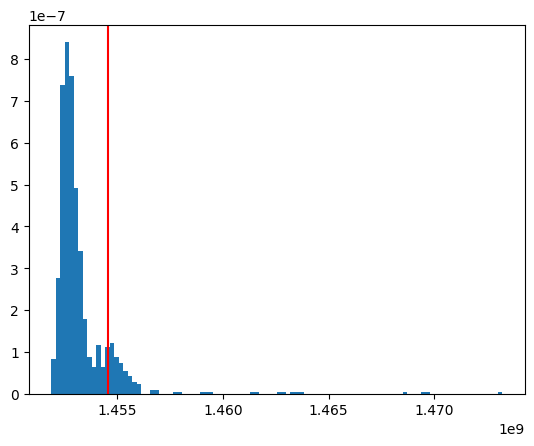

Application_486645986 [1.45869124e-07]


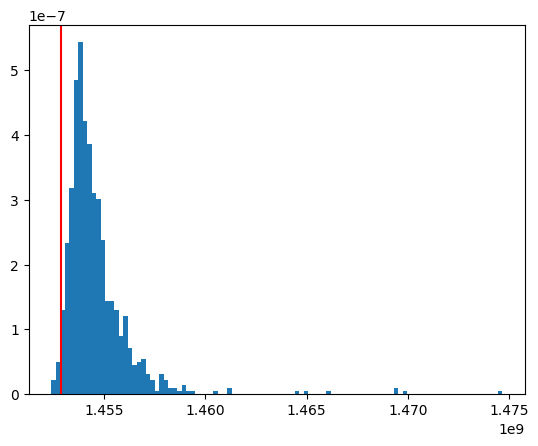

Application_587387633 [4.82306844e-07]


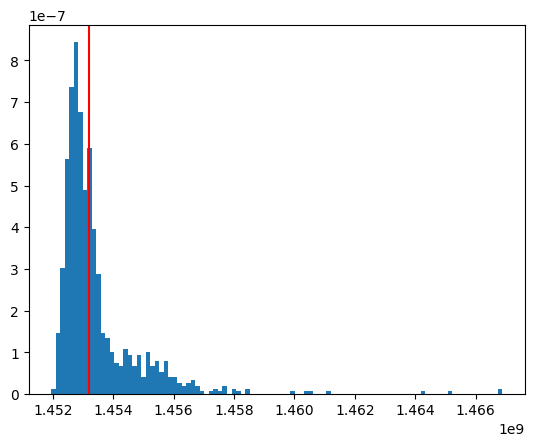

Application_901793095 [4.05072383e-07]


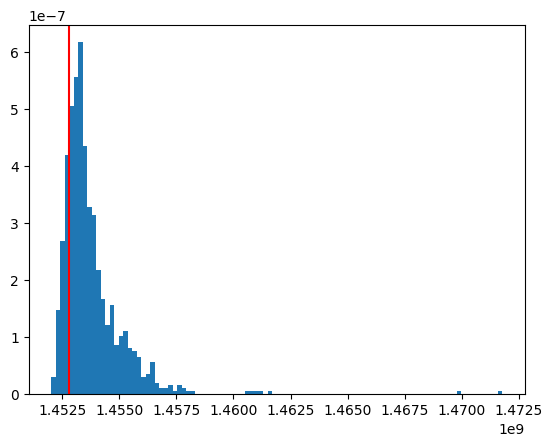

Application_340403559 [6.83321868e-09]


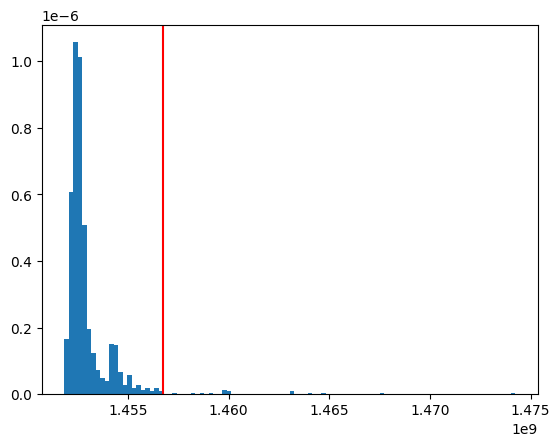

Application_1825104006 [8.74736442e-09]


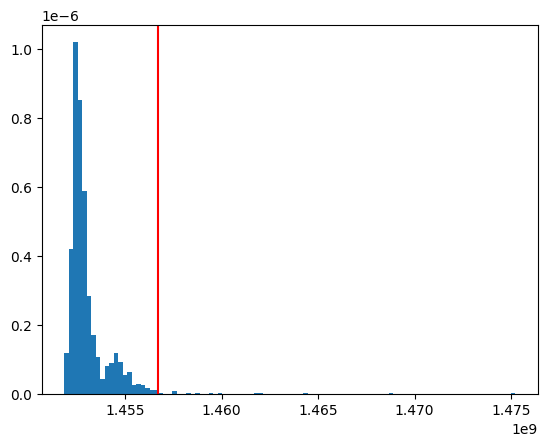

Application_1530322400 [9.55978852e-08]


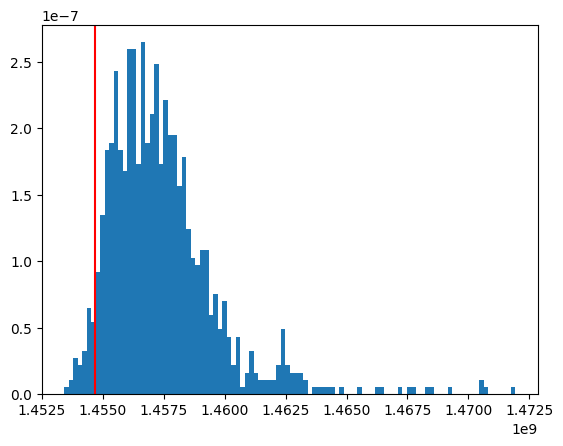

Application_593655901 [6.89169206e-09]


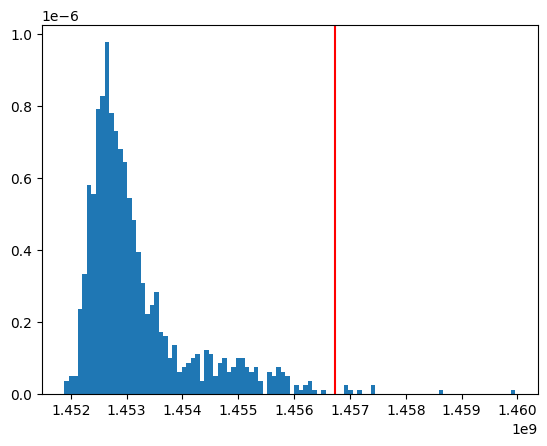

Application_1535675187 [3.22133216e-08]


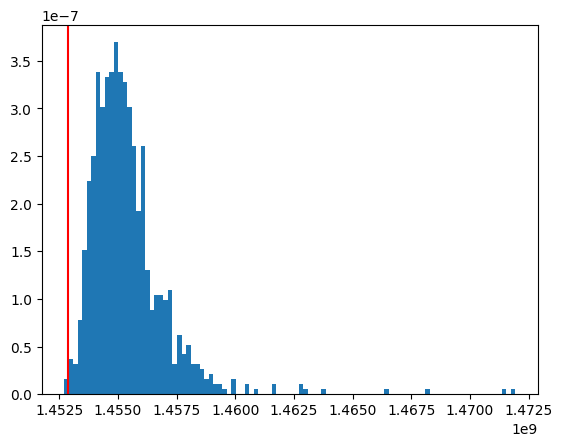

Application_1767756144 [6.34479047e-07]


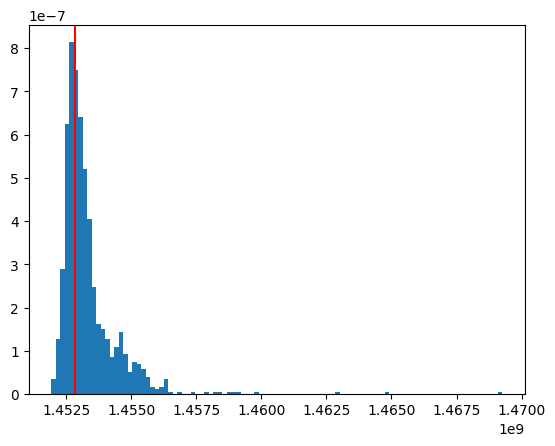

Application_1405679737 [1.54915772e-07]


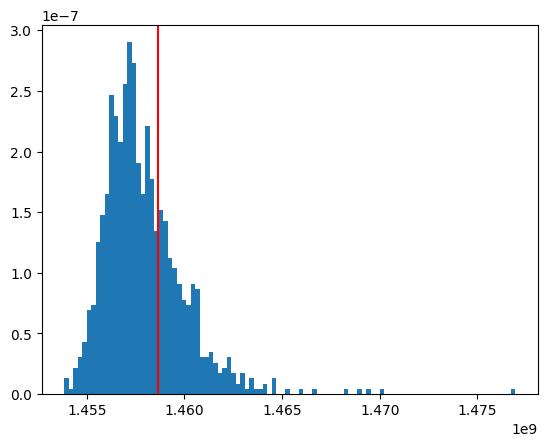

Application_446334558 [8.44092171e-08]


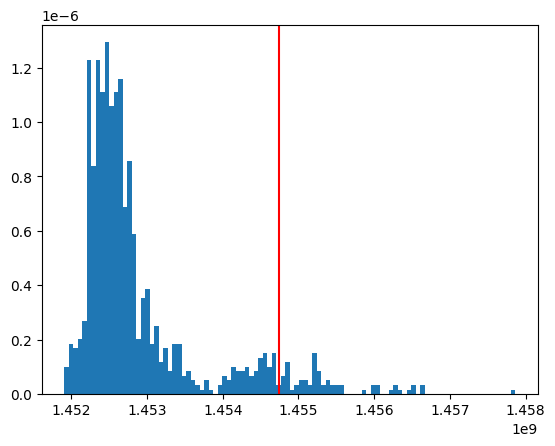

Application_130460765 [5.30746258e-07]


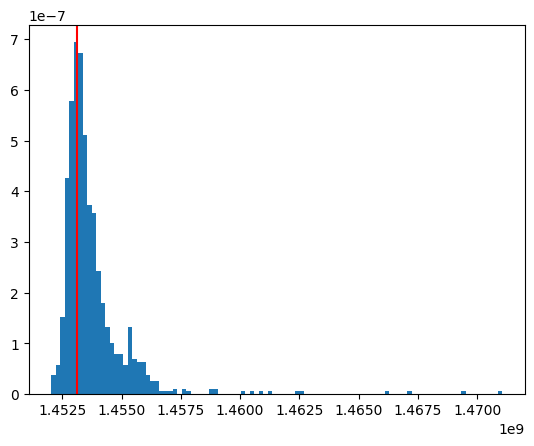

Application_1300843234 [5.99949008e-07]


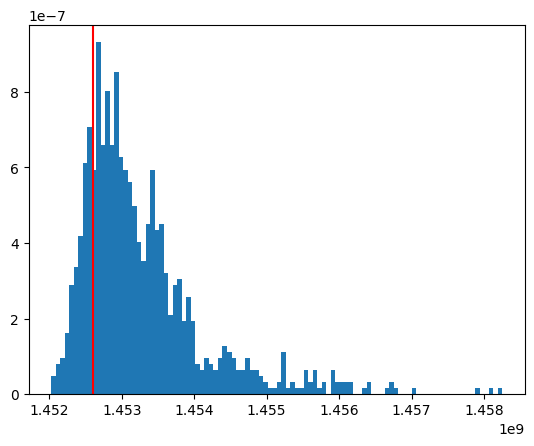

Application_1588619628 [4.21683606e-09]


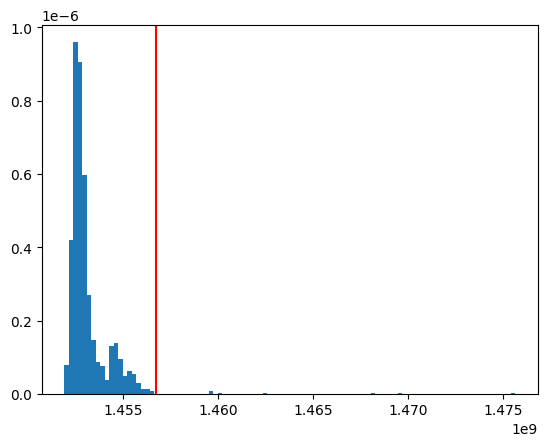

Application_505474597 [6.26362611e-07]


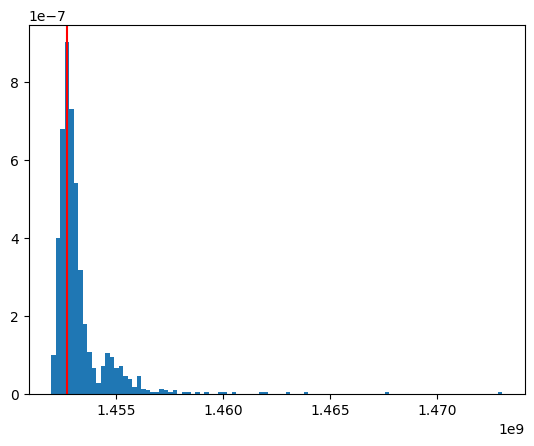

Application_1765204099 [5.48632949e-07]


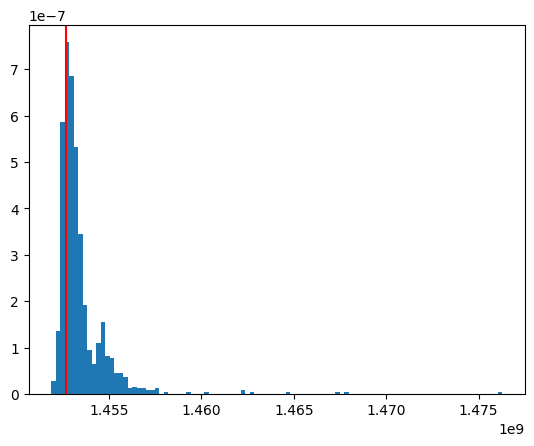

Application_1624825294 [1.80951084e-07]


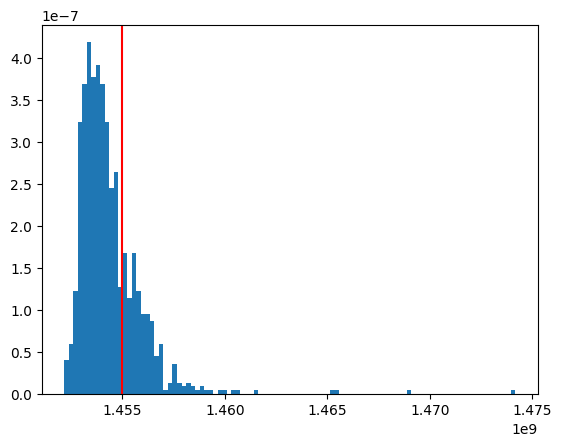

Application_1448214642 [2.78011146e-07]


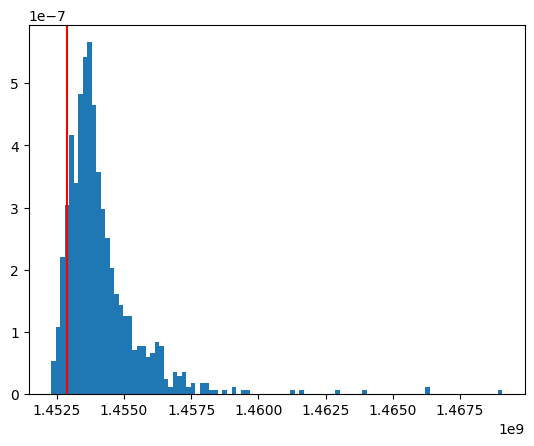

Application_987262285 [3.3436371e-07]


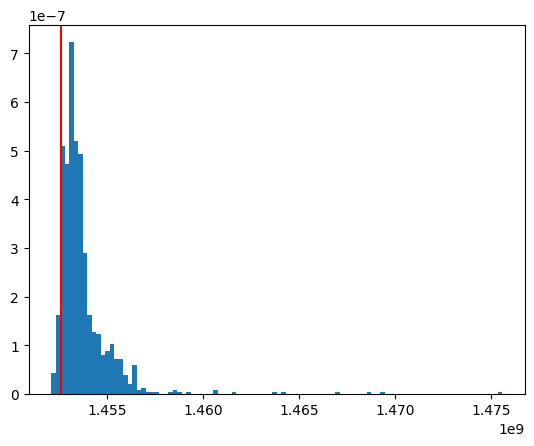

Application_1845547664 [5.95551664e-07]


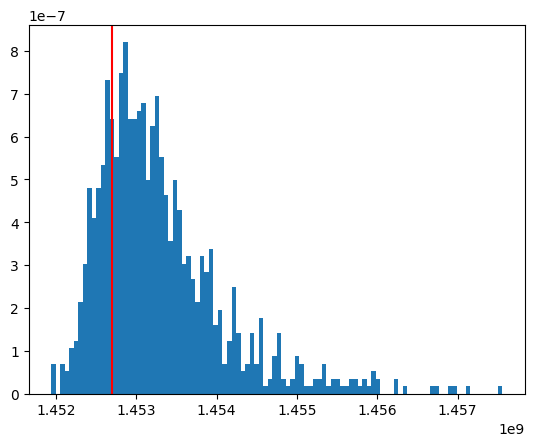

Application_1947648225 [1.39151573e-08]


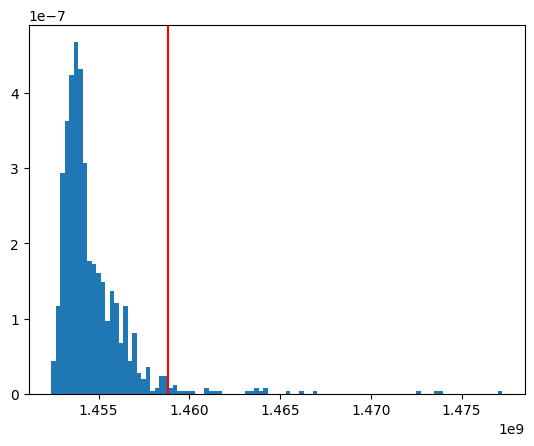

Application_1130101747 [8.74296826e-08]


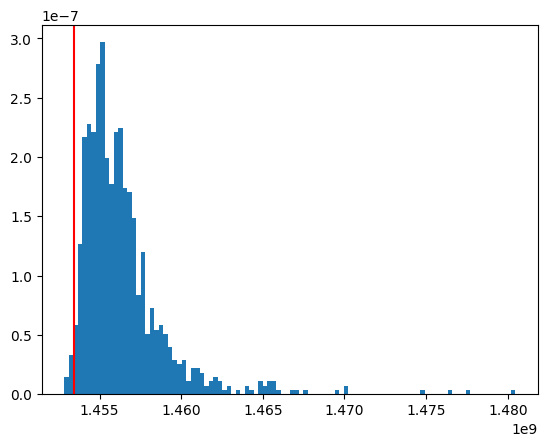

Application_798605556 [6.58954982e-07]


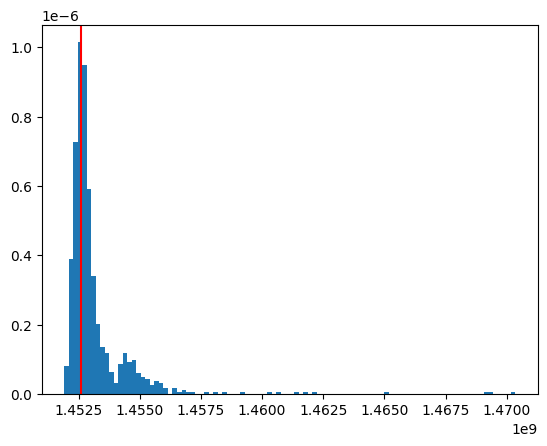

Application_2062932311 [4.44653116e-07]


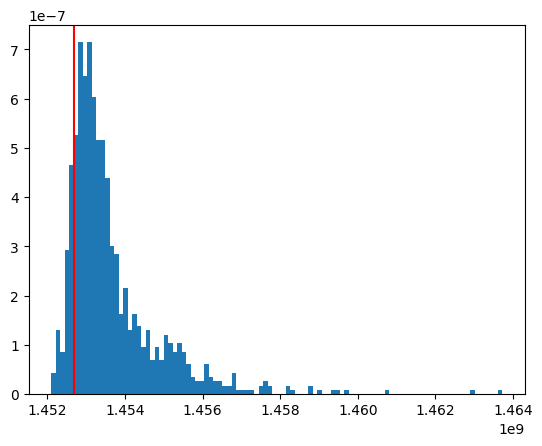

Application_430902047 [3.91157671e-07]


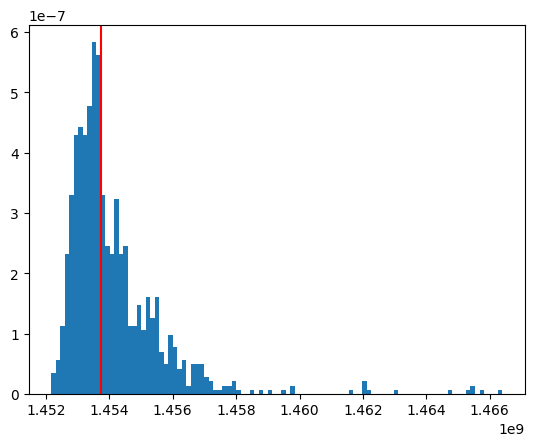

Application_1370588808 [7.77582768e-08]


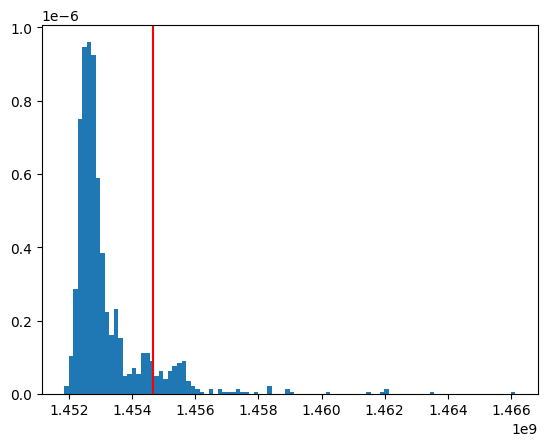

Application_163777174 [2.99634124e-07]


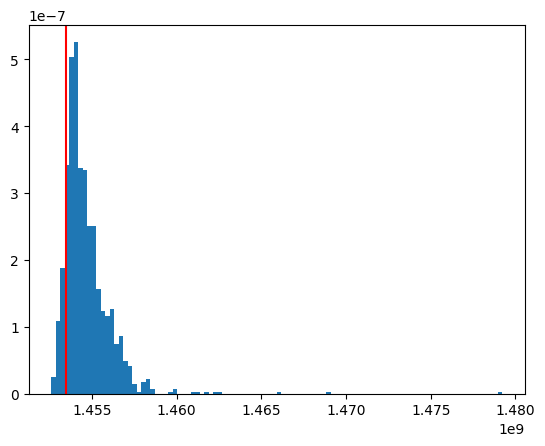

Application_909491524 [3.36976552e-07]


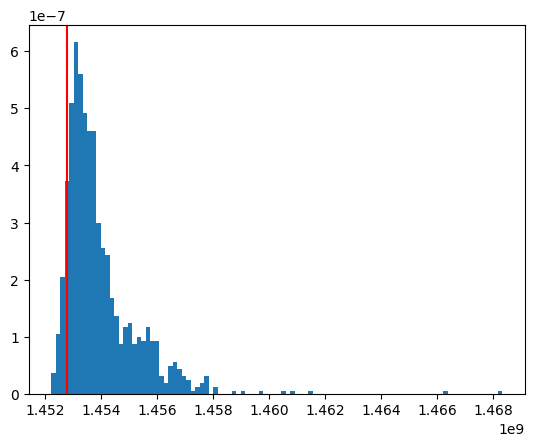

Application_396349881 [5.61878832e-07]


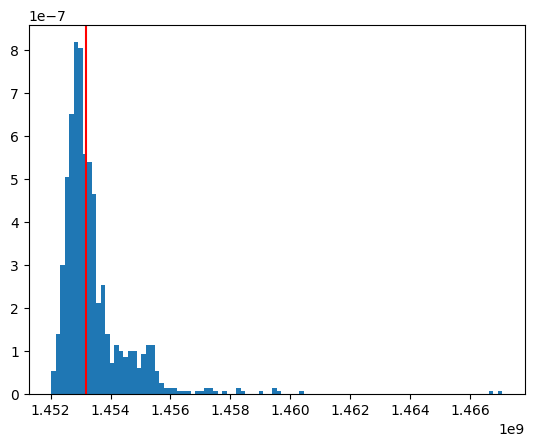

Application_930742634 [1.59363816e-07]


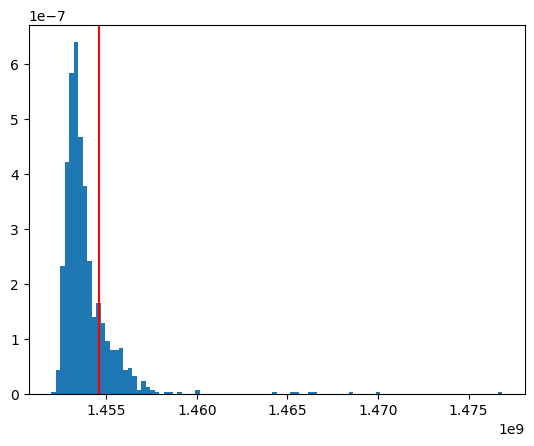

Application_2068443797 [5.87420445e-09]


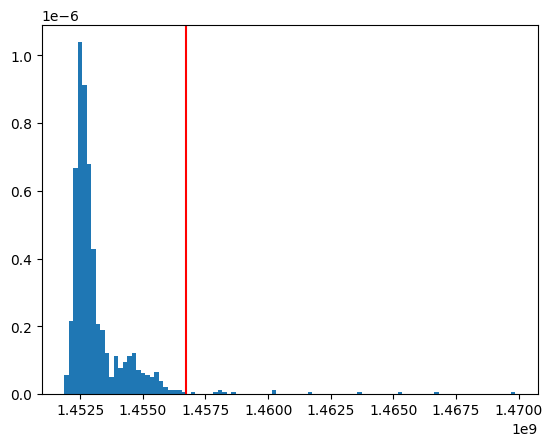

Application_354702724 [6.27342314e-07]


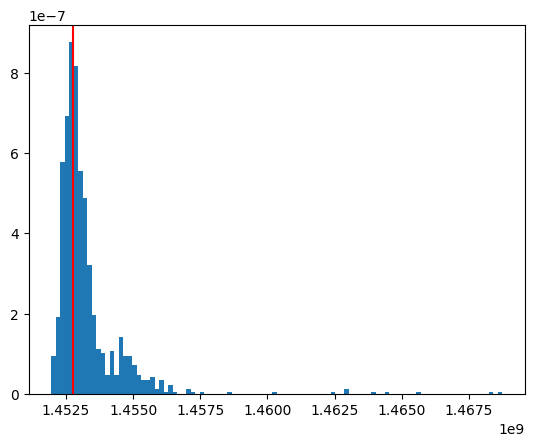

Application_1357431492 [9.43029596e-08]


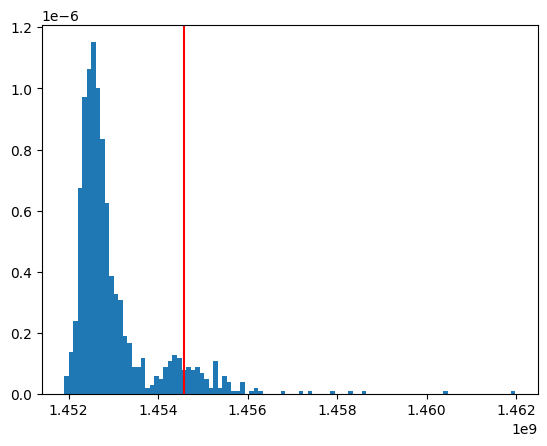

Application_584603670 [9.43959708e-08]


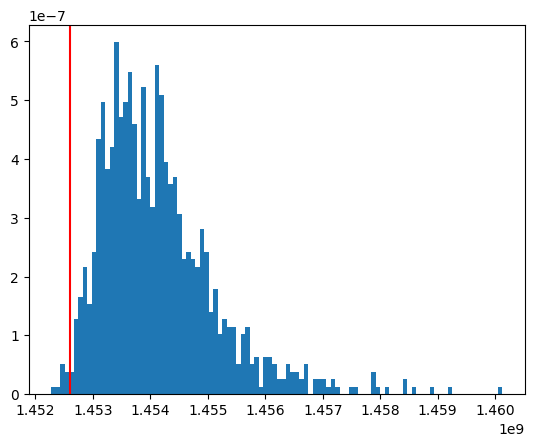

Application_807916303 [6.0195645e-08]


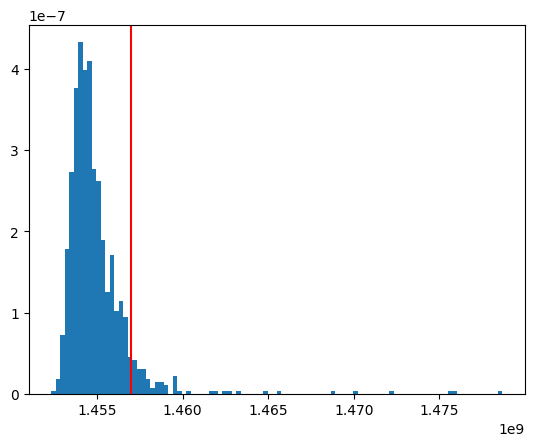

Application_283012951 [4.41849275e-07]


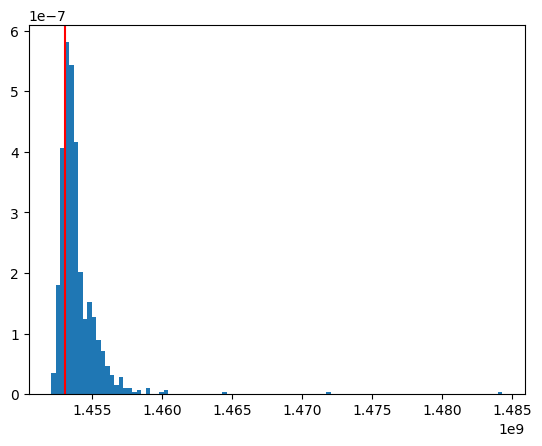

Application_1876456626 [6.0760987e-08]


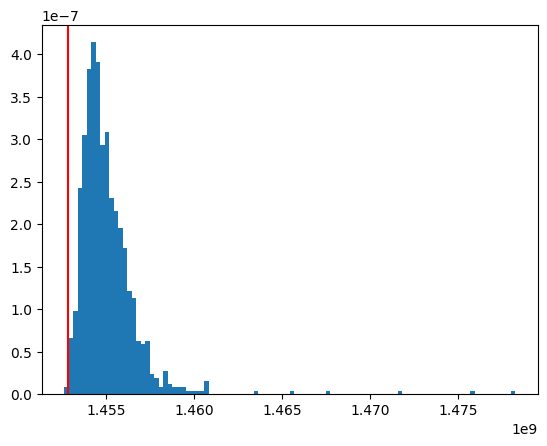

Application_178025821 [4.42423312e-07]


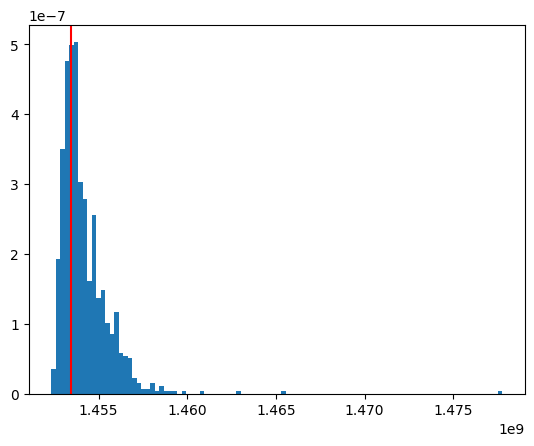

Application_813133375 [5.3470836e-07]


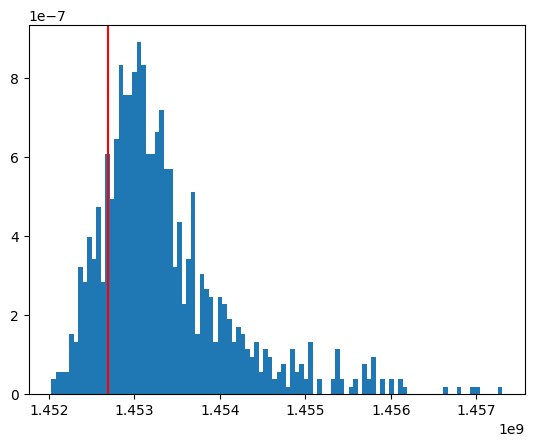

Application_268676496 [5.01084894e-07]


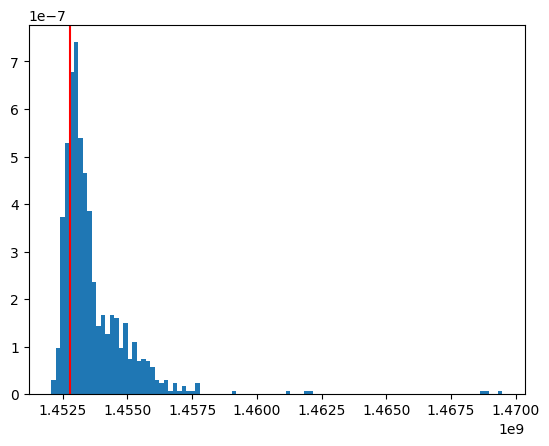

Application_1870161219 [1.61351235e-07]


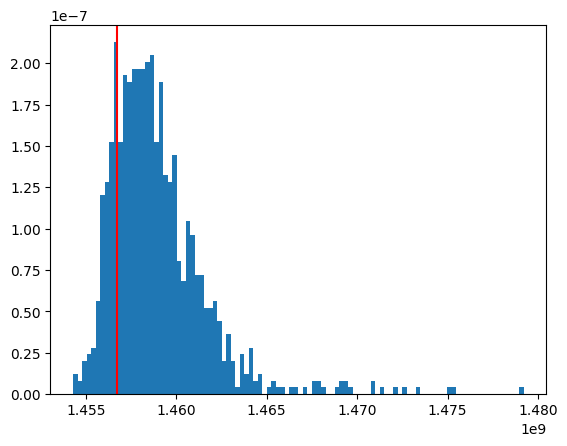

Application_1723779444 [6.50898061e-09]


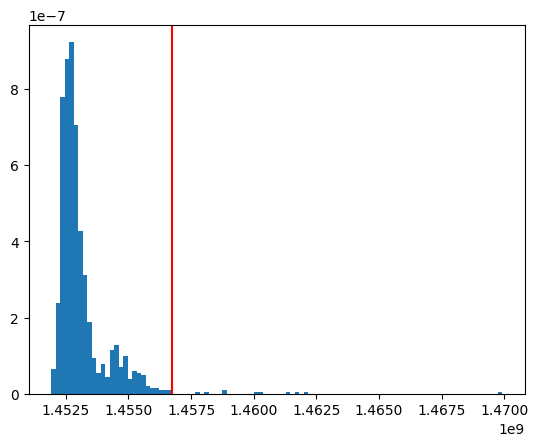

Application_1339153511 [1.19538999e-07]


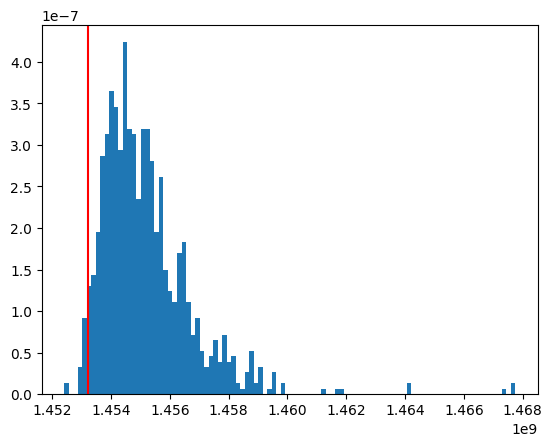

Application_1754646859 [4.37631603e-09]


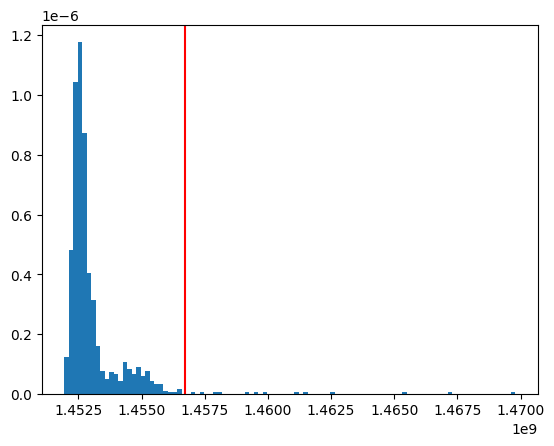

Application_2002564265 [7.9586594e-07]


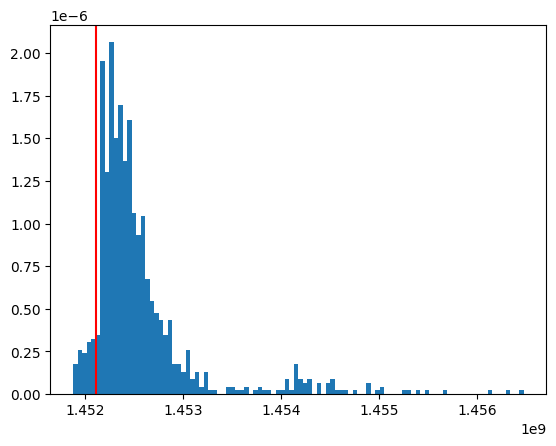

Application_1304234740 [2.48726169e-07]


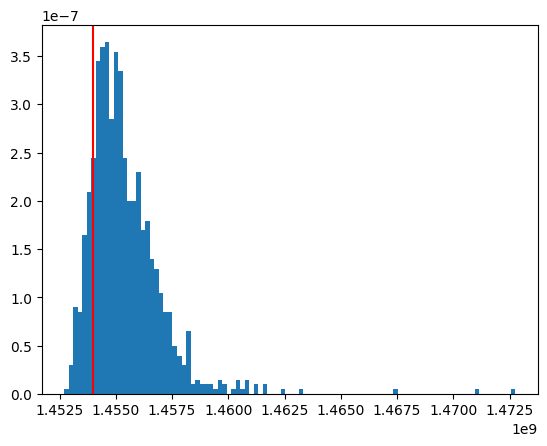

Application_58755651 [6.43562569e-07]


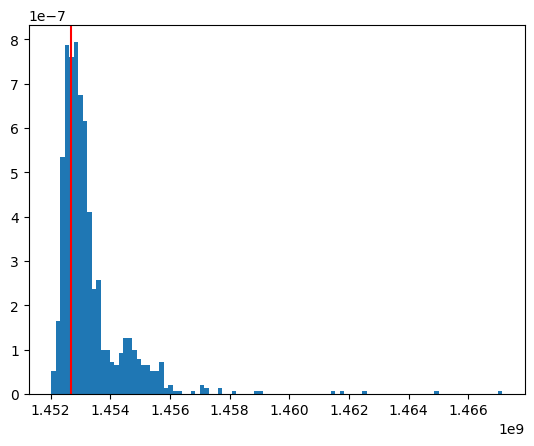

Application_93597308 [1.83556759e-07]


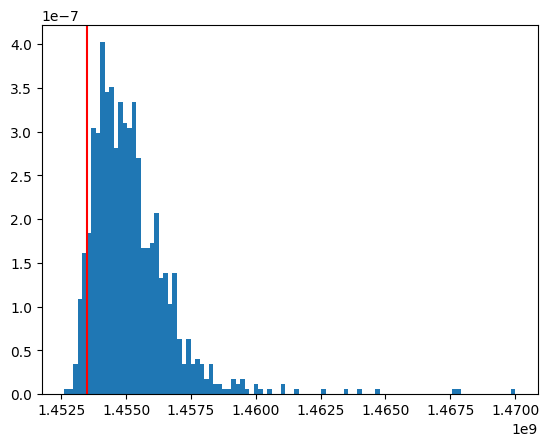

Application_774787486 [1.29295413e-07]


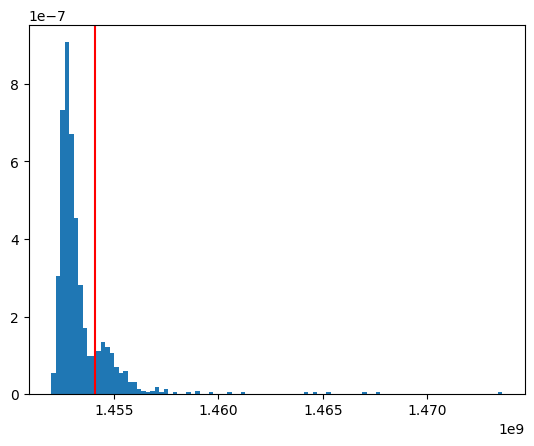

Application_1660185664 [2.66894275e-08]


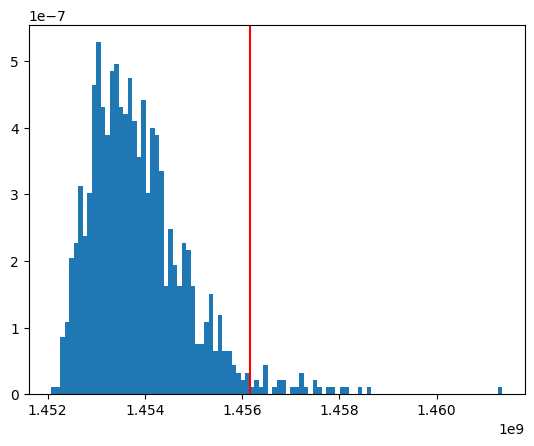

Application_2105878744 [3.94220985e-07]


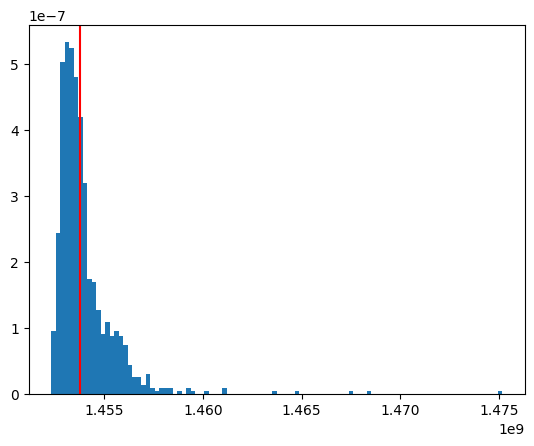

Application_1446096185 [3.9055788e-07]


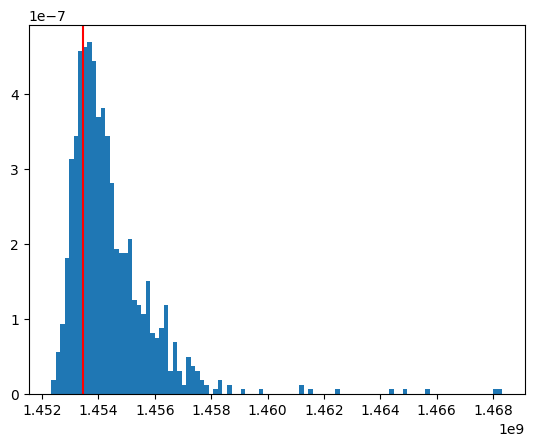

Application_675073178 [2.75502943e-07]


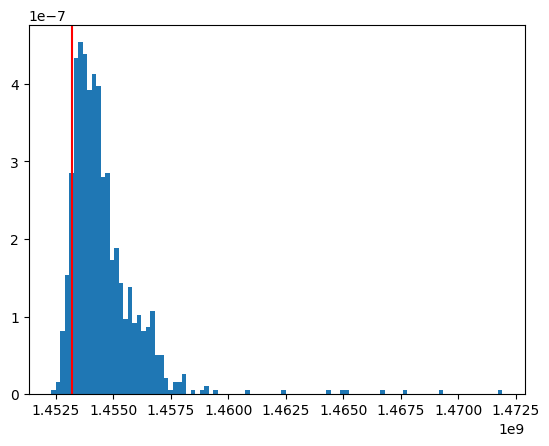

Application_952532843 [1.94734913e-08]


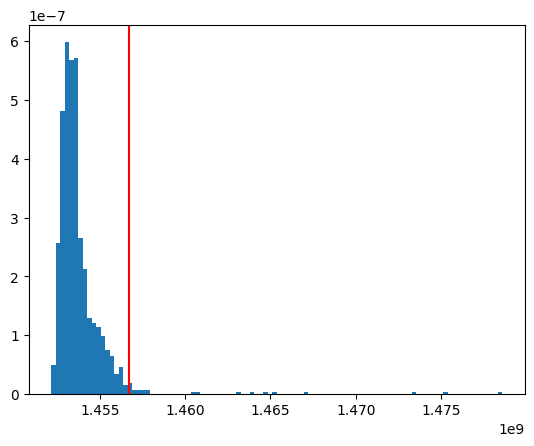

Application_914660918 [2.9204391e-07]


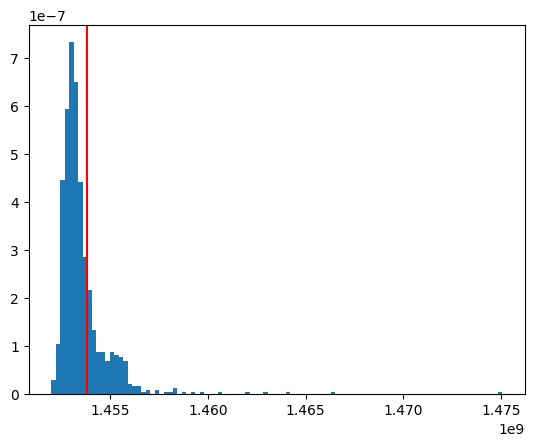

Application_167944225 [2.7148994e-07]


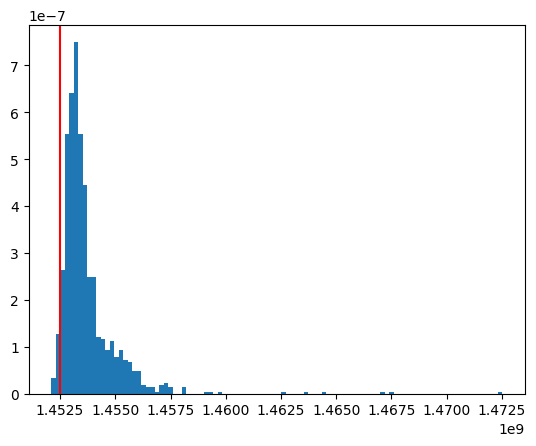

Application_1962860870 [3.8877798e-07]


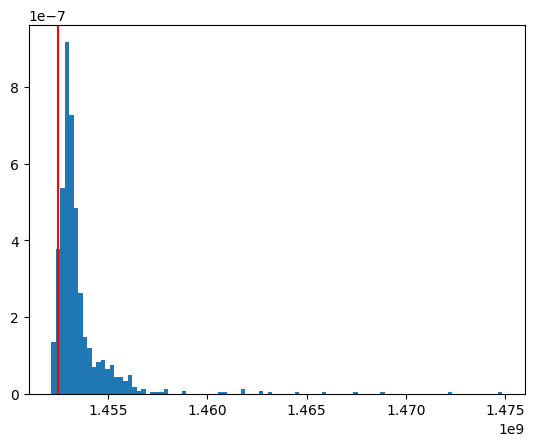

Application_1696031128 [5.36699171e-07]


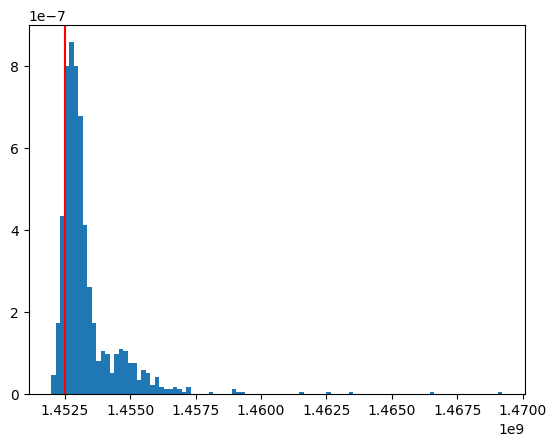

Application_803879893 [1.4255909e-07]


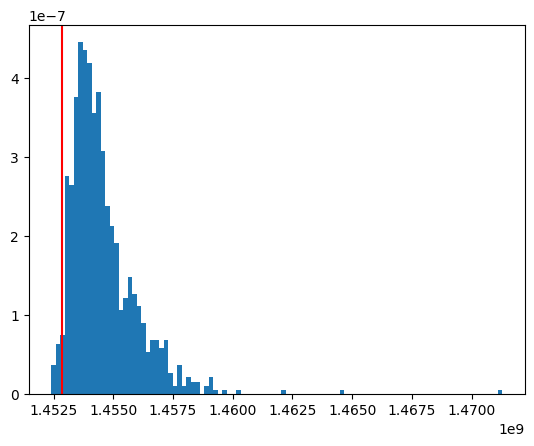

Application_1886382319 [8.04175059e-09]


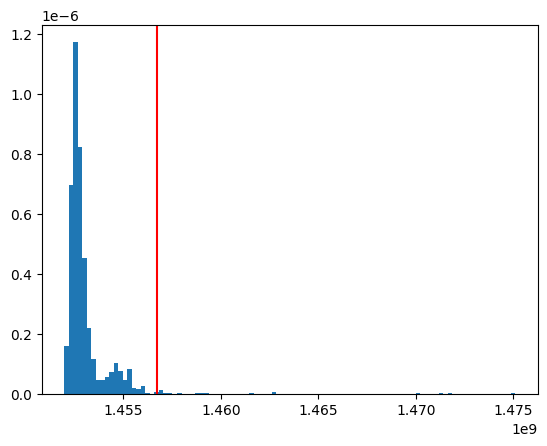

Application_1250134245 [6.36942687e-09]


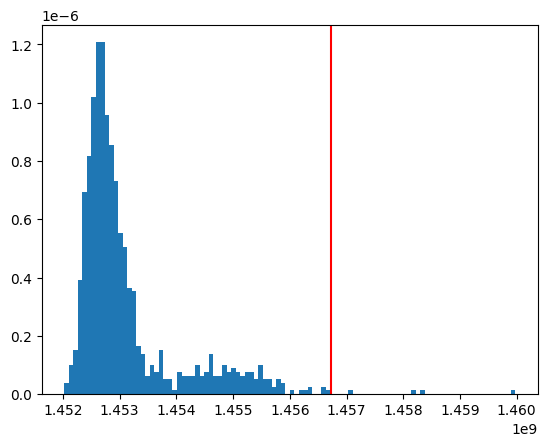

Application_1044610848 [4.91843961e-07]


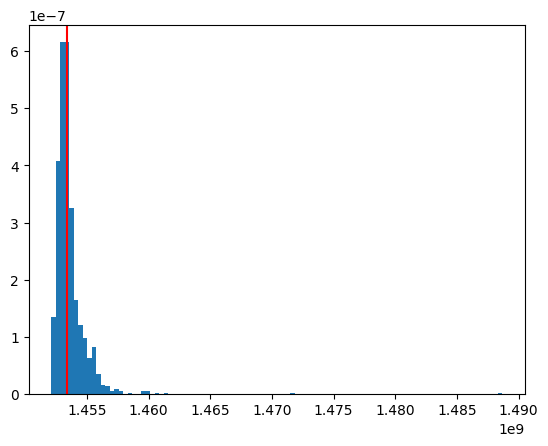

Application_1999238509 [4.31905145e-07]


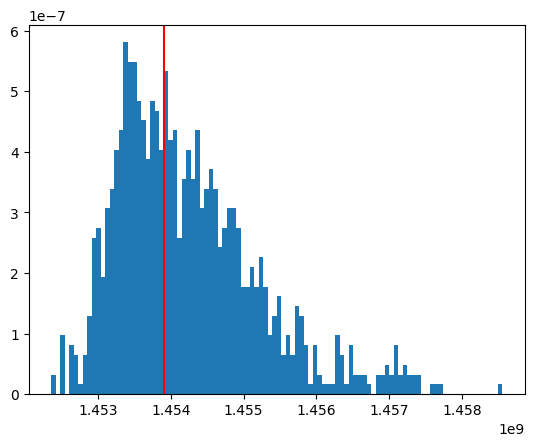

Application_854524772 [3.89640678e-07]


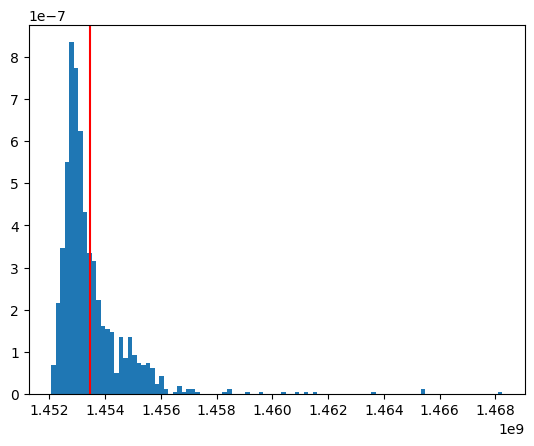

Application_927205634 [1.59493778e-07]


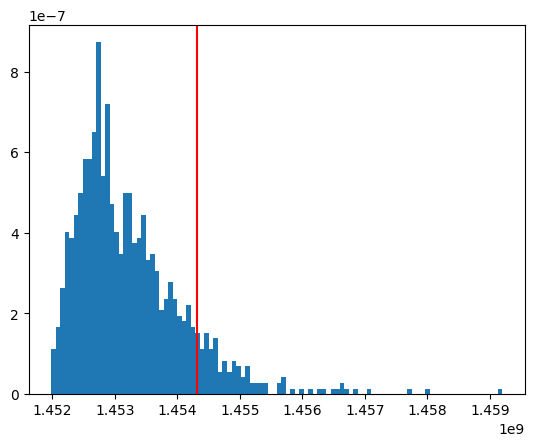

Application_484278024 [1.71078987e-07]


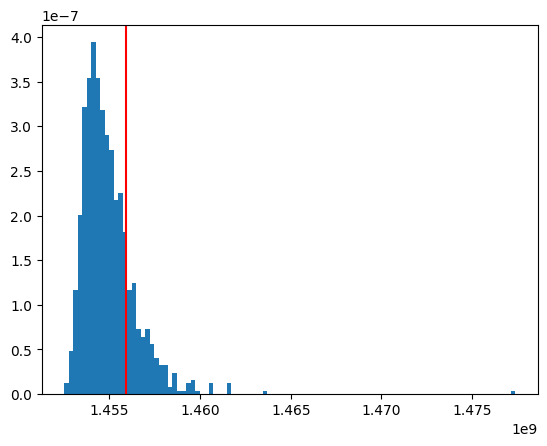

Application_1674281629 [3.21948015e-07]


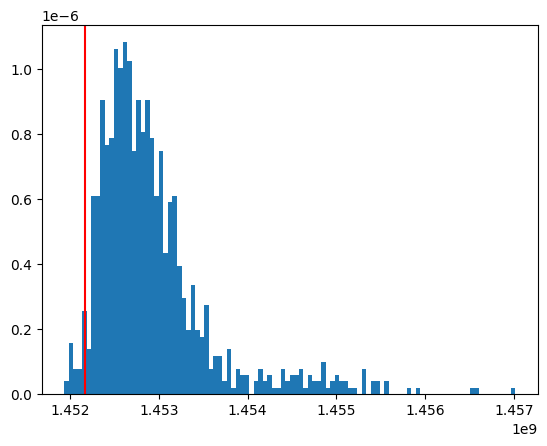

Application_299986859 [3.89251075e-07]


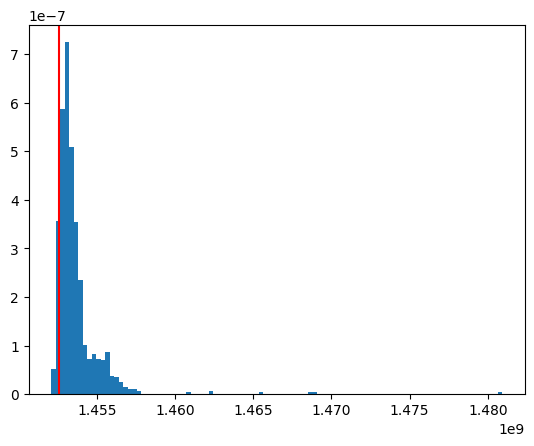

Application_1374020543 [2.40717944e-07]


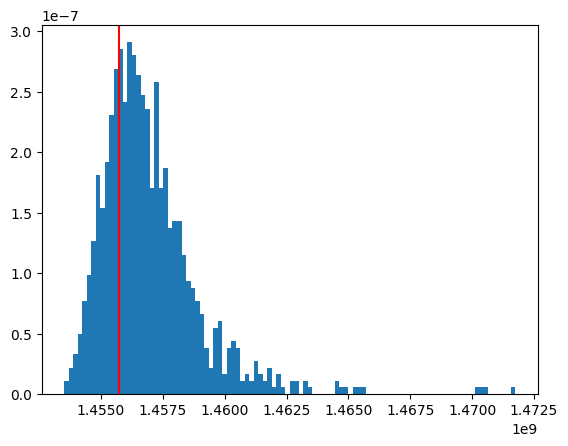

Application_1252717204 [6.1349451e-09]


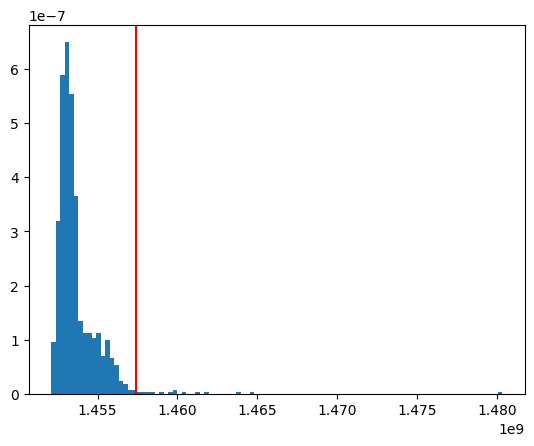

Application_24648067 [6.70321061e-07]


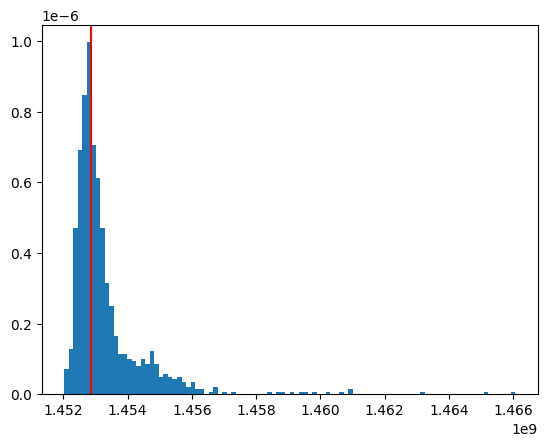

Application_1823402778 [5.59809709e-07]


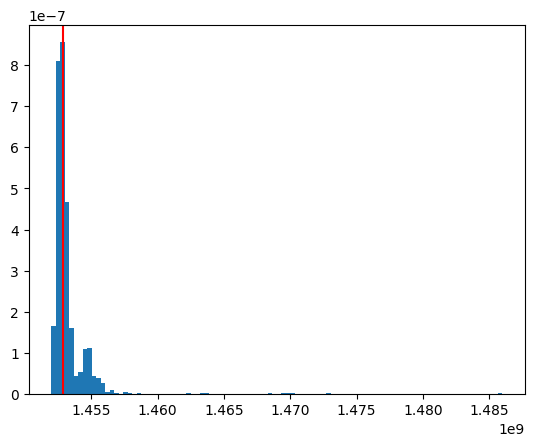

Application_2108937169 [3.62688702e-07]


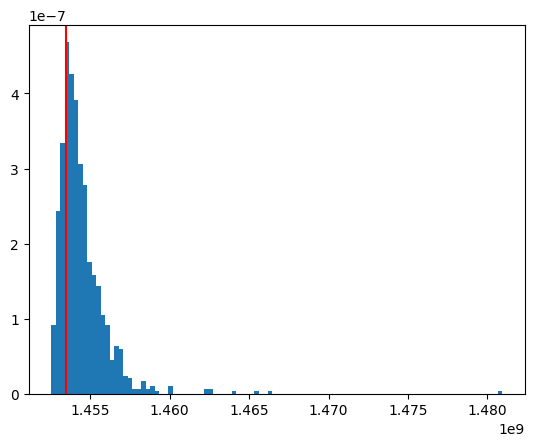

Application_895241174 [5.81936434e-07]


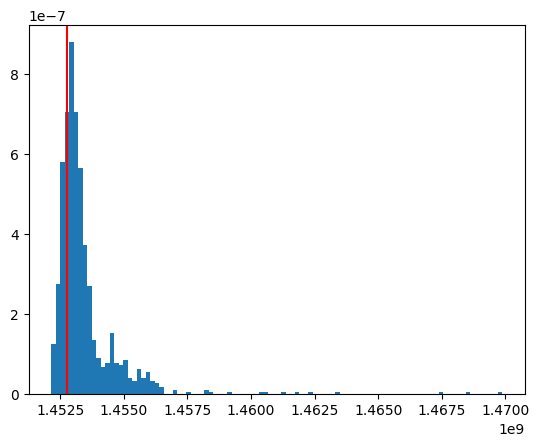

Application_1290239114 [3.22719682e-07]


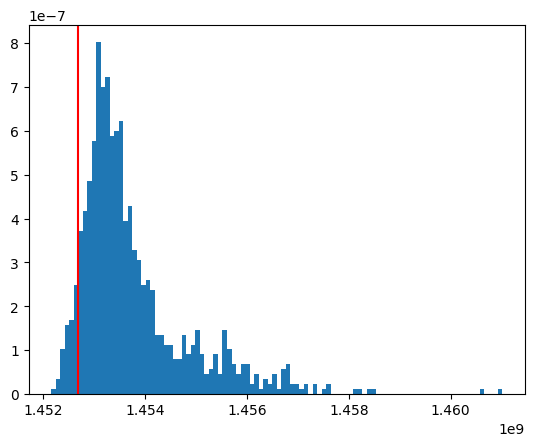

Application_1787371920 [2.43304627e-07]


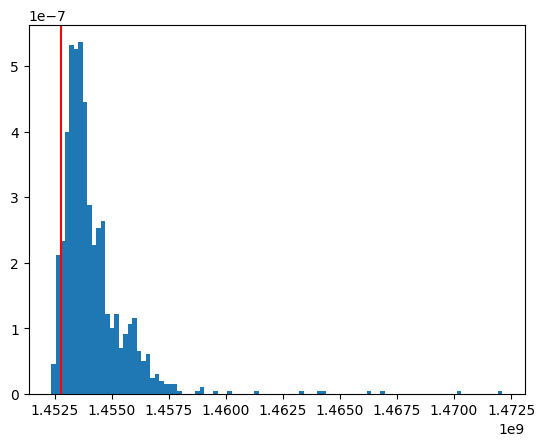

Application_1471099537 [4.37362134e-07]


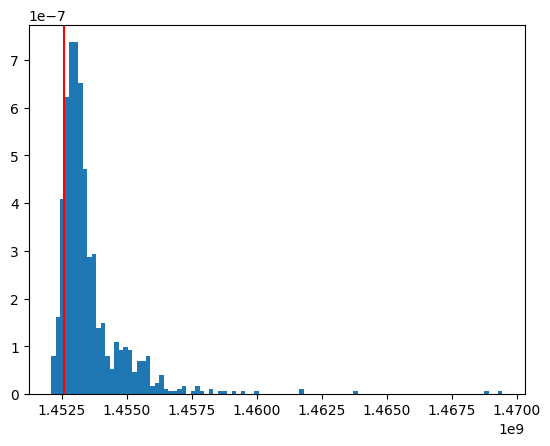

Application_37839400 [2.18198771e-07]


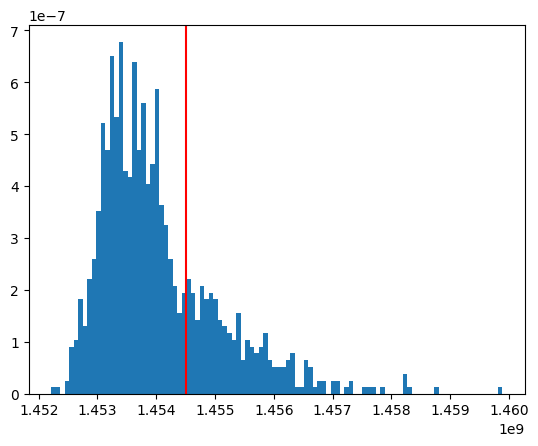

Application_1128910355 [3.07708748e-08]


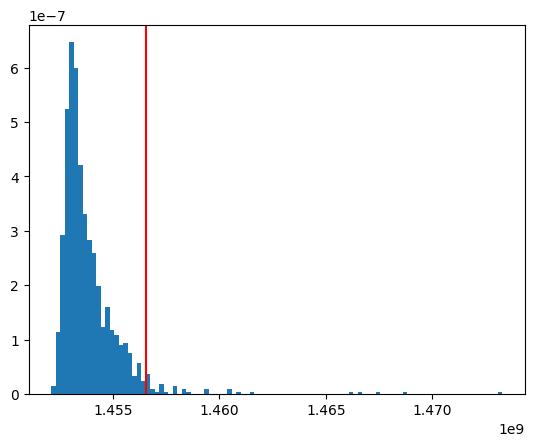

Application_54405635 [1.13382706e-07]


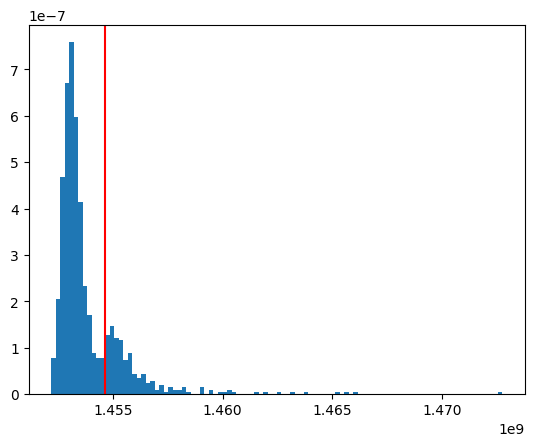

Application_395903076 [5.96381481e-07]


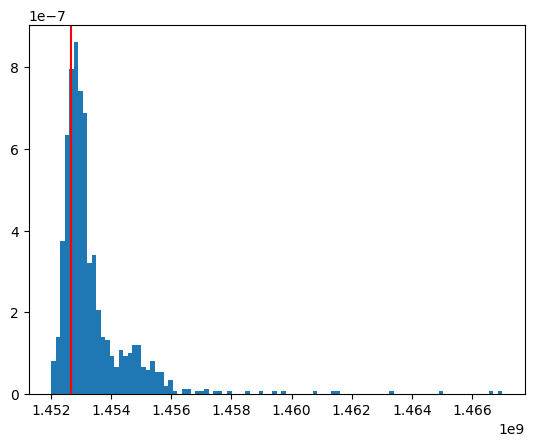

Application_1859638703 [7.94368713e-08]


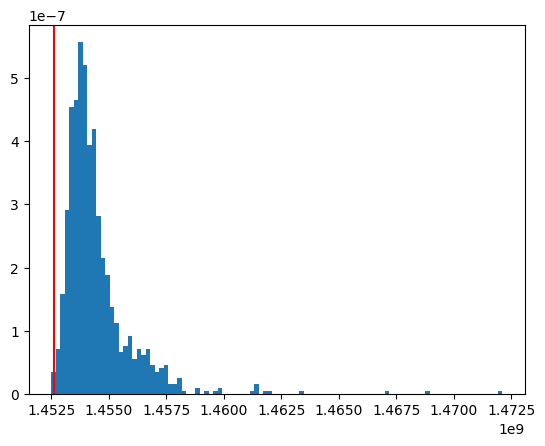

Application_1101997724 [4.68986718e-07]


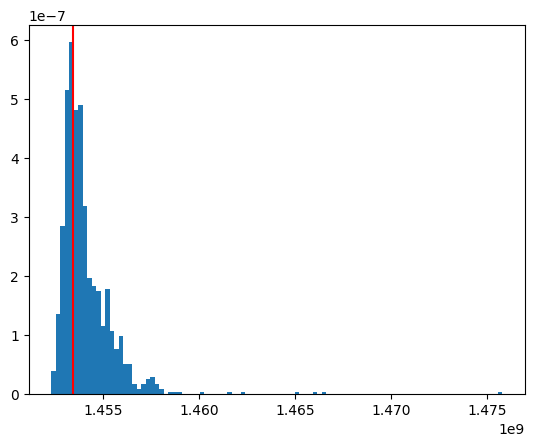

Application_74505494 [8.93693595e-08]


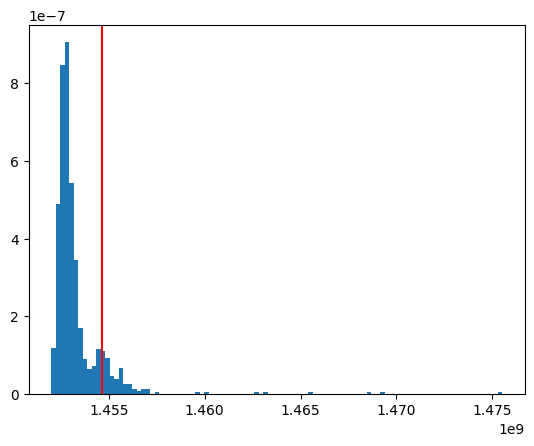

Application_525275343 [3.57609408e-07]


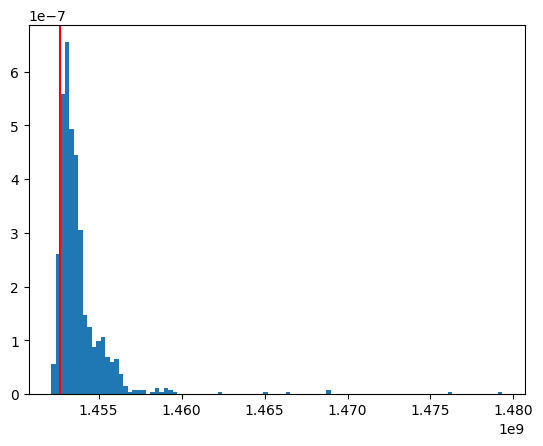

Application_106973225 [9.28172706e-08]


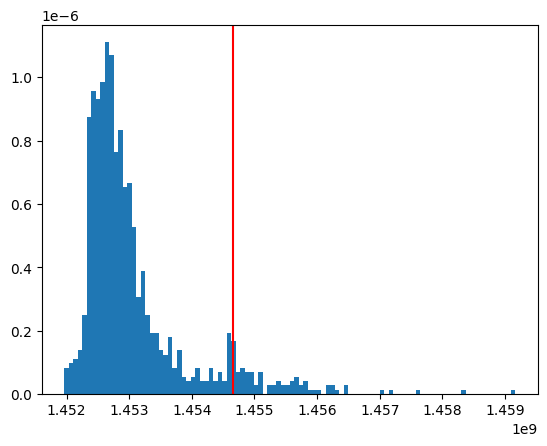

Application_1315608886 [4.99659195e-07]


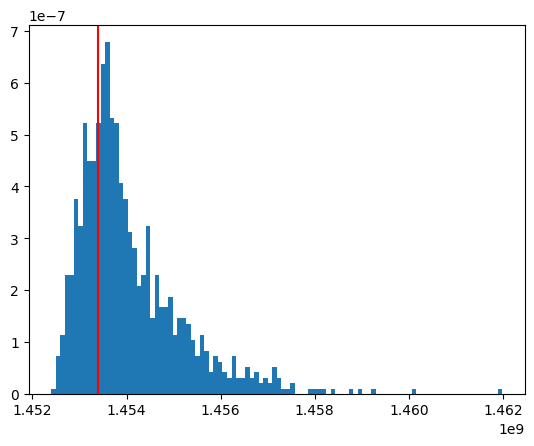

Application_1538441067 [3.04465132e-07]


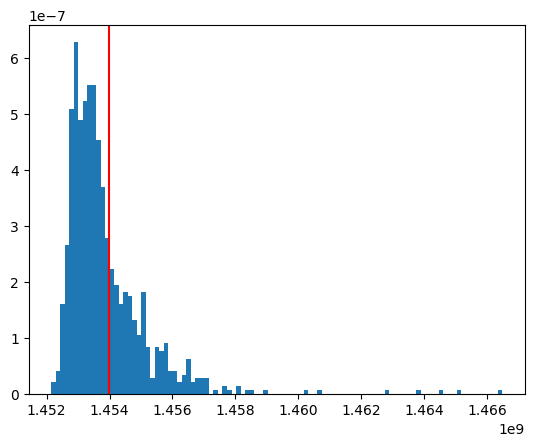

Application_822724921 [1.16732041e-07]


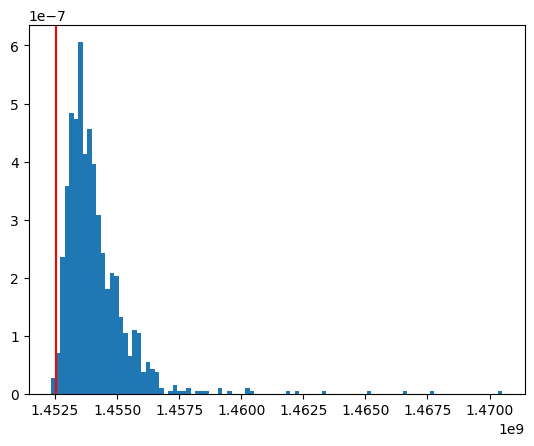

Application_2040511284 [7.01382262e-08]


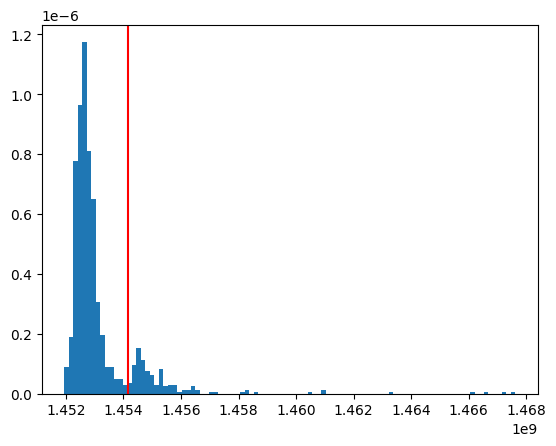

Application_1754943309 [3.18510726e-07]


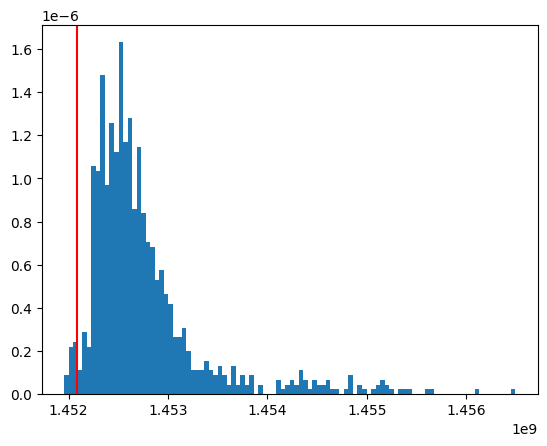

Application_323012882 [2.5753421e-07]


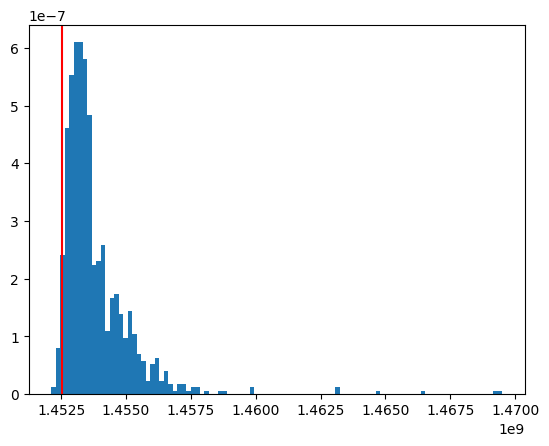

Application_347136910 [6.12668193e-07]


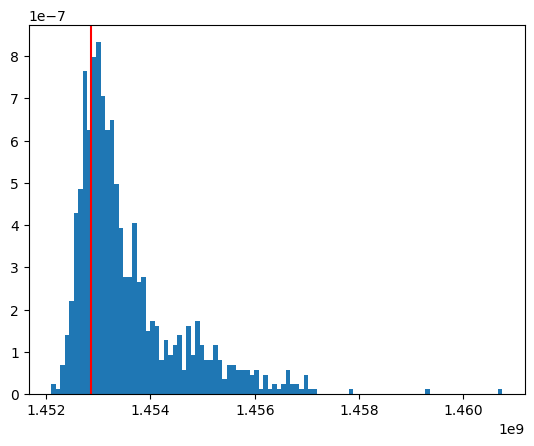

Application_1432907447 [4.40223781e-07]


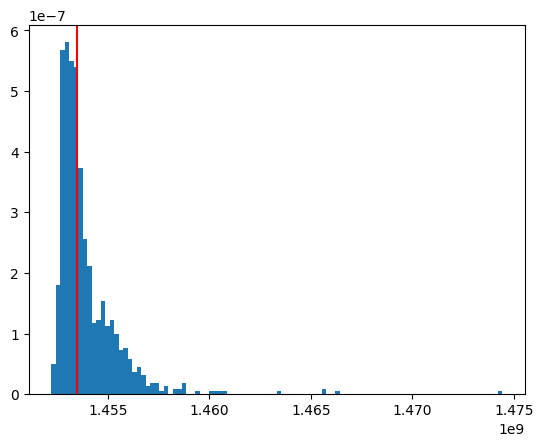

Application_1004303396 [9.77755083e-08]


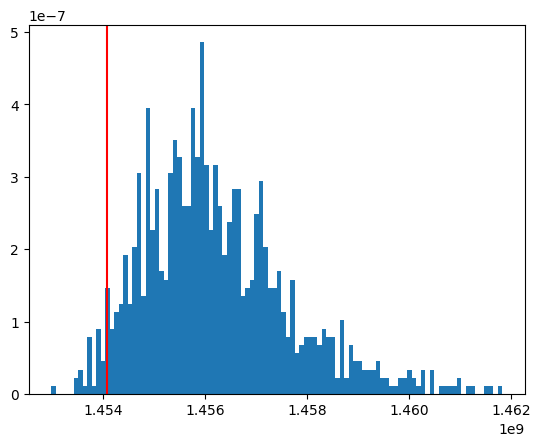

Application_1096831814 [1.28468072e-07]


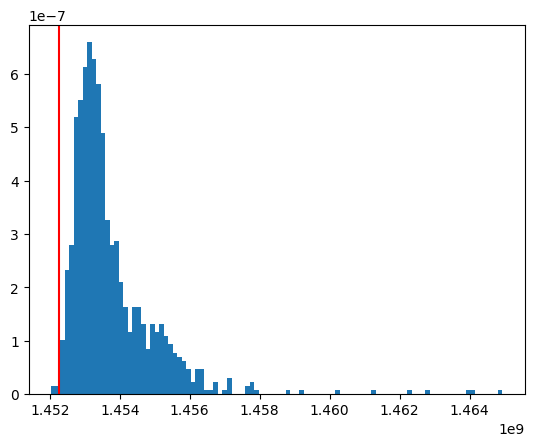

Application_1068218912 [2.00782435e-08]


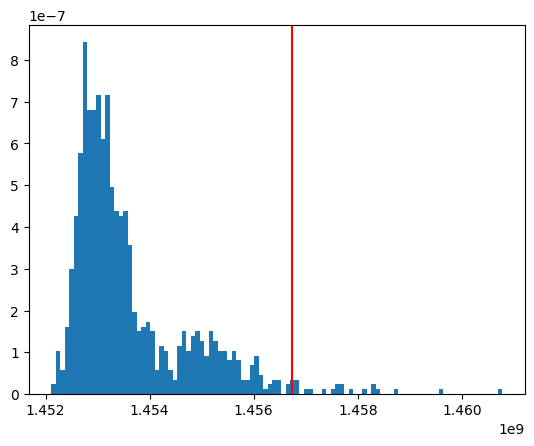

Application_709929024 [3.61703436e-07]


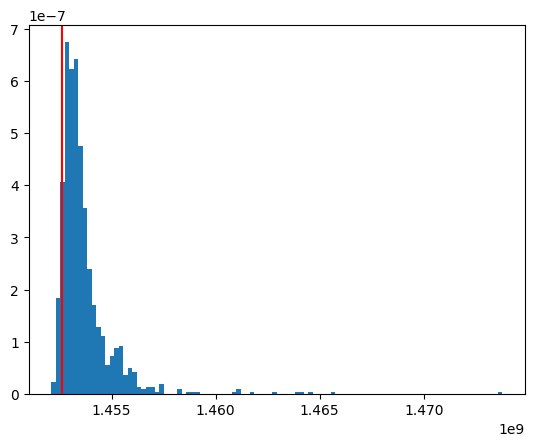

Application_347787380 [8.4254844e-08]


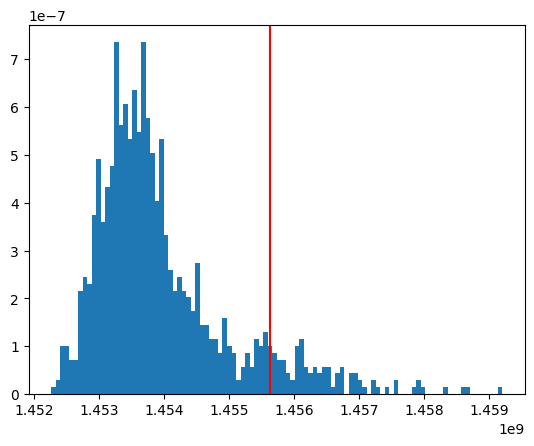

Application_1546754076 [3.4929188e-07]


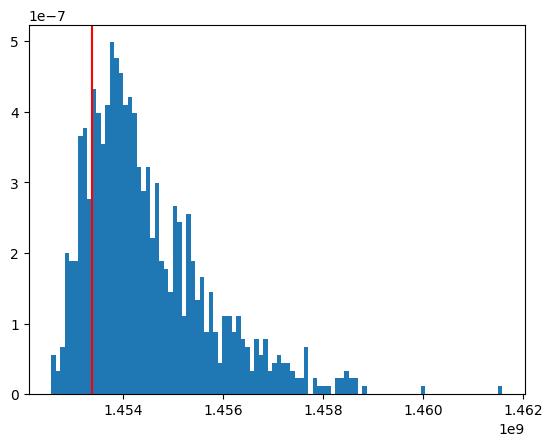

Application_1365381023 [1.41825381e-08]


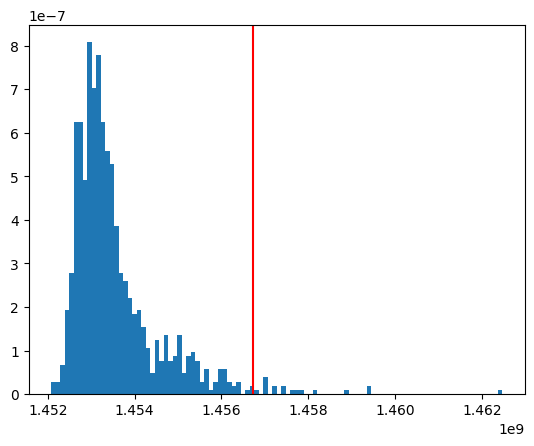

Application_1981969728 [4.36880938e-07]


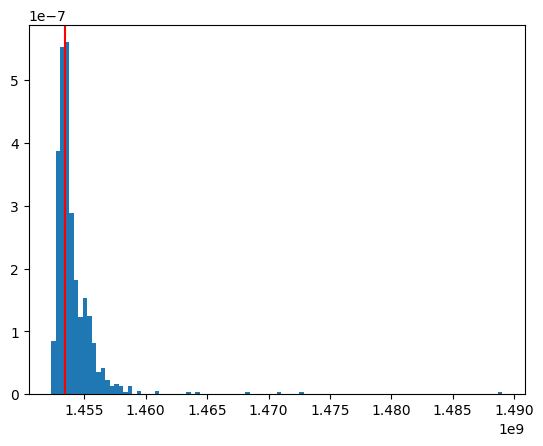

Application_665878125 [2.06598816e-08]


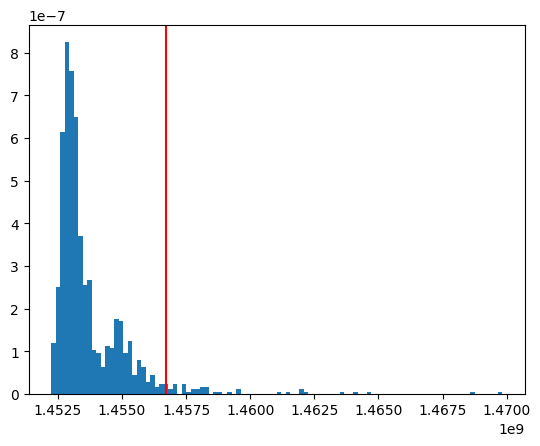

Application_1044911465 [1.10534155e-08]


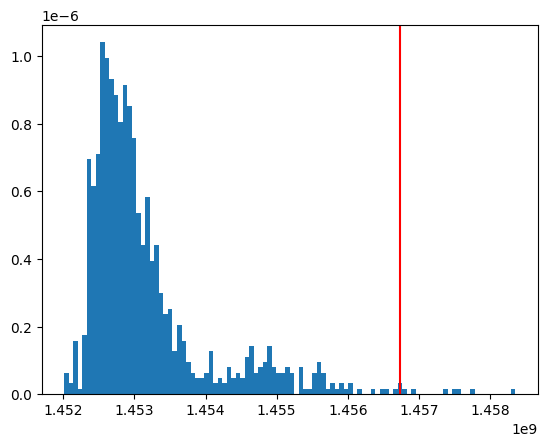

Application_1613424593 [2.35180059e-07]


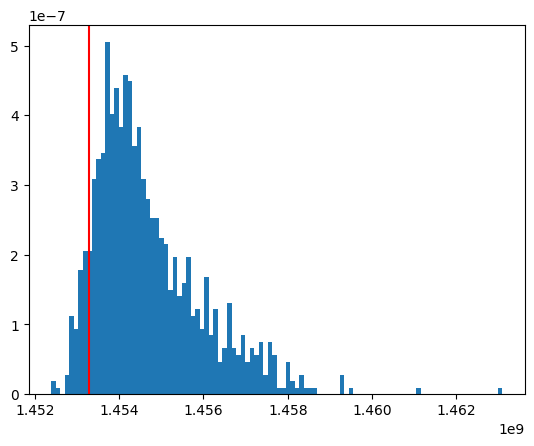

Application_862160604 [1.13881573e-08]


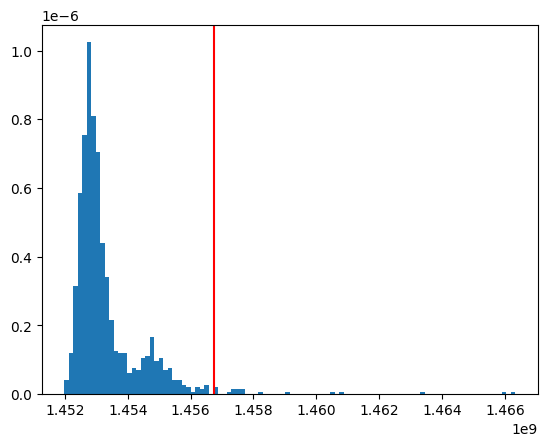

Application_60181210 [4.74895429e-07]


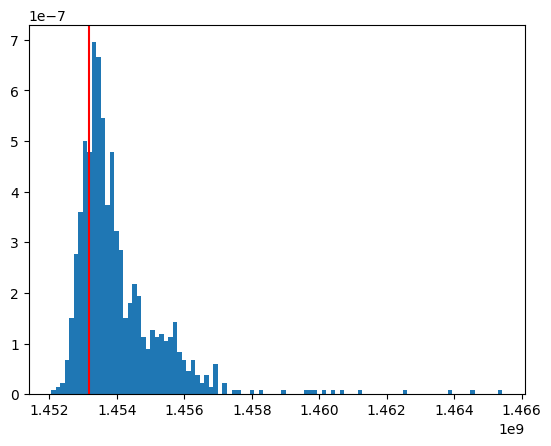

Application_369018038 [9.62640822e-08]


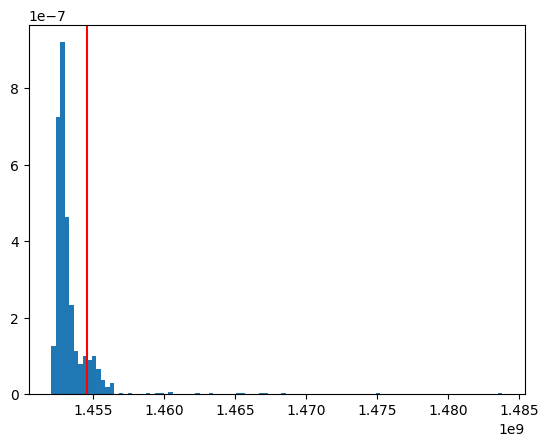

Application_920048730 [1.26585532e-07]


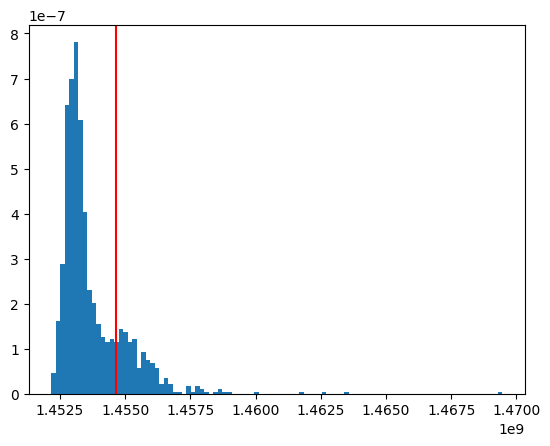

Application_220402598 [9.77532544e-08]


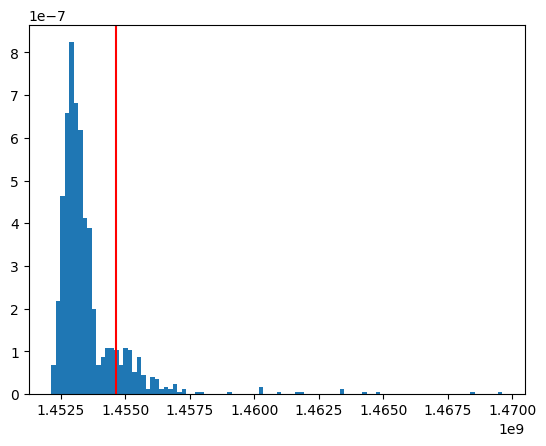

Application_1947668470 [5.63790482e-07]


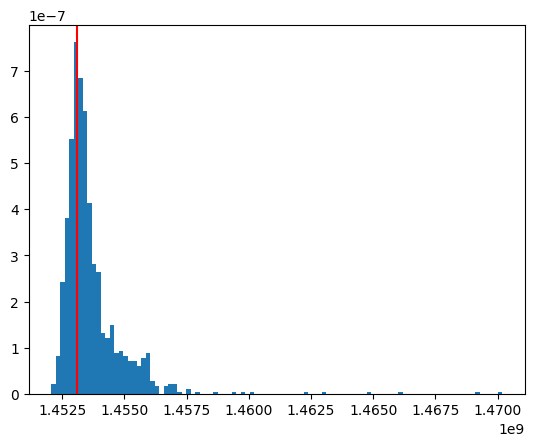

Application_1301925609 [2.28814083e-07]


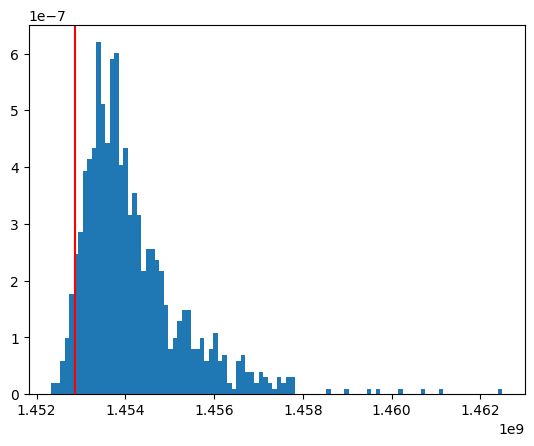

Application_2070389081 [4.50636148e-07]


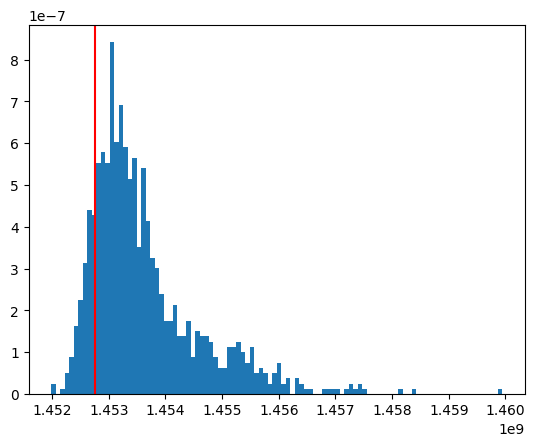

Application_864903752 [2.70276712e-07]


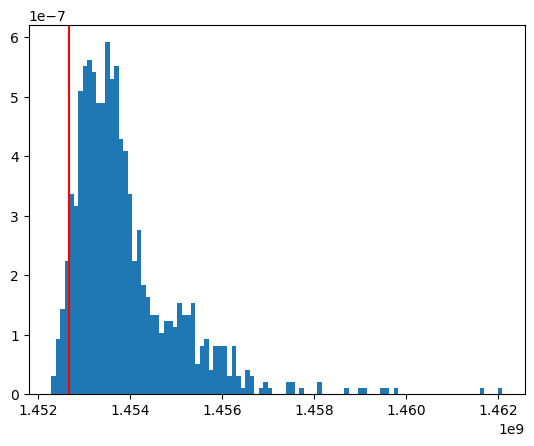

Application_1159653941 [1.05189711e-07]


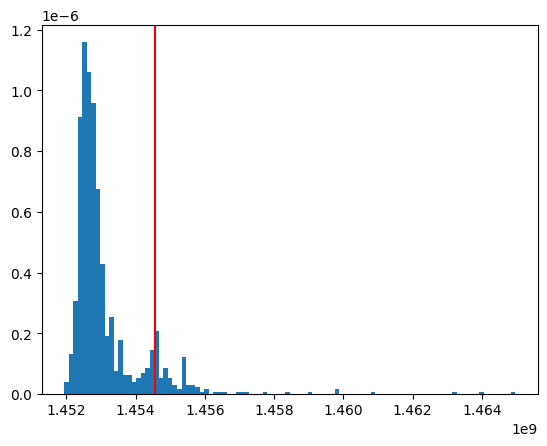

Application_663648942 [1.57537715e-08]


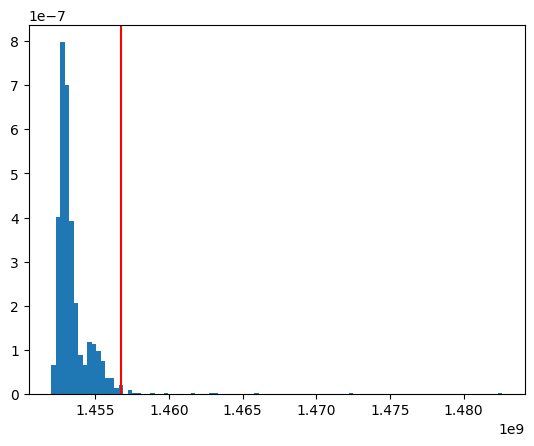

Application_1616009132 [4.25592958e-07]


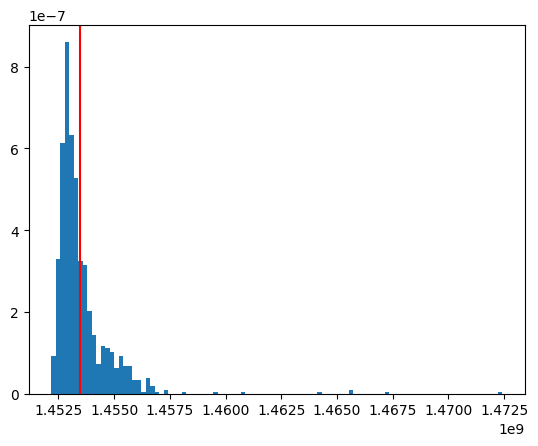

Application_53530491 [6.18187395e-07]


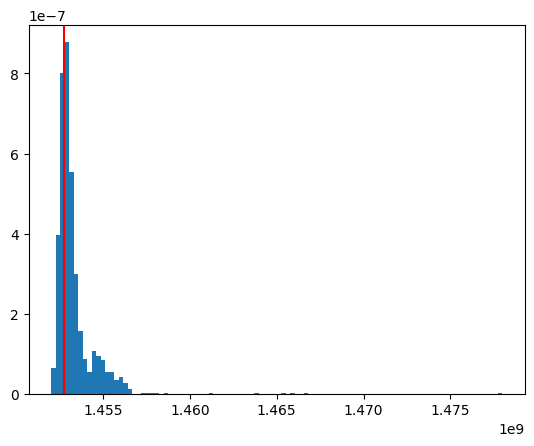

Application_1953406738 [1.21310053e-08]


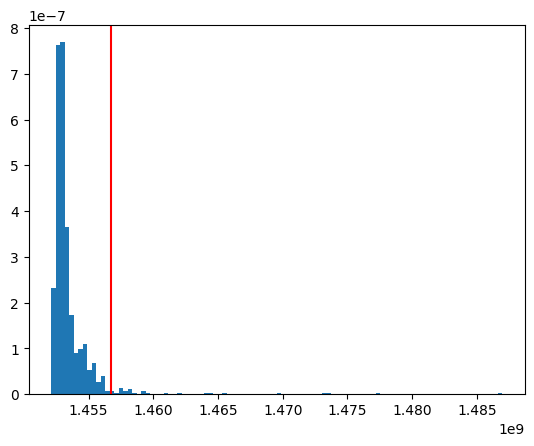

Application_1413308979 [6.78424988e-07]


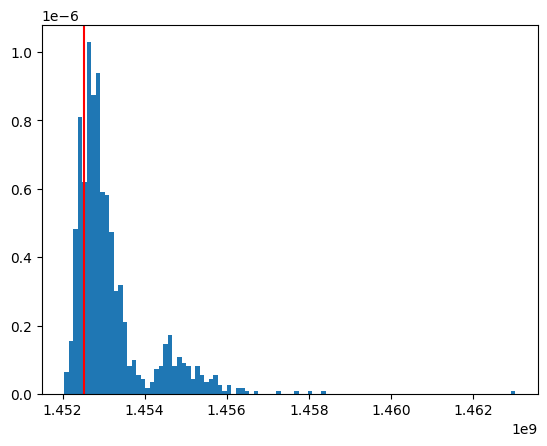

Application_1308403282 [4.8632932e-07]


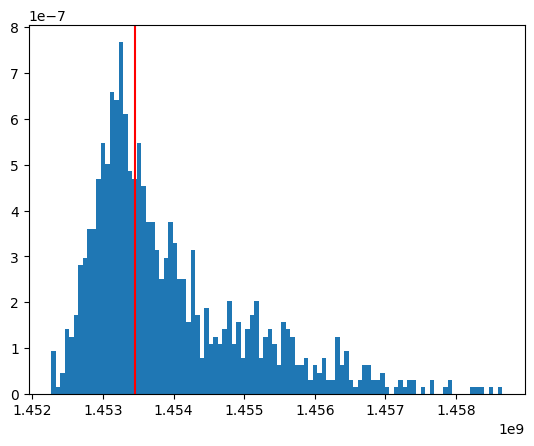

Application_212010049 [6.51622115e-07]


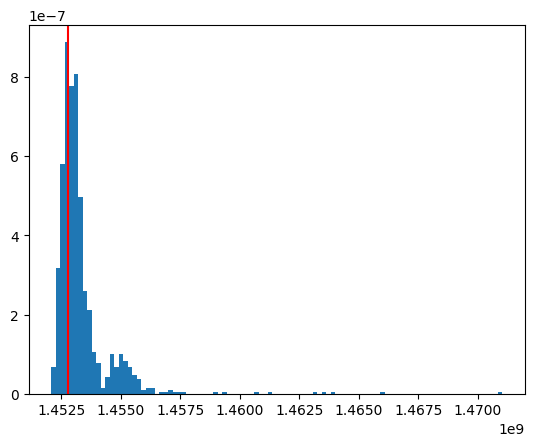

Application_1946680177 [9.42593487e-08]


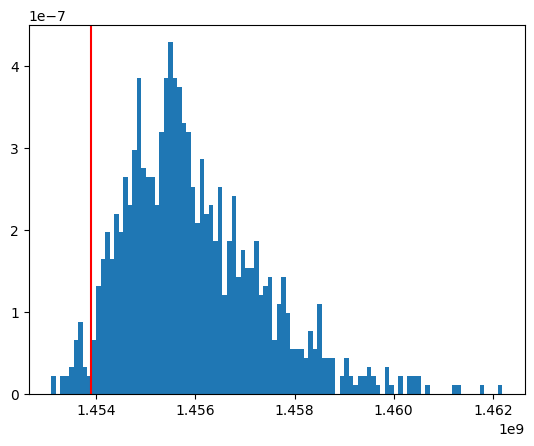

Application_948316229 [1.51345822e-07]


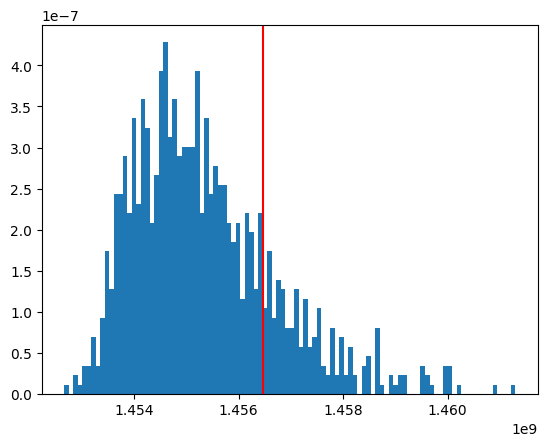

Application_1138826038 [2.14241491e-07]


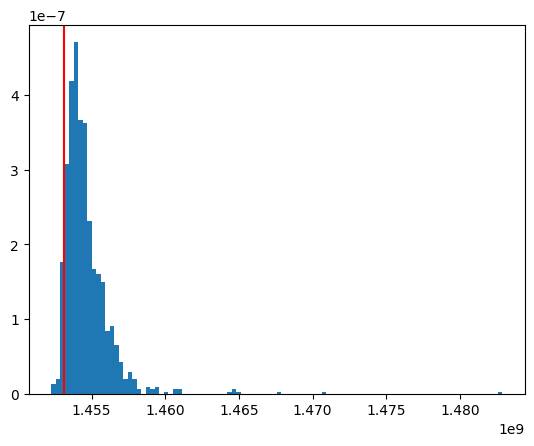

Application_369105792 [8.25698492e-07]


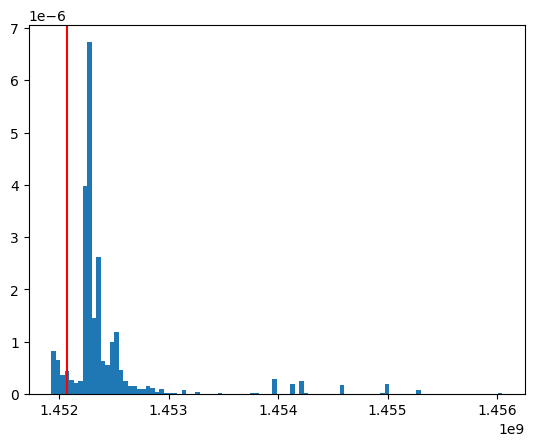

Application_1998350808 [9.60249071e-08]


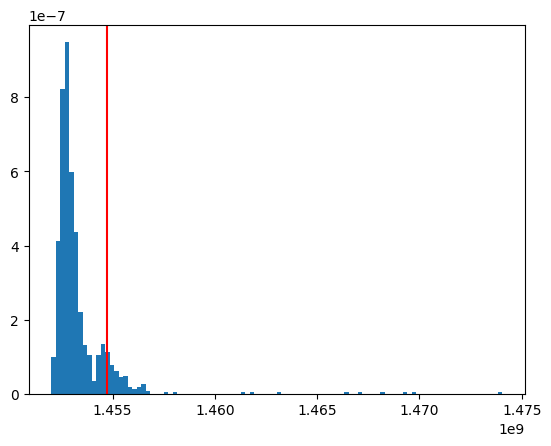

Application_1301009504 [1.26529182e-07]


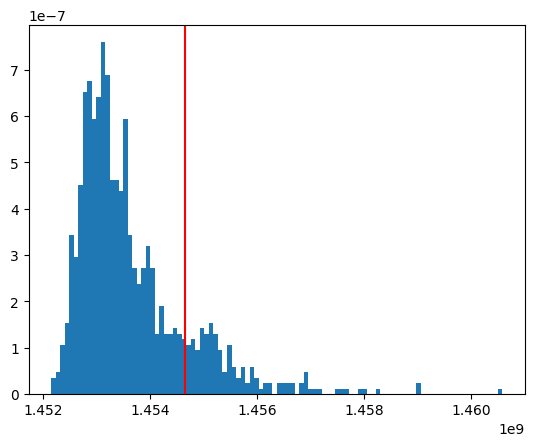

Application_547462088 [8.69421003e-08]


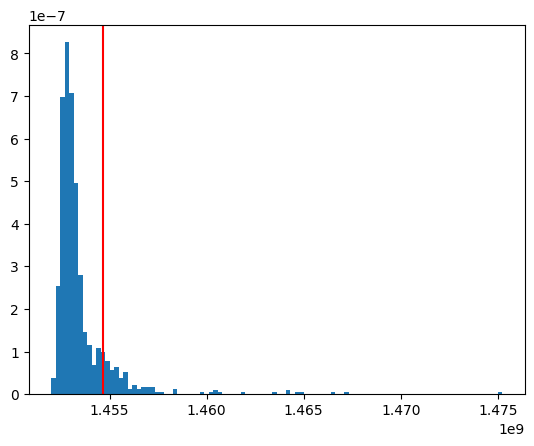

Application_223366470 [1.82520467e-07]


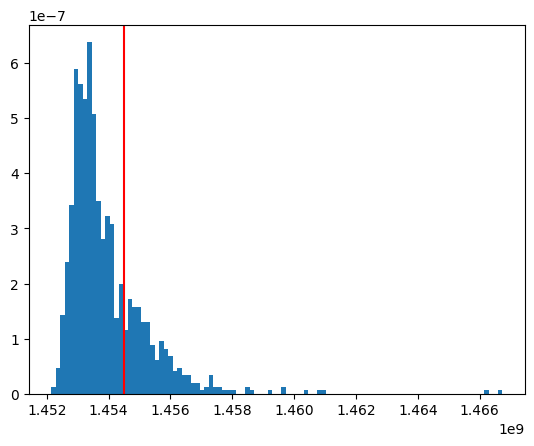

Application_1130151790 [7.90460236e-08]


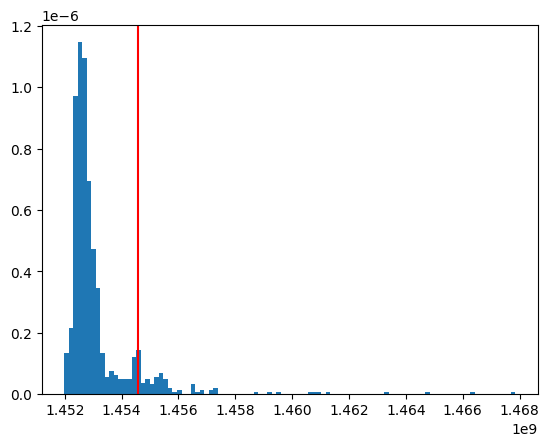

Application_1791187926 [1.04545739e-08]


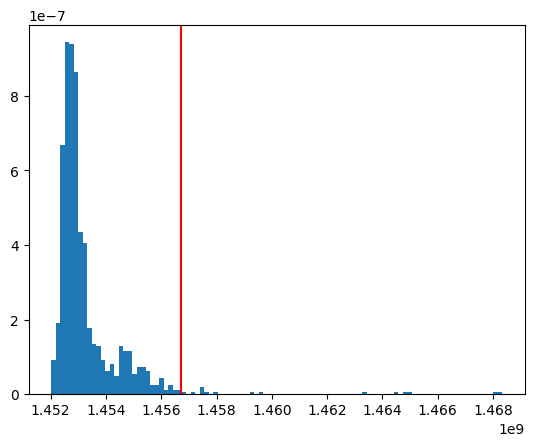

Application_421364849 [4.06879109e-07]


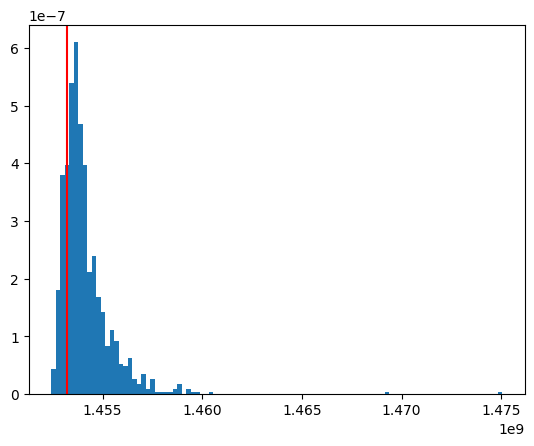

Application_1268592022 [4.62022254e-07]


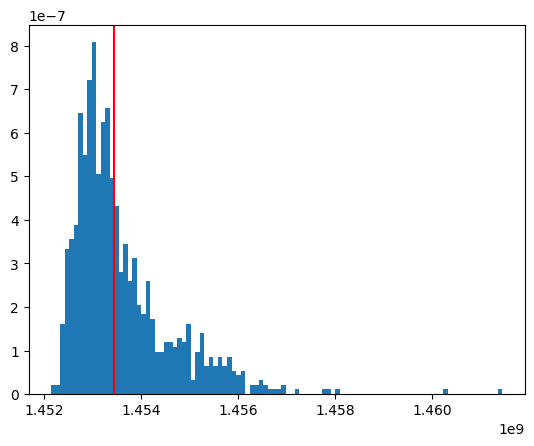

Application_1955353500 [4.62602437e-07]


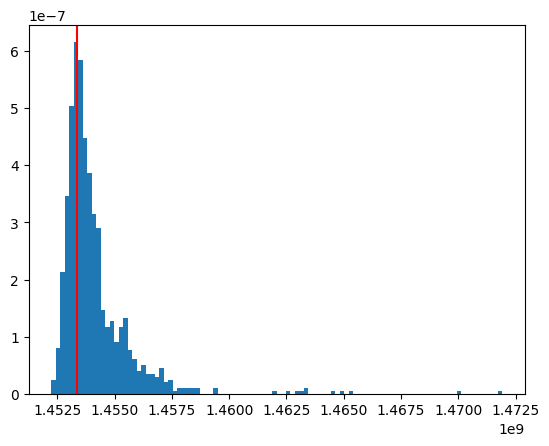

Application_485131054 [5.47807275e-07]


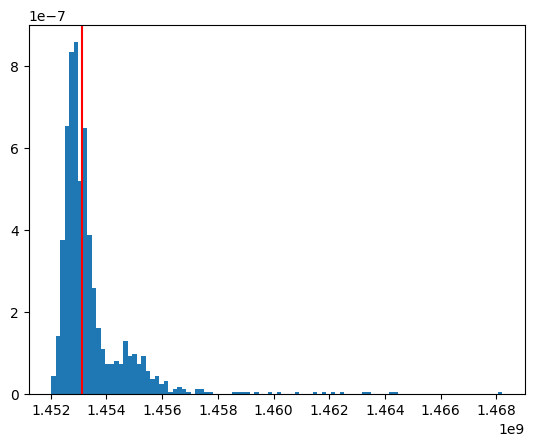

Application_1979402314 [8.25909184e-09]


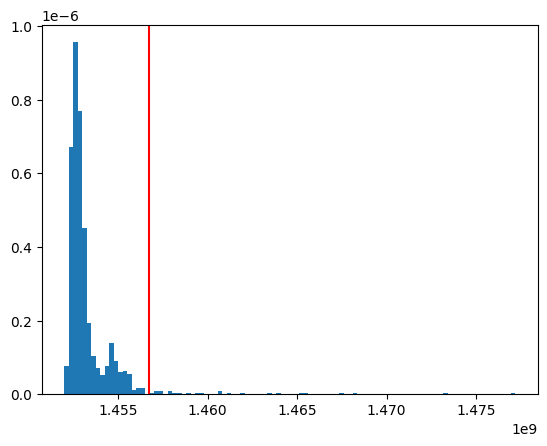

Application_1723028098 [2.33340903e-07]


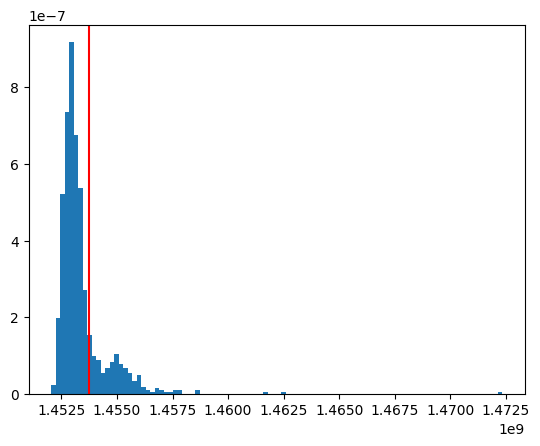

Application_1946236735 [2.62979891e-07]


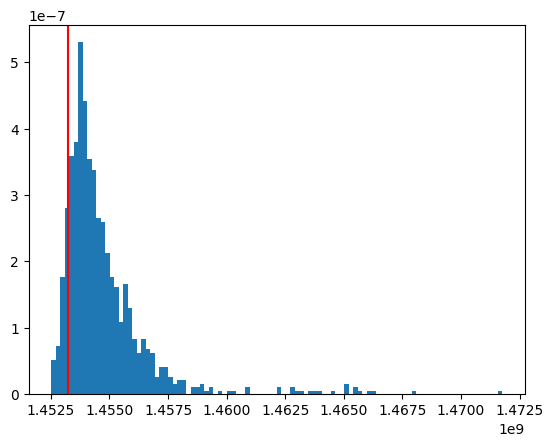

Application_1428307326 [3.50686716e-07]


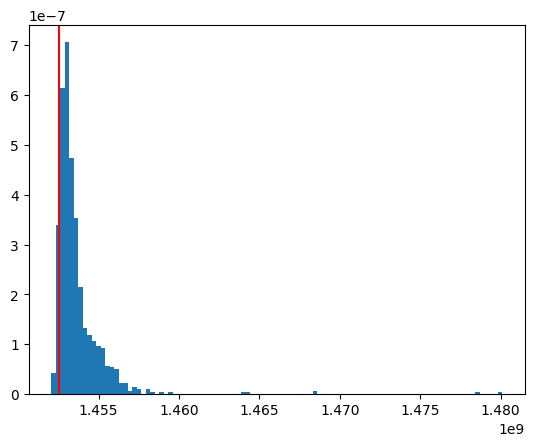

Application_1310063638 [2.75926698e-07]


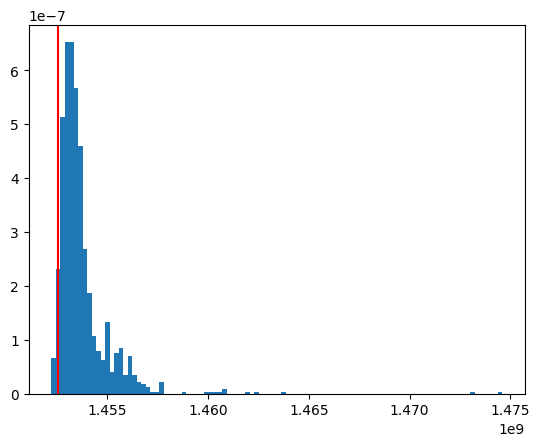

Application_1499869275 [1.75671391e-07]


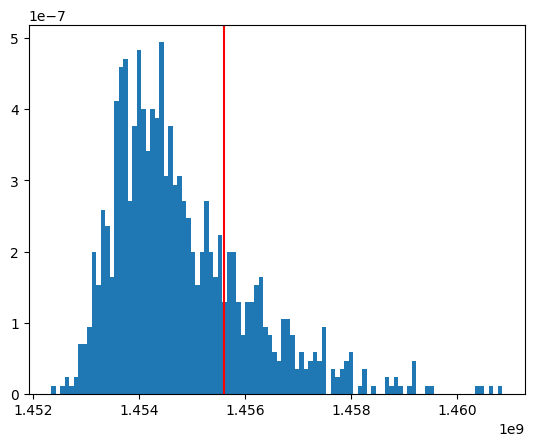

Application_1141114991 [2.40497194e-07]


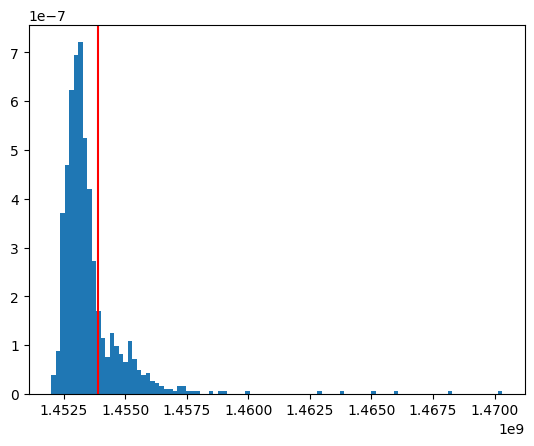

Application_918770224 [1.76314354e-07]


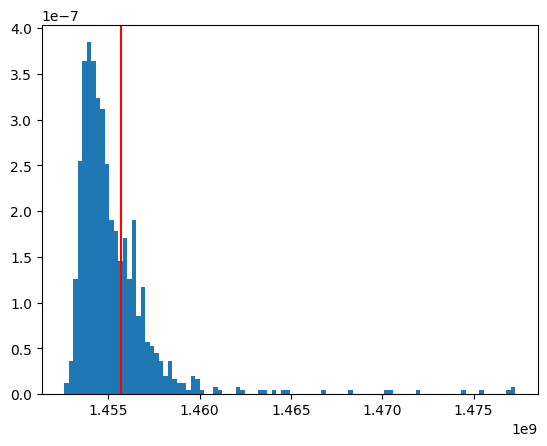

Application_1016816804 [3.42496611e-07]


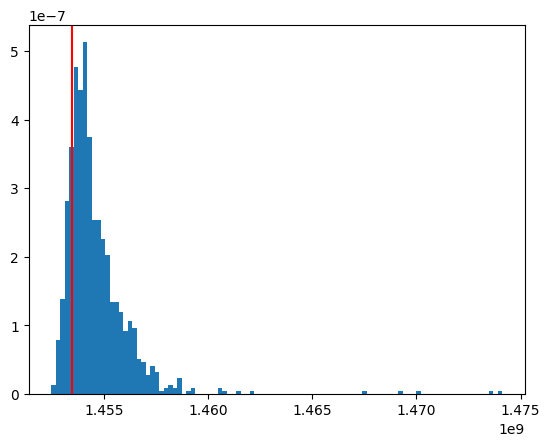

Application_1650844500 [2.50243761e-07]


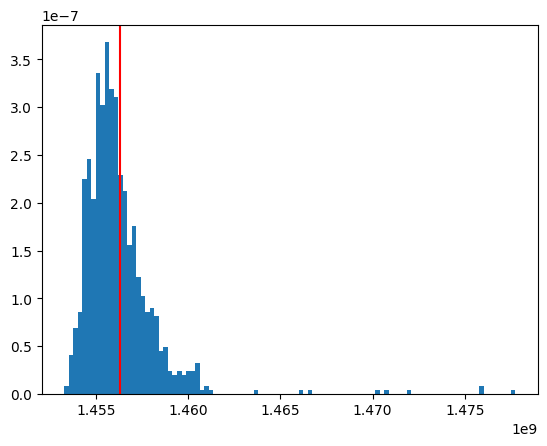

Application_1854801140 [1.71893404e-08]


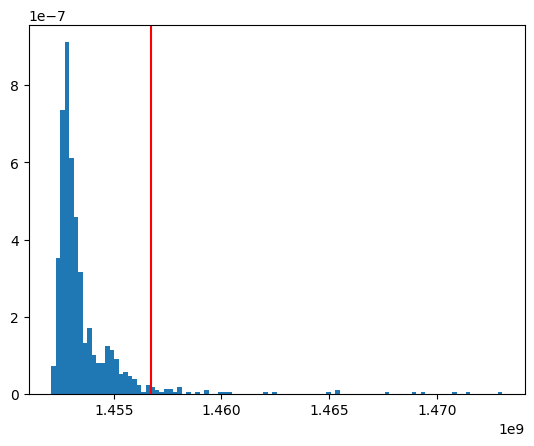

Application_2078020265 [4.60551937e-07]


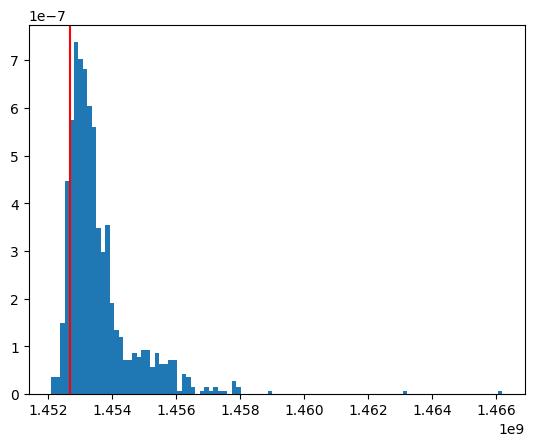

Application_567907480 [4.00521605e-07]


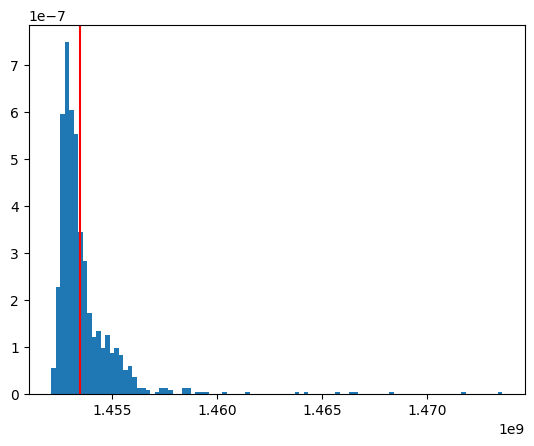

Application_748088065 [1.95205187e-07]


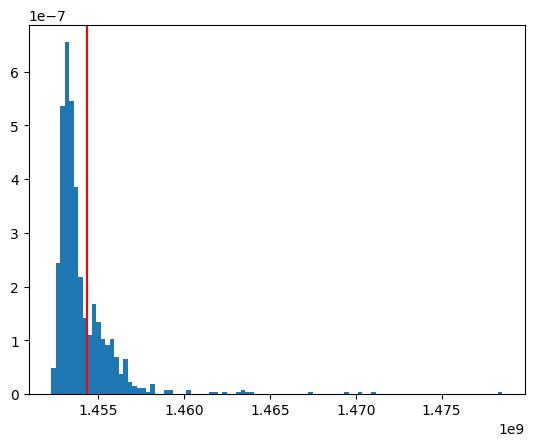

Application_572814439 [3.65173658e-07]


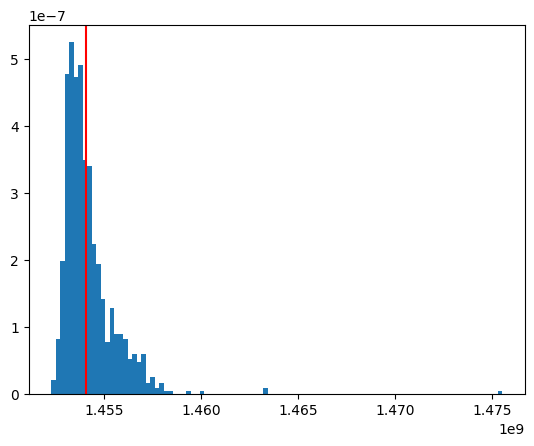

Application_256650628 [3.56375498e-07]


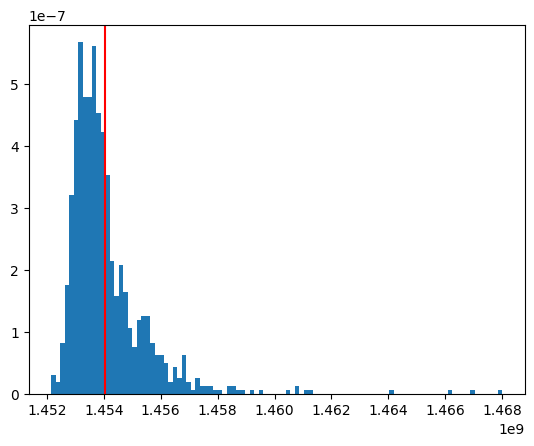

Application_1151254747 [1.66723524e-08]


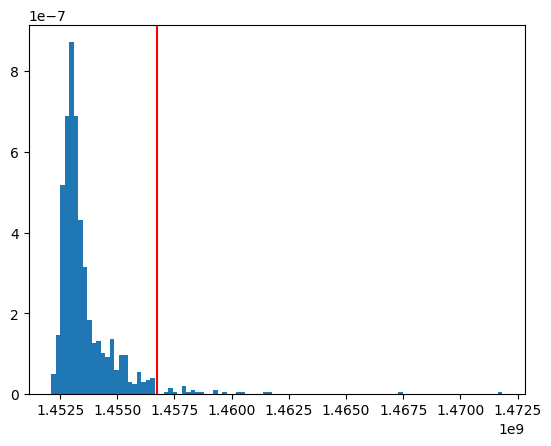

Application_972938507 [2.64994776e-07]


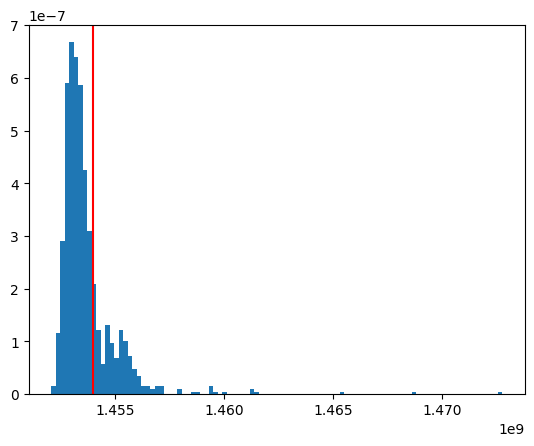

Application_360475310 [1.48322963e-07]


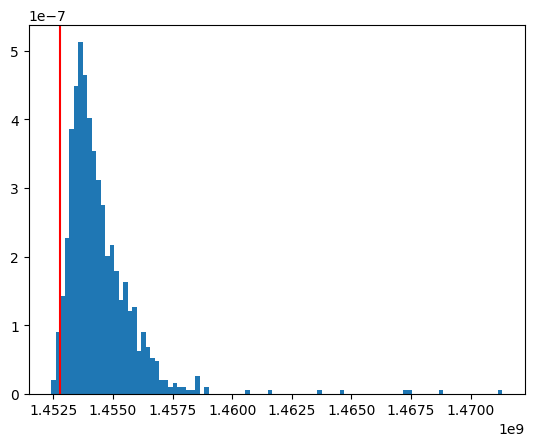

Application_19324985 [5.44081807e-07]


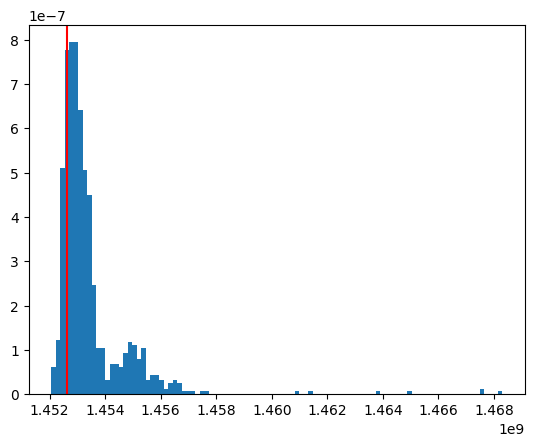

Application_1643165806 [4.95418214e-08]


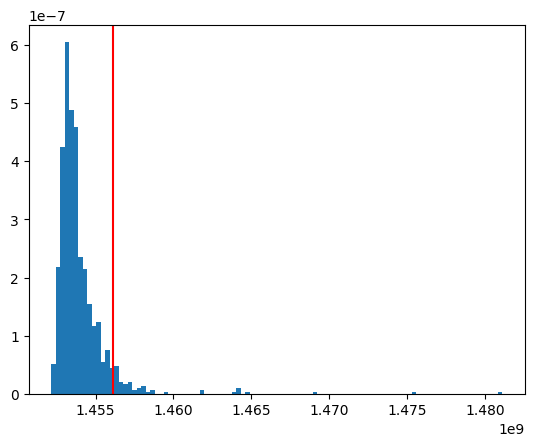

Application_418070482 [6.57861232e-08]


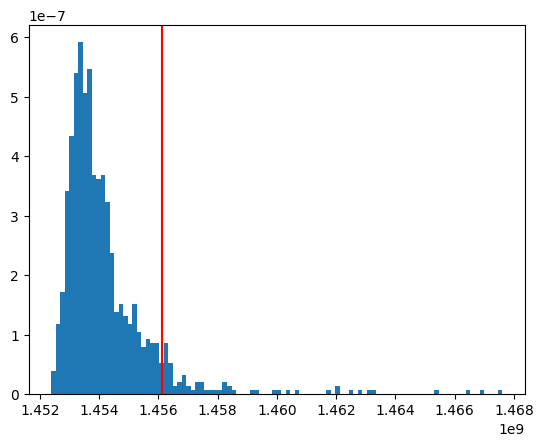

Application_1248349972 [3.33071885e-07]


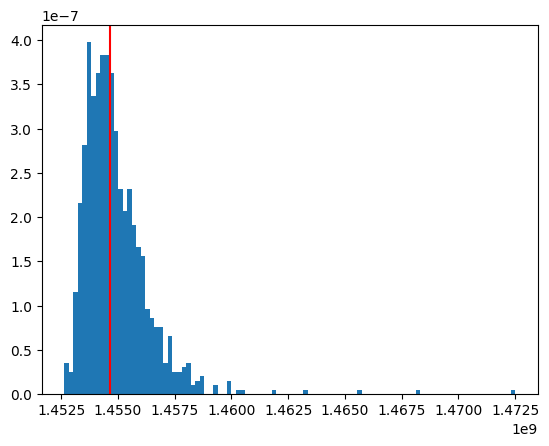

Application_923963777 [6.94213785e-07]


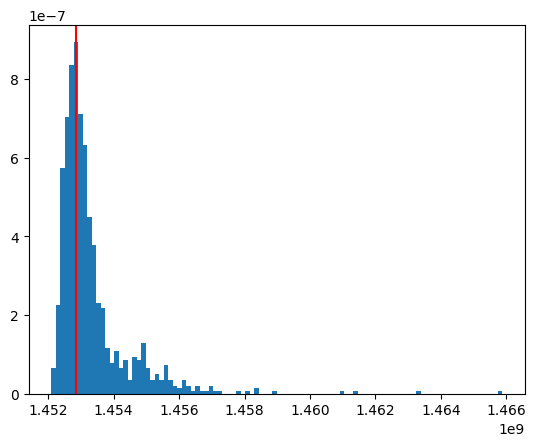

Application_1746133767 [6.24706106e-07]


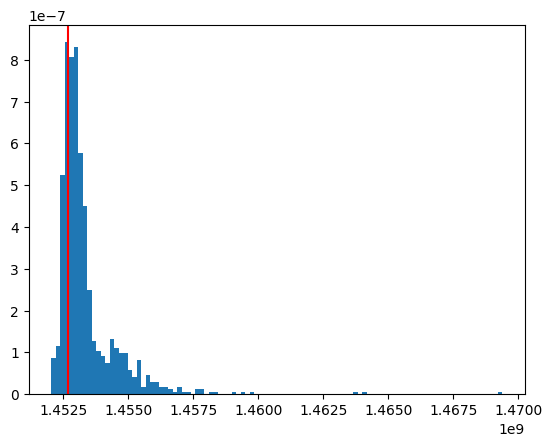

Application_920497952 [8.85543425e-08]


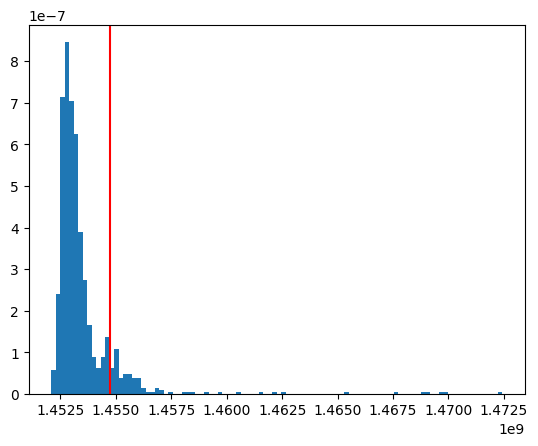

Application_886515262 [4.0822919e-07]


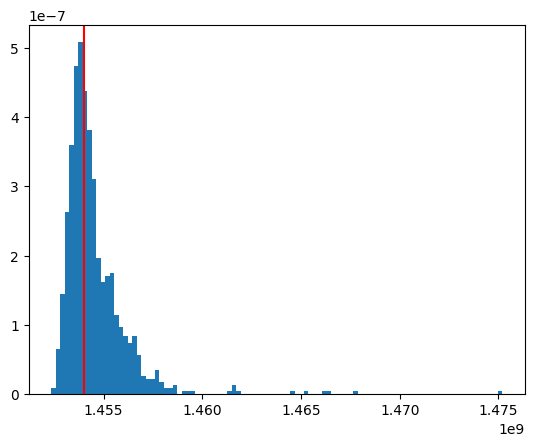

Application_416441220 [7.71020229e-08]


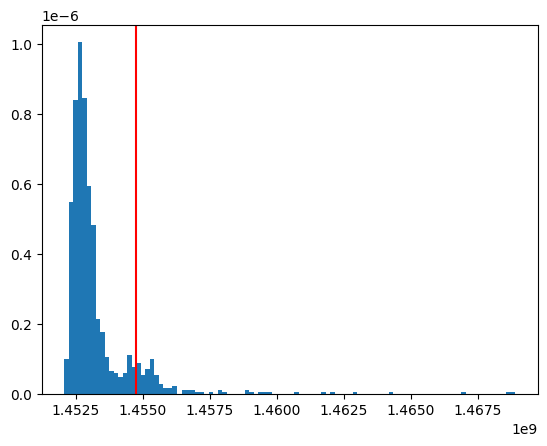

Application_1975617123 [1.71377418e-07]


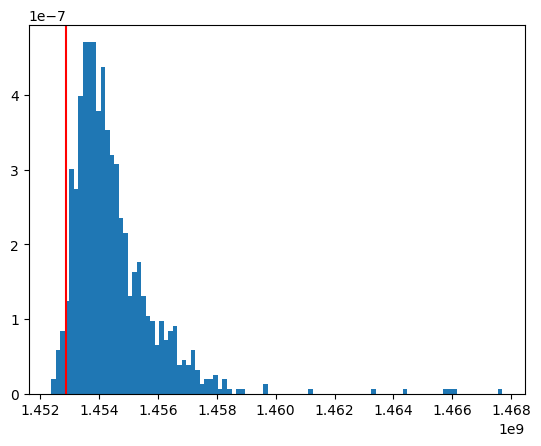

Application_726777197 [9.24186895e-08]


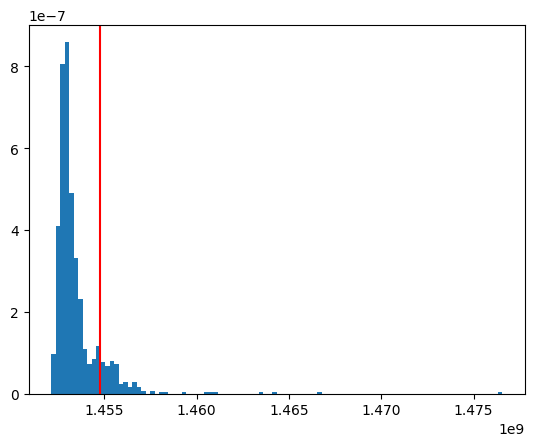

Application_275597794 [4.41802831e-07]


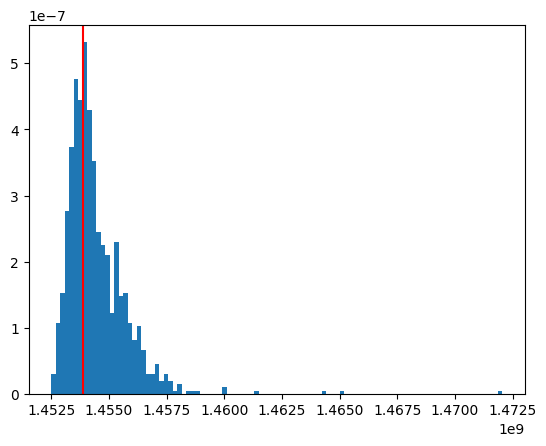

Application_153538723 [9.07287519e-08]


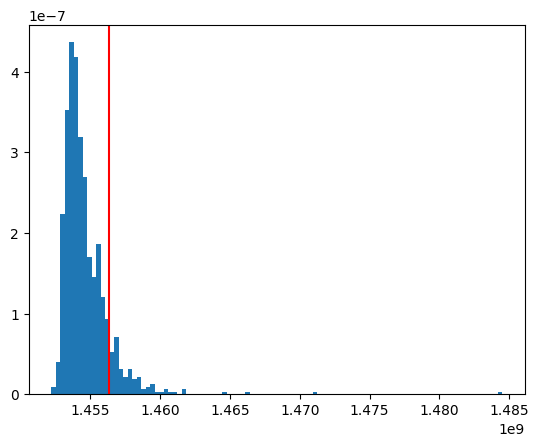

Application_368205428 [3.97296649e-07]


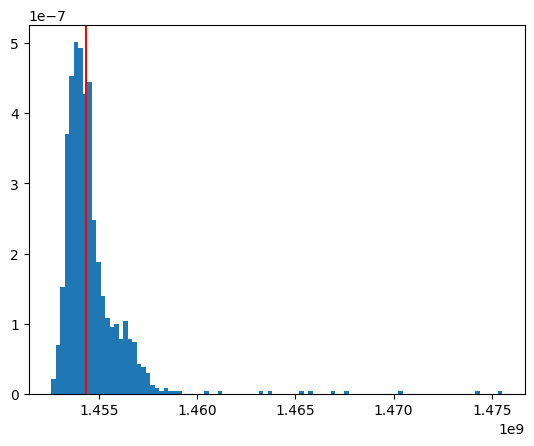

Application_923808413 [3.82319364e-07]


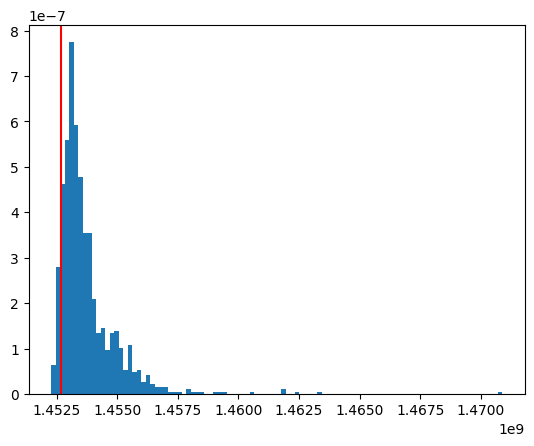

Application_1933550065 [1.96567413e-08]


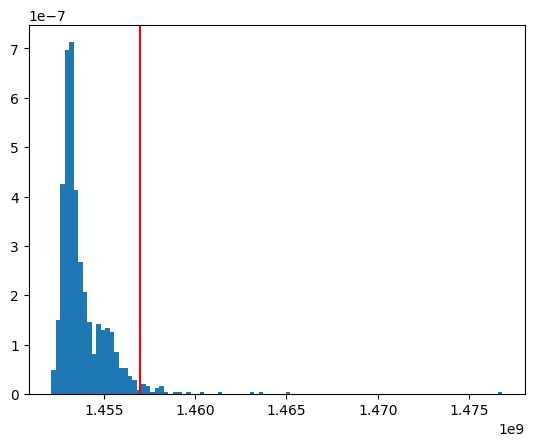

Application_854409161 [8.6732953e-08]


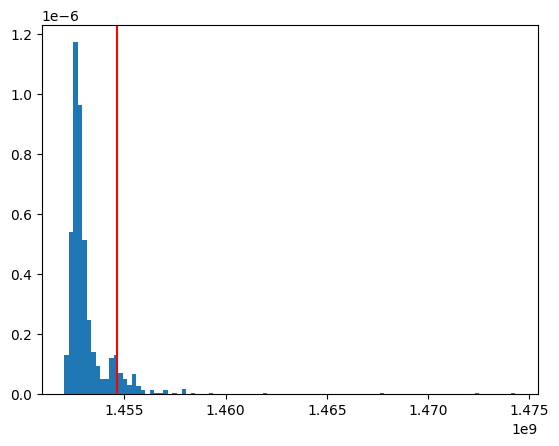

Application_346636726 [4.07871746e-07]


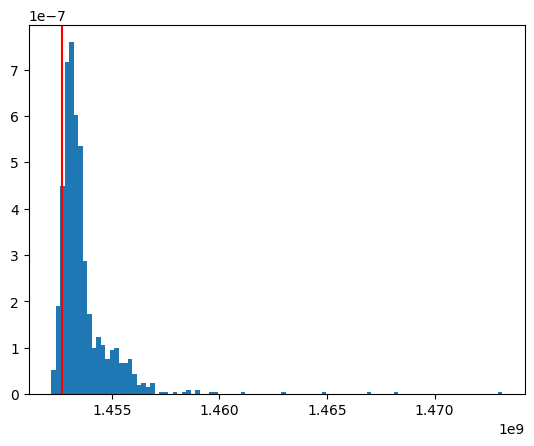

Application_1420077883 [2.25362497e-07]


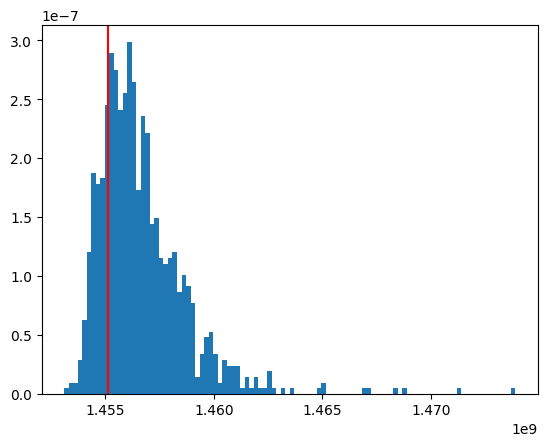

Application_236257423 [9.07850914e-08]


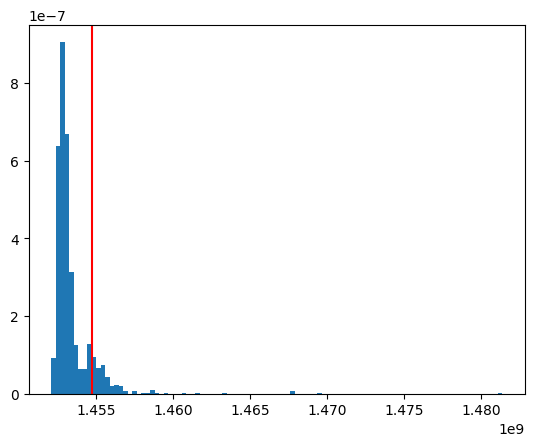

Application_1892186837 [3.02353135e-09]


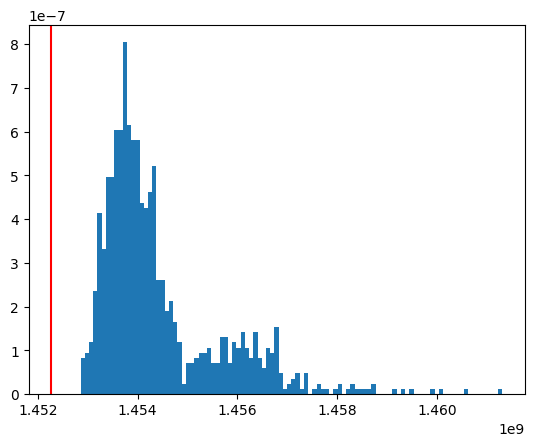

Application_438518989 [1.05917069e-07]


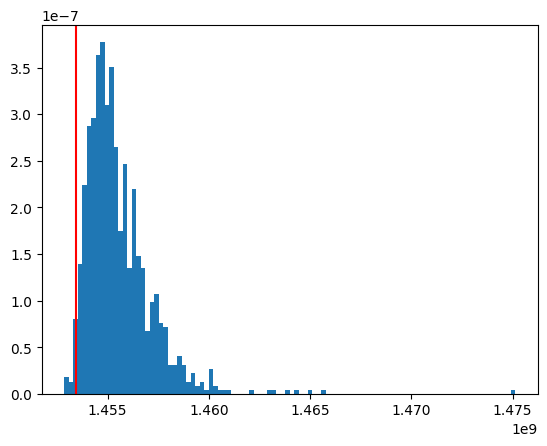

Application_788421650 [1.05845642e-08]


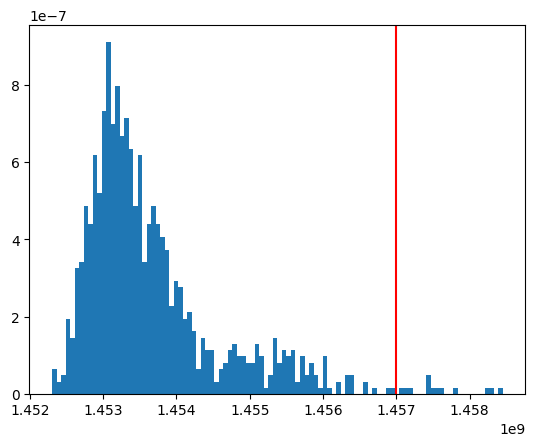

Application_1447851462 [3.84753111e-07]


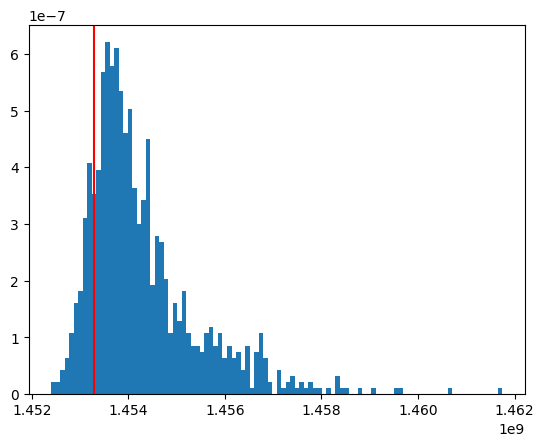

Application_664267418 [3.19800961e-07]


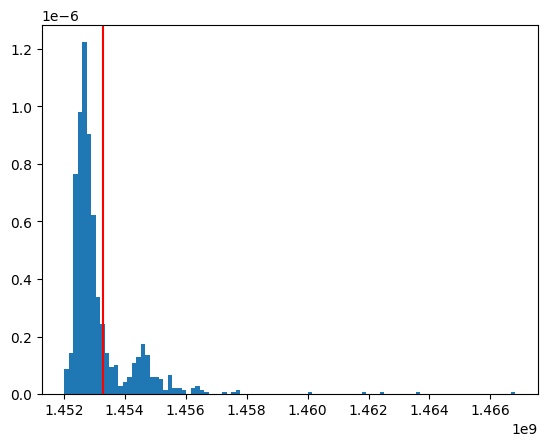

Application_2118101879 [5.29658512e-07]


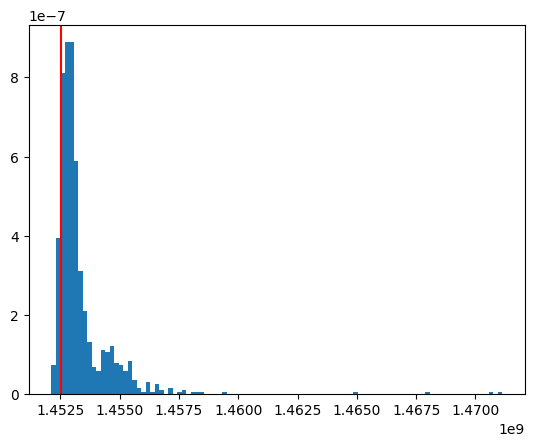

Application_1259601023 [4.65688477e-08]


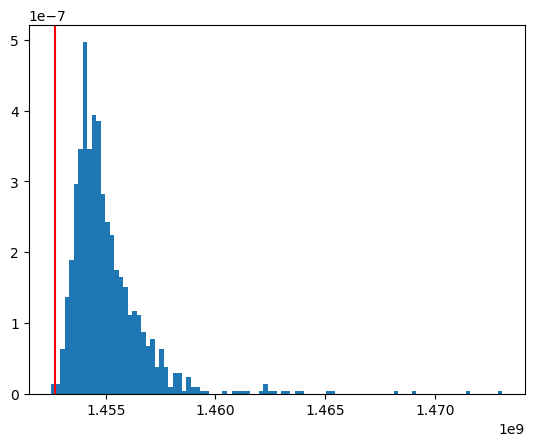

Application_969058358 [2.72883345e-07]


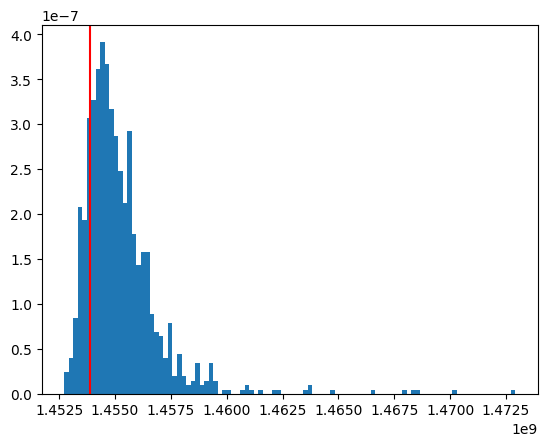

Application_29490720 [4.43739337e-07]


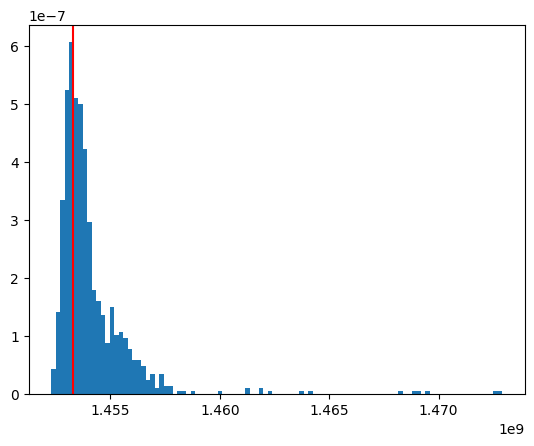

Application_193978070 [2.02168348e-07]


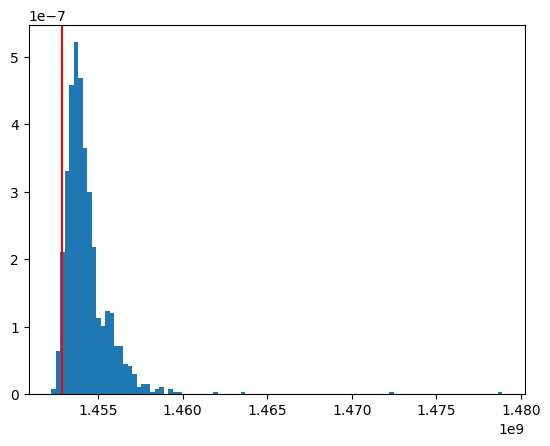

Application_1916415976 [1.98417444e-07]


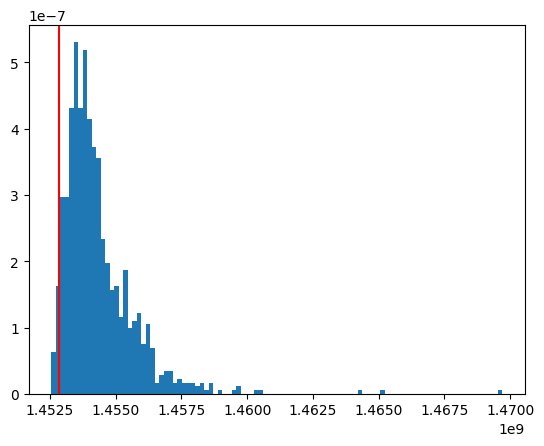

Application_1267839101 [2.2163037e-07]


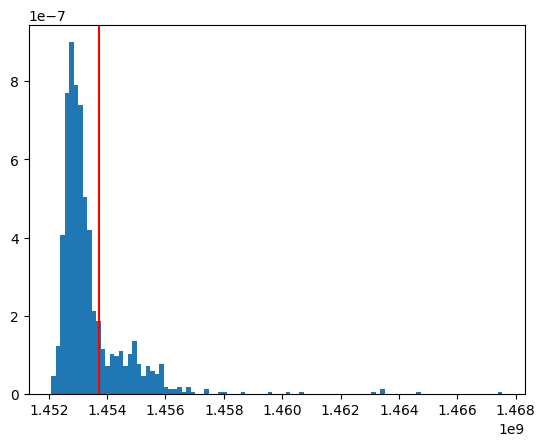

Application_1101248362 [1.60025408e-07]


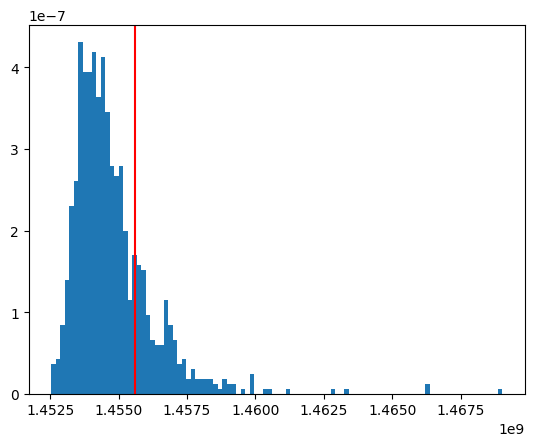

Application_1800870760 [5.18541048e-07]


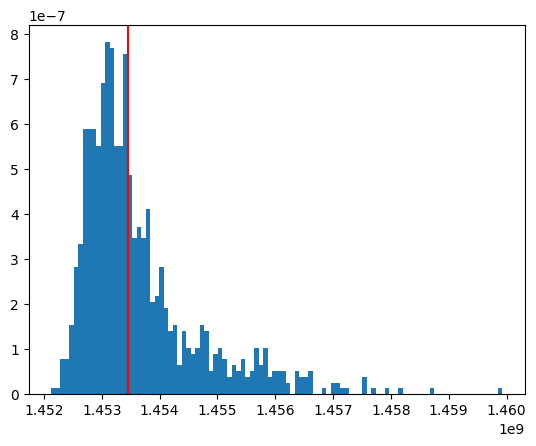

Application_1484851617 [1.04488245e-07]


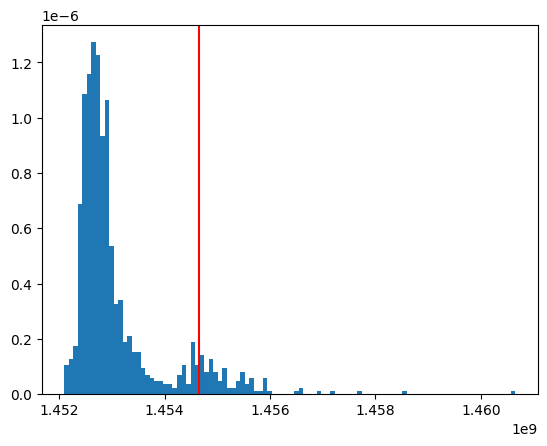

Application_402039661 [8.49914698e-08]


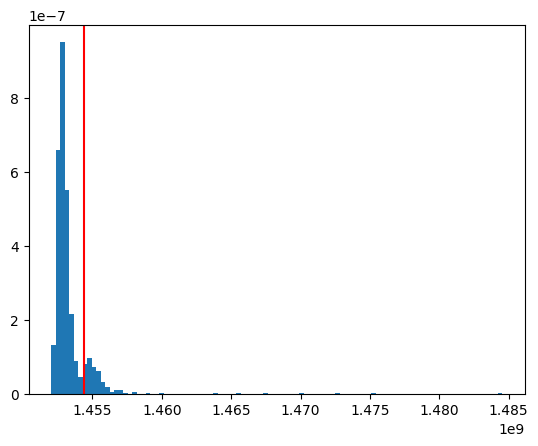

Application_1494501575 [3.44602005e-07]


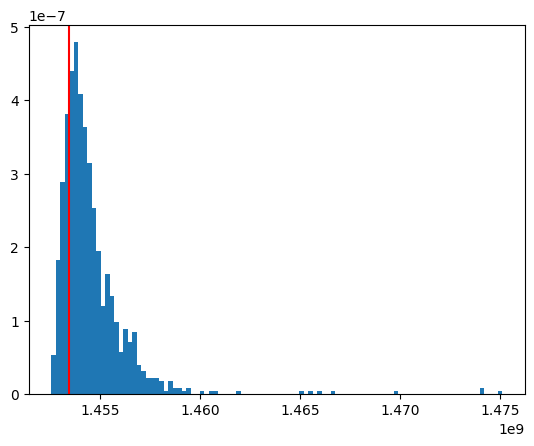

Application_1675166178 [2.28882924e-07]


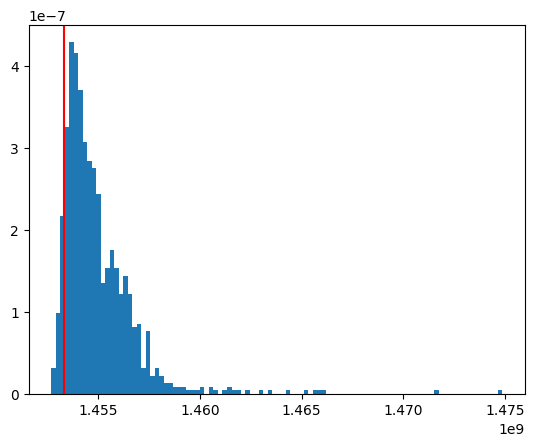

Application_297421946 [4.41459456e-07]


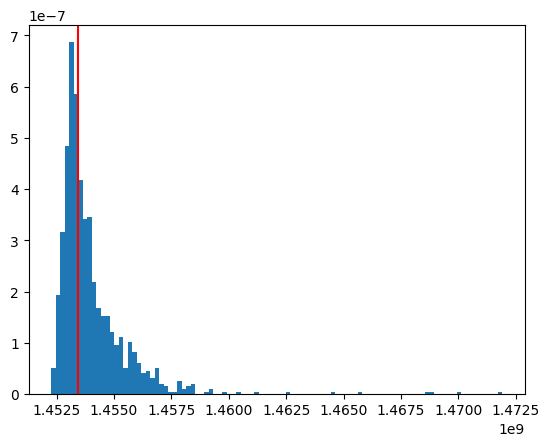

Application_920229339 [2.31326832e-07]


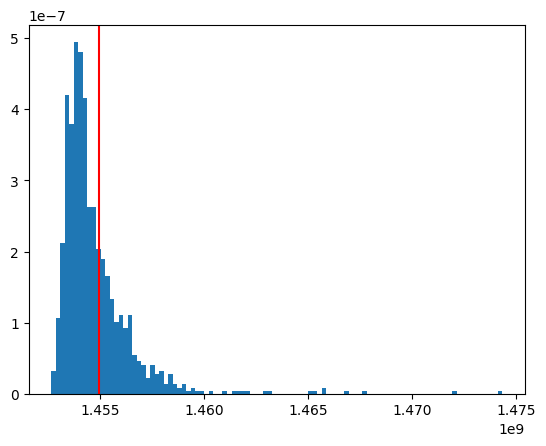

Application_562322973 [6.17357623e-07]


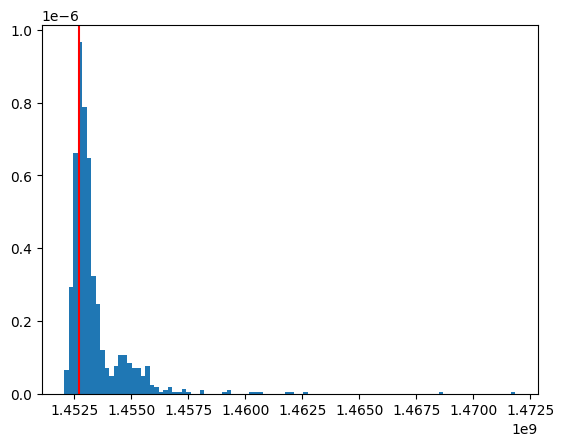

Application_722397148 [4.91804169e-07]


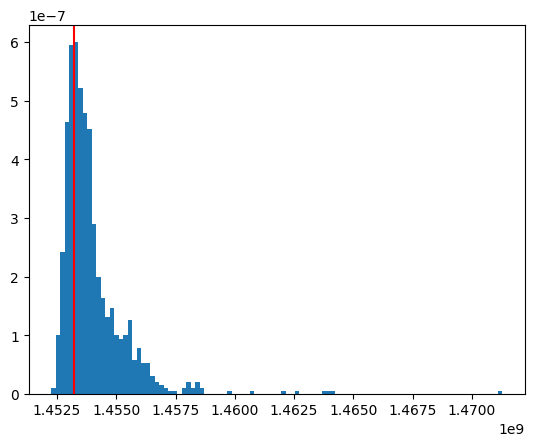

Application_1645236489 [7.89699031e-08]


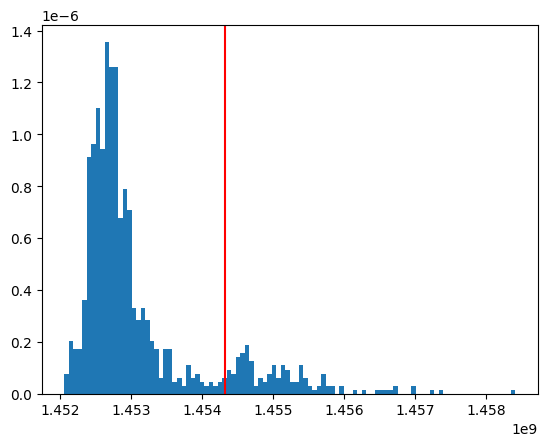

Application_1868808301 [1.21947423e-07]


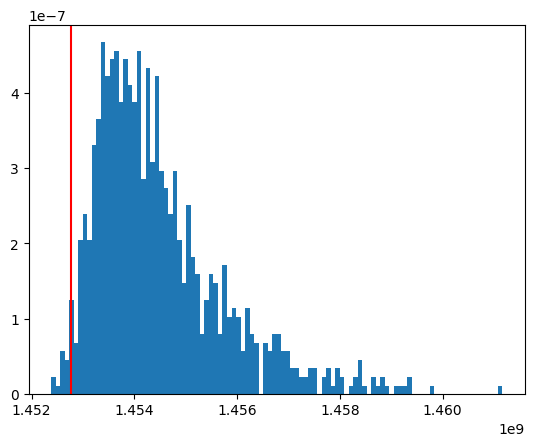

Application_1702060008 [2.06935335e-08]


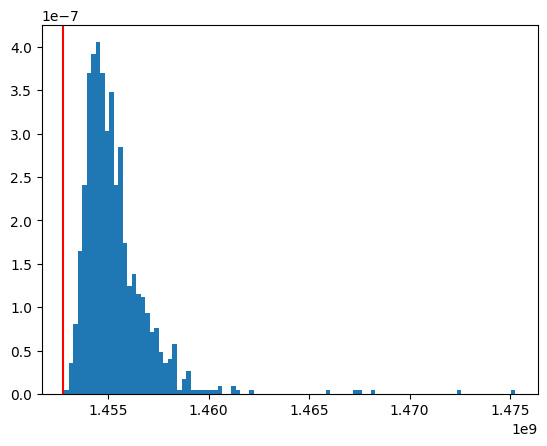

Application_2059945768 [4.34108784e-07]


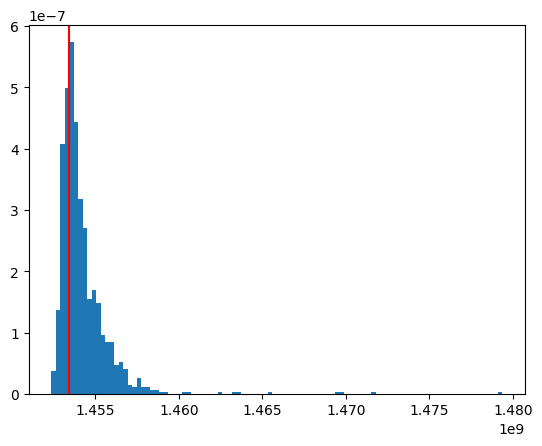

Application_2115613475 [4.20154524e-09]


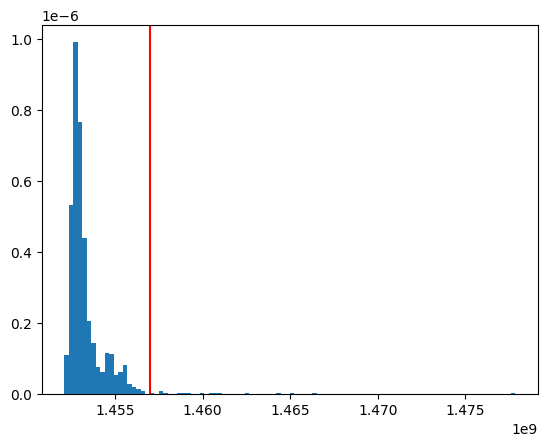

Application_409724822 [8.93837395e-08]


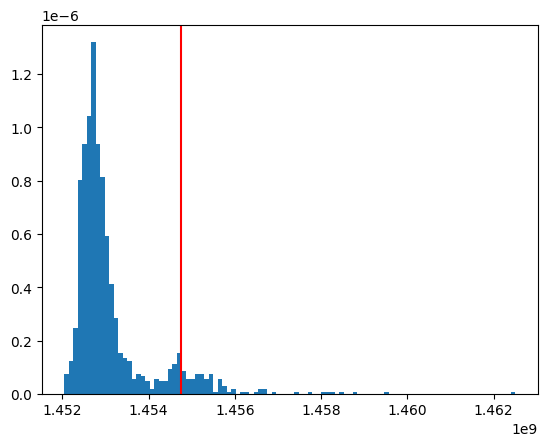

Application_788960916 [7.73440388e-08]


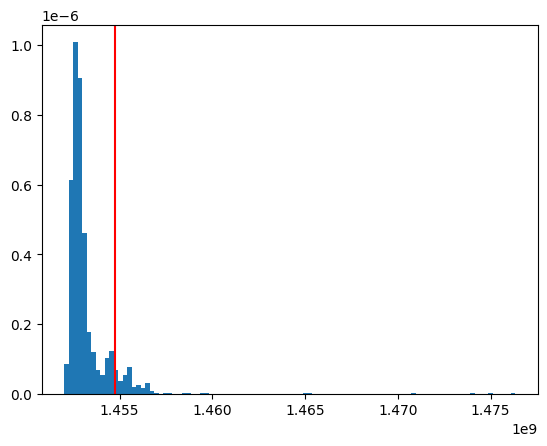

Application_1807951250 [5.49837615e-07]


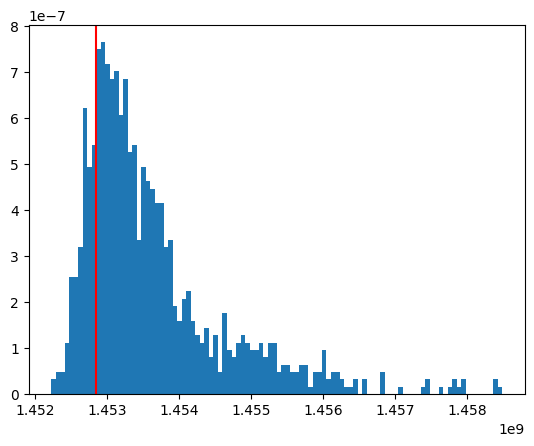

Application_944177310 [8.67094087e-08]


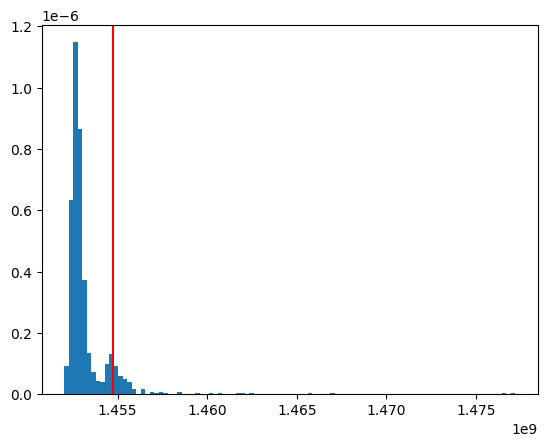

Application_1277100580 [1.6983742e-07]


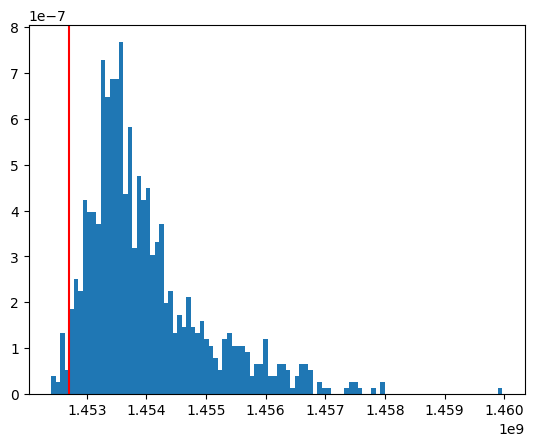

Application_1943199357 [4.95340354e-07]


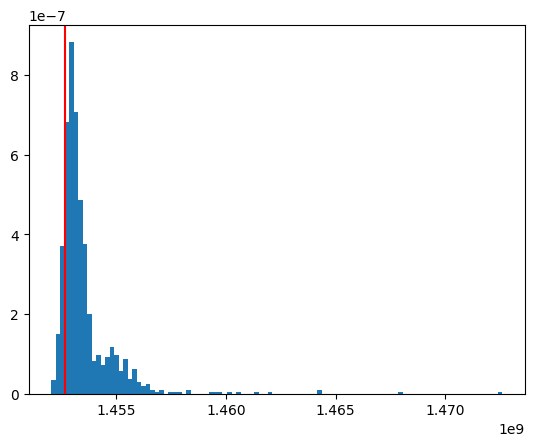

Application_1462709587 [4.40098964e-07]


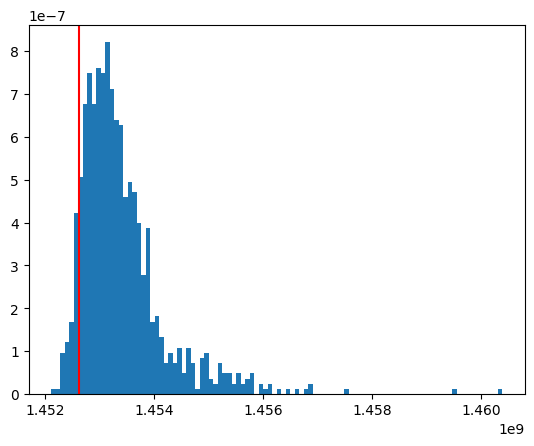

Application_1911804233 [9.5263807e-08]


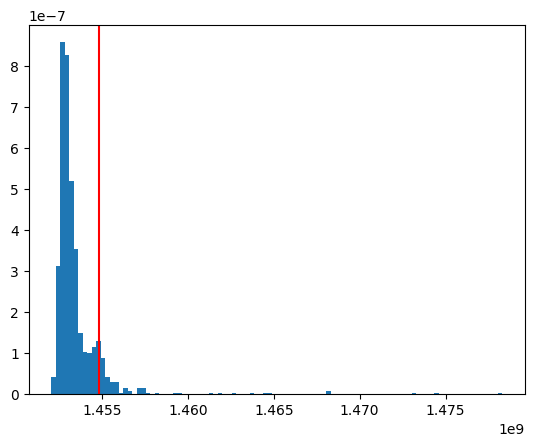

Application_1195396325 [3.81383368e-08]


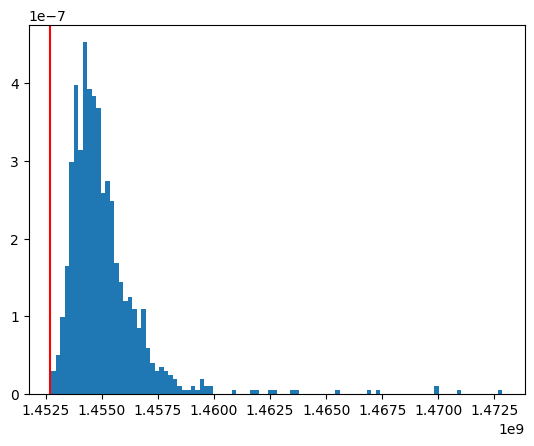

Application_1274070913 [7.74255378e-08]


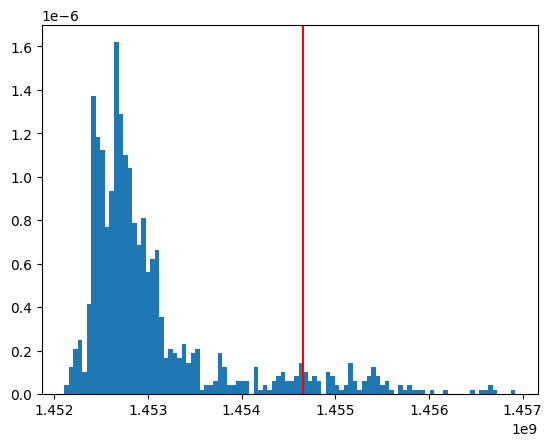

Application_503966930 [4.03020608e-07]


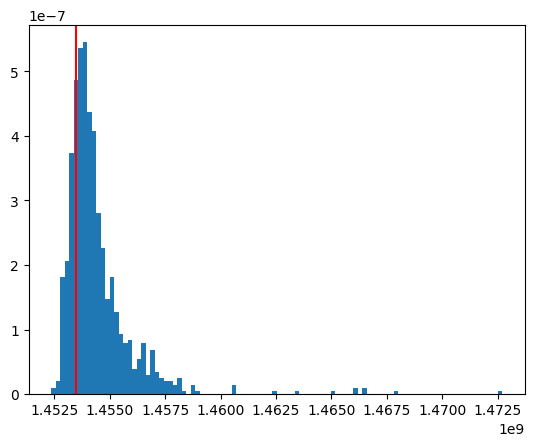

Application_1362293013 [1.82186749e-07]


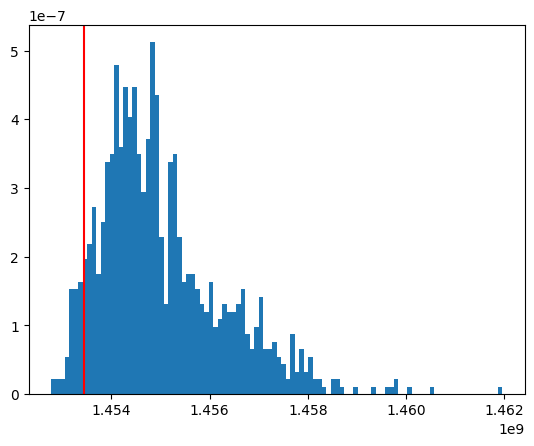

Application_866541745 [5.82834647e-09]


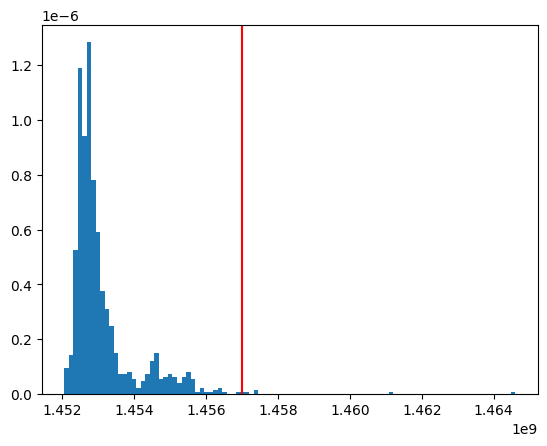

Application_200000547 [2.6532103e-07]


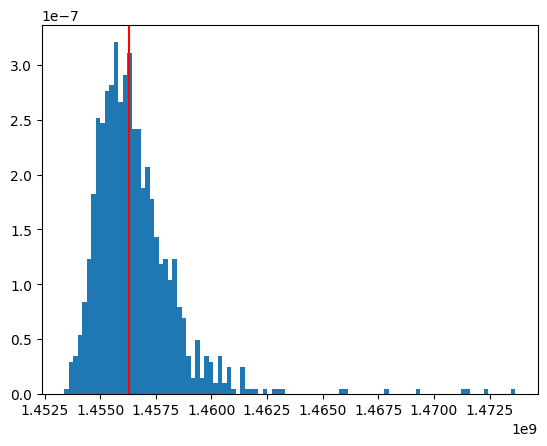

Application_948906324 [6.30085956e-07]


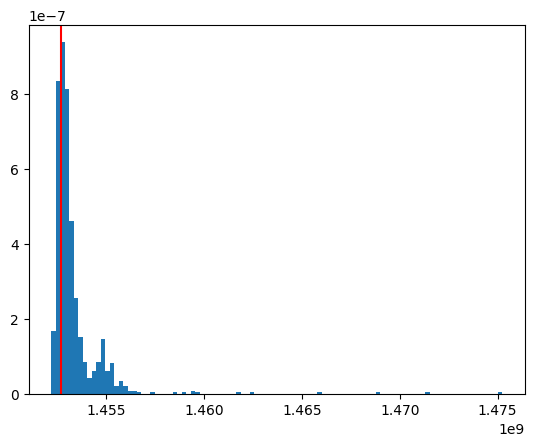

Application_1172125329 [7.03482011e-07]


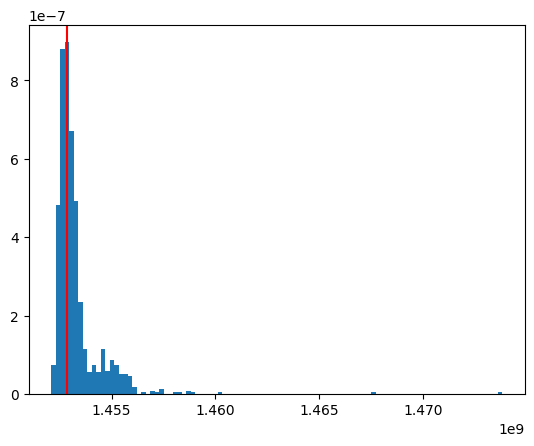

Application_1931792282 [7.93815256e-07]


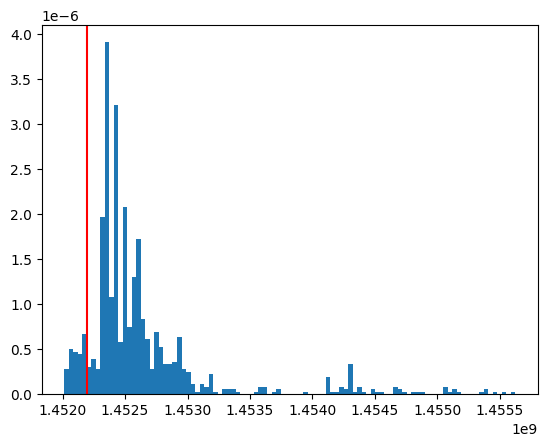

Application_275338795 [6.2471333e-07]


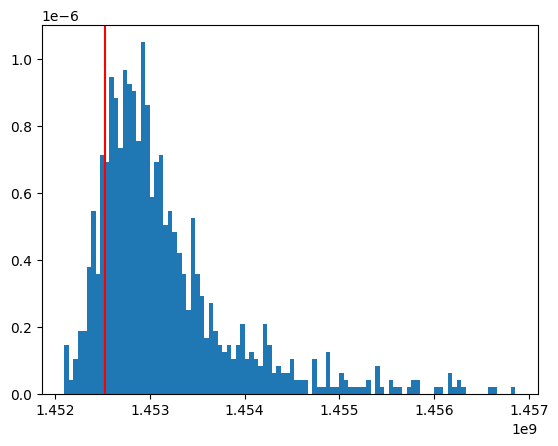

Application_243636886 [7.58347517e-08]


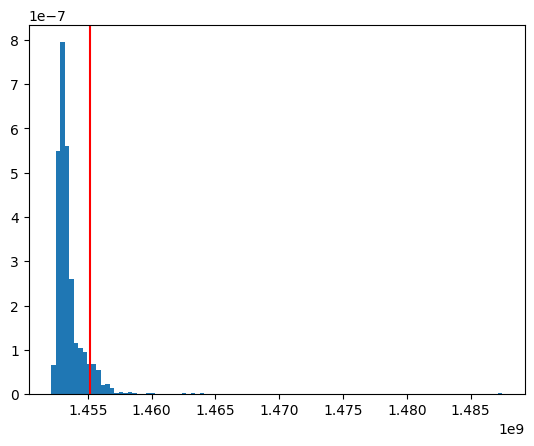

Application_1838732360 [1.07736938e-07]


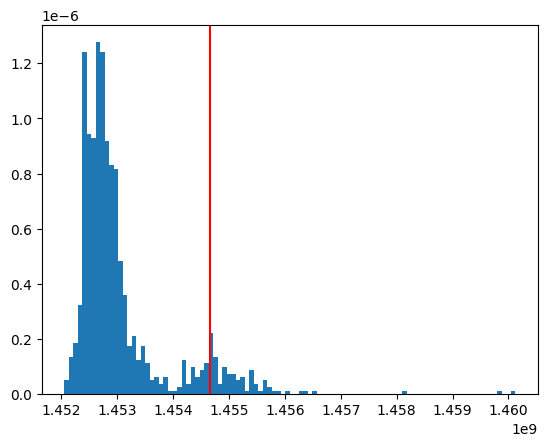

Application_125495187 [5.11605178e-07]


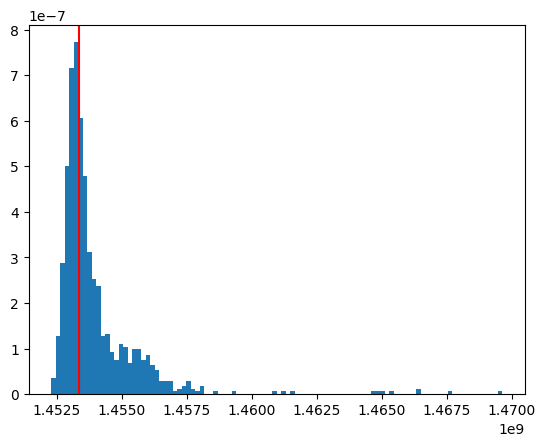

Application_2006366791 [1.72162408e-07]


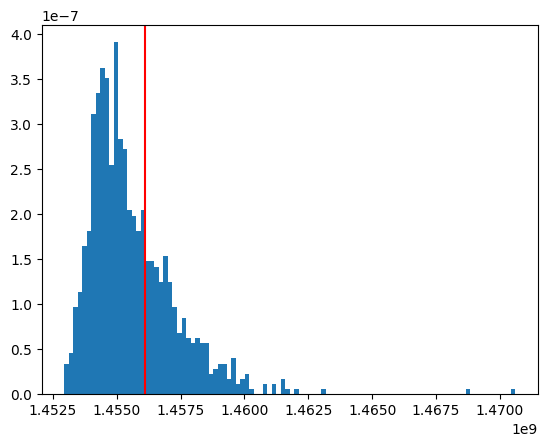

Application_1930449097 [8.95866736e-08]


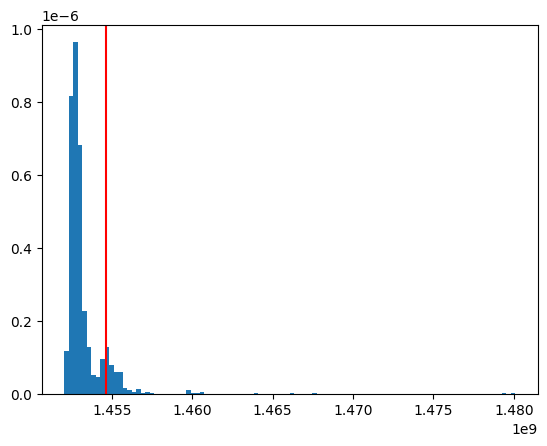

Application_1640008006 [2.41497926e-07]


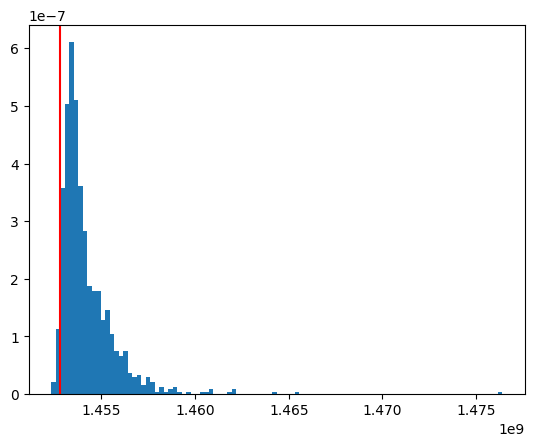

Application_1281827491 [2.01602865e-07]


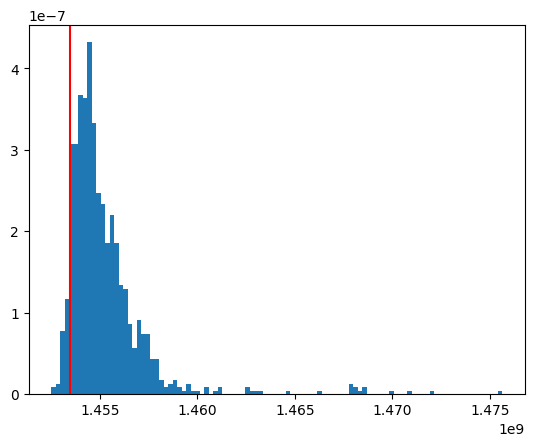

Application_1854554571 [1.94520593e-07]


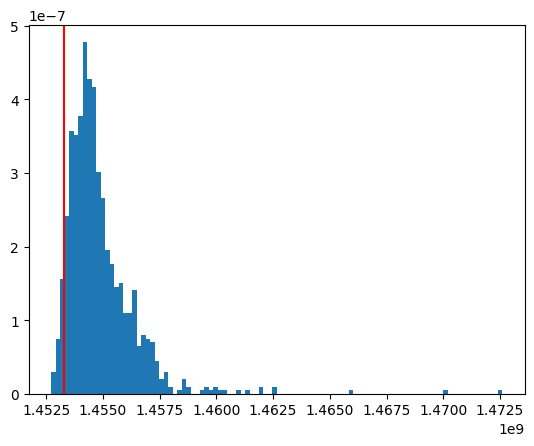

Application_13372270 [5.62700186e-07]


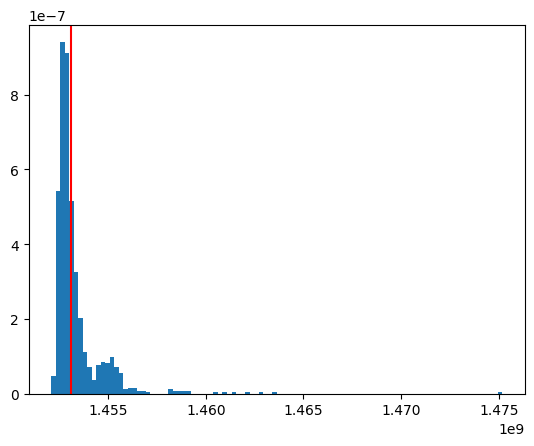

Application_1492351094 [4.09505079e-07]


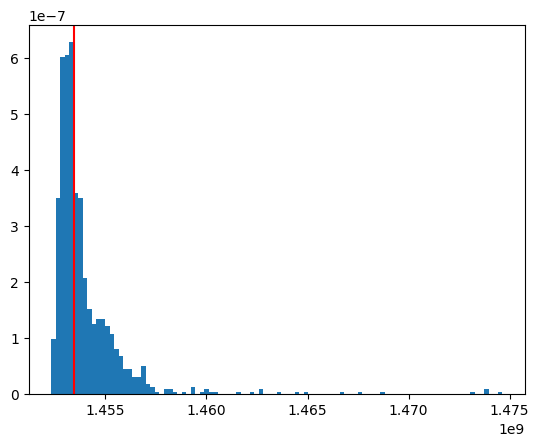

Application_675506291 [5.54417169e-07]


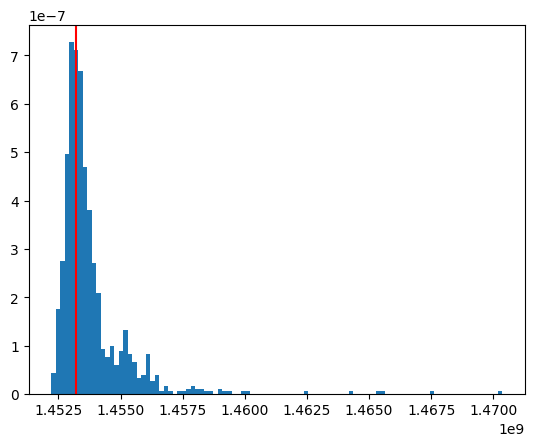

Application_898874076 [1.01446638e-08]


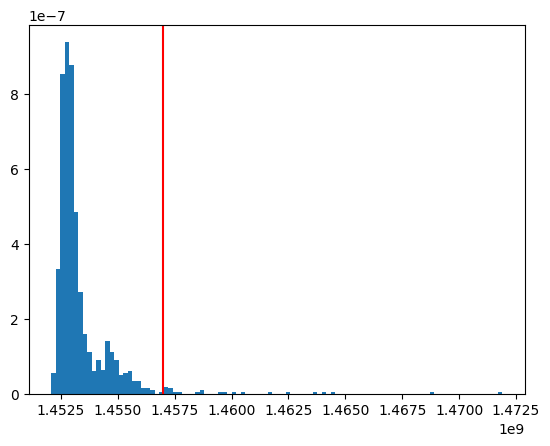

Application_1251541081 [1.66141391e-06]


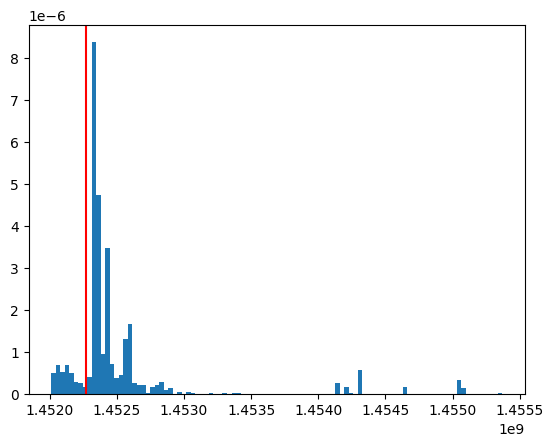

Application_1853222107 [5.16967233e-07]


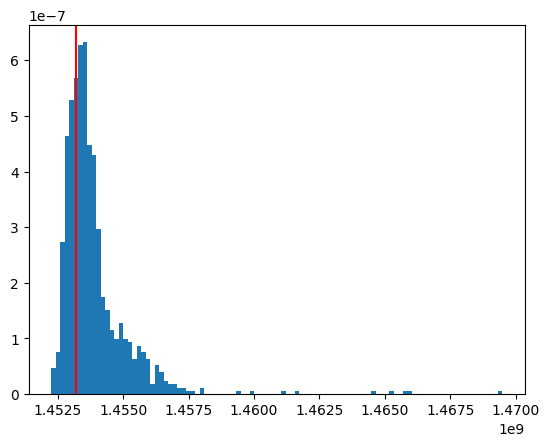

Application_1629784556 [4.03202969e-07]


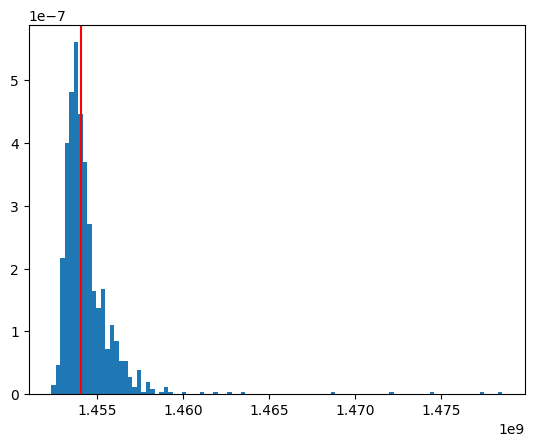

Application_190984886 [6.3759862e-07]


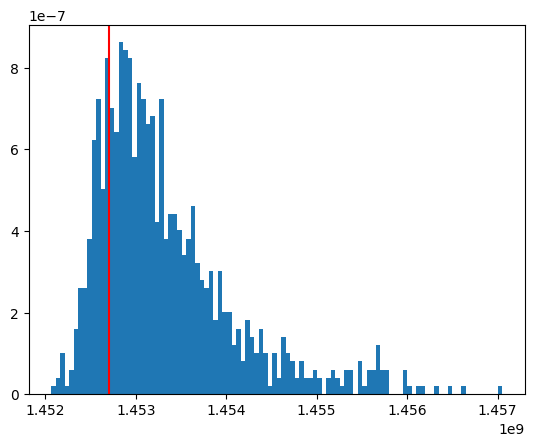

Application_911291915 [8.48635169e-08]


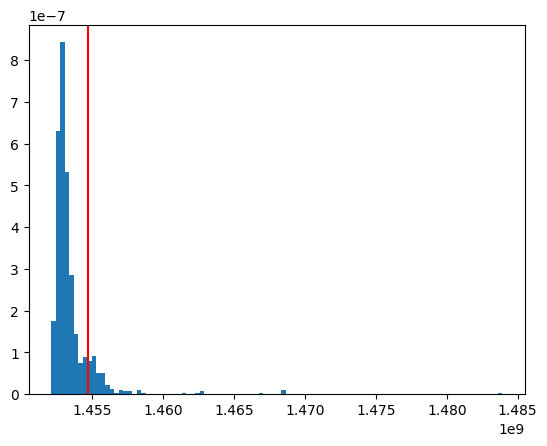

Application_1179942266 [3.672964e-07]


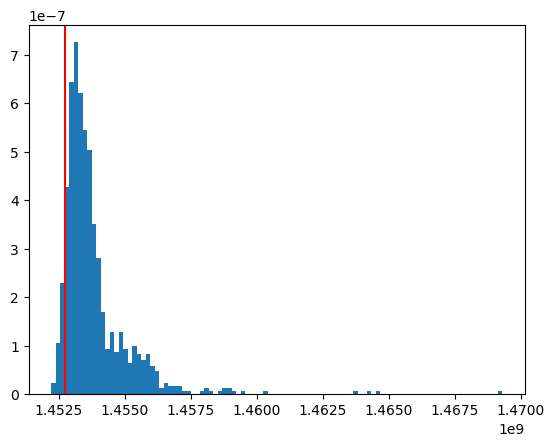

Application_1807570830 [3.57611193e-07]


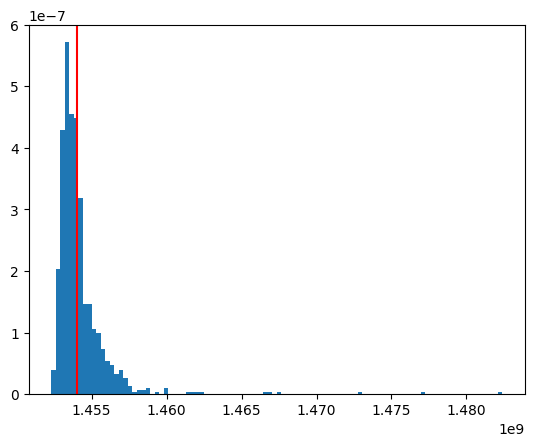

Application_88479581 [2.15964966e-07]


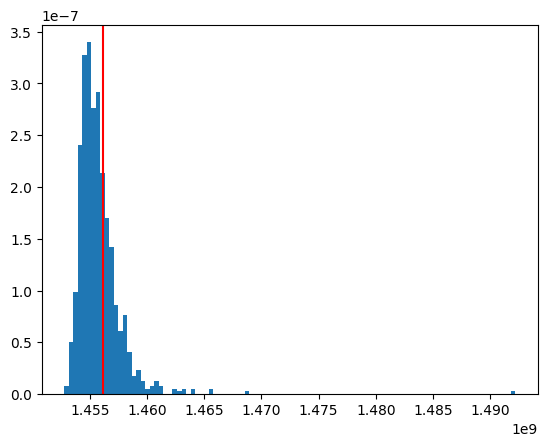

Application_804815556 [4.74467751e-07]


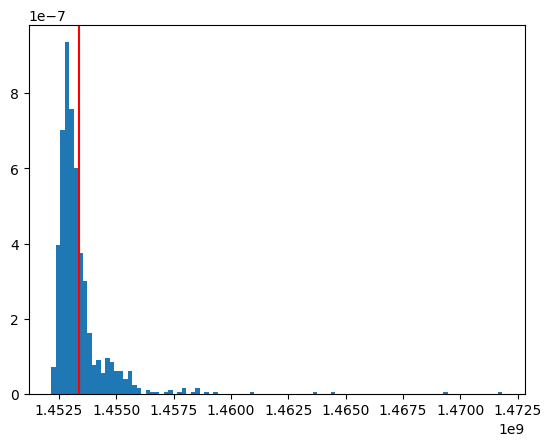

Application_1669670154 [7.2225942e-07]


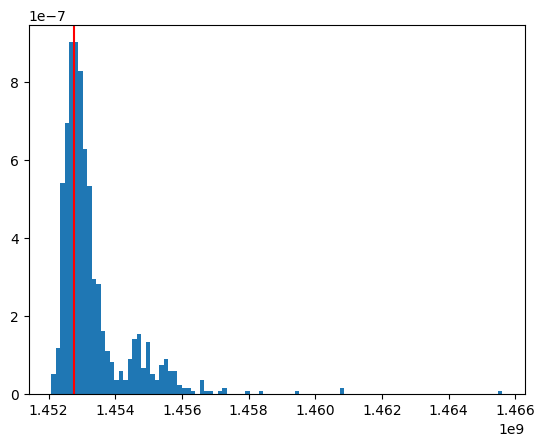

Application_1231177181 [2.34272105e-07]


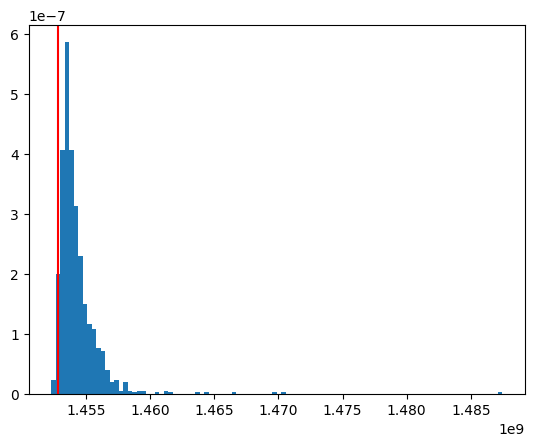

Application_989064530 [4.2287937e-07]


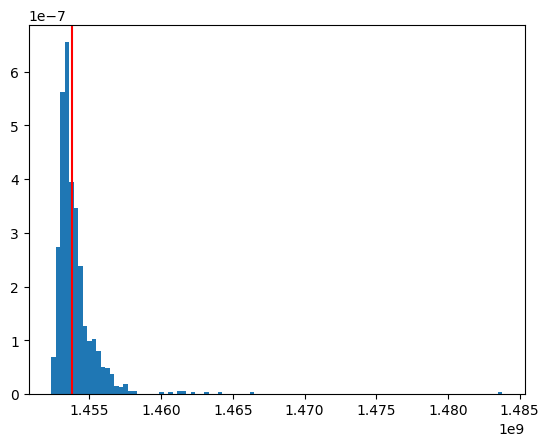

Application_2063036518 [1.30075857e-07]


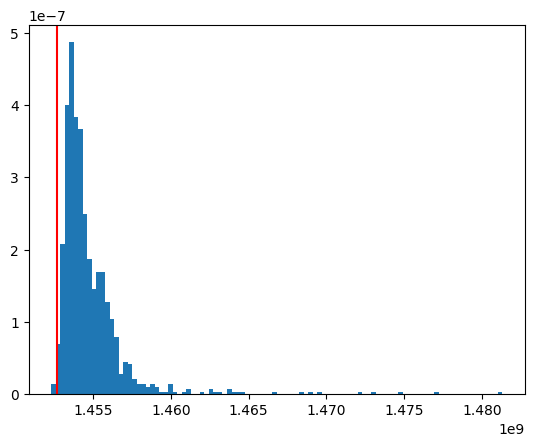

Application_1174199914 [4.90198917e-07]


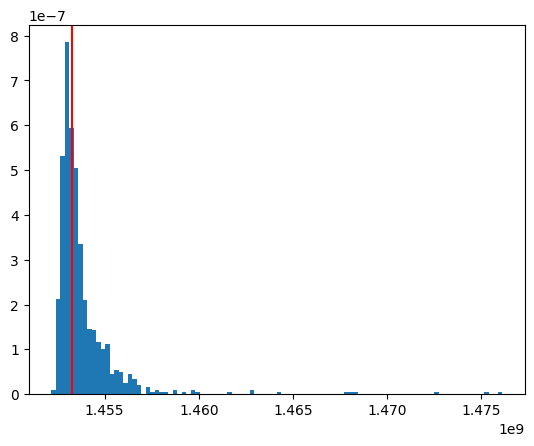

Application_1891076145 [6.58830957e-08]


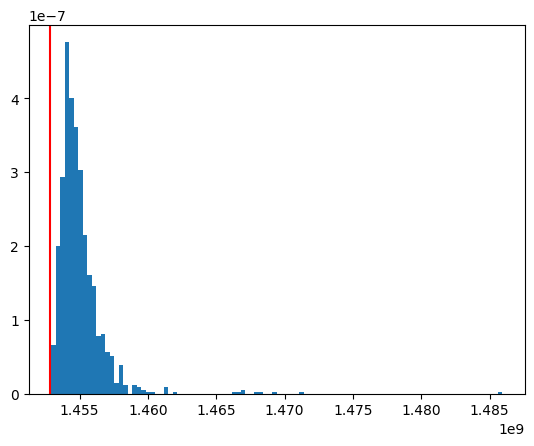

Application_1226577675 [5.96796911e-07]


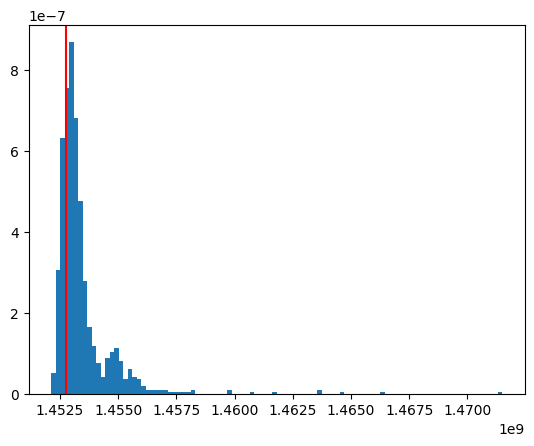

Application_987213908 [2.73446778e-07]


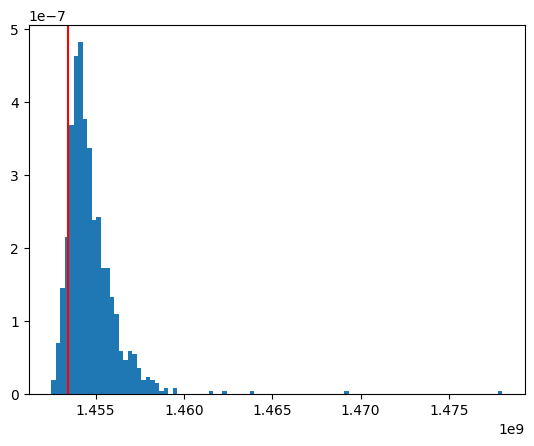

Application_373612346 [4.51415616e-07]


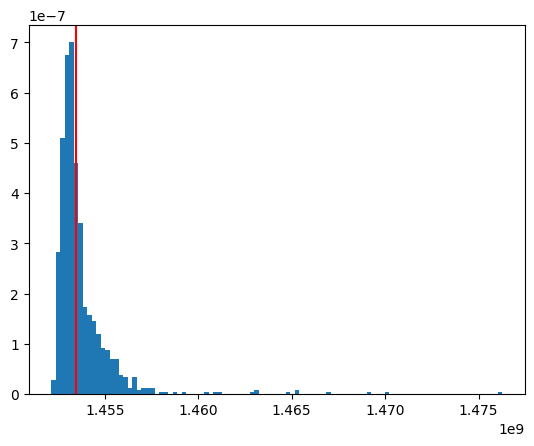

Application_678686961 [2.98551826e-07]


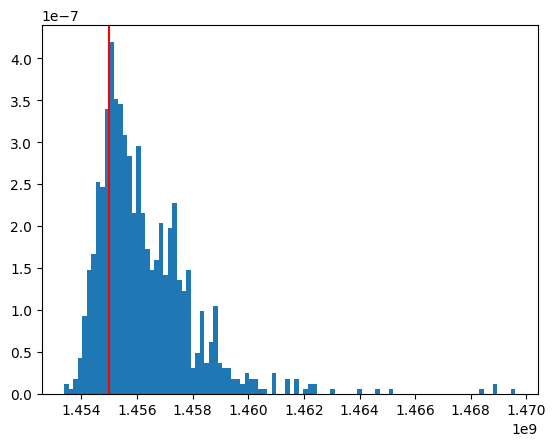

Application_1247929652 [3.15430181e-07]


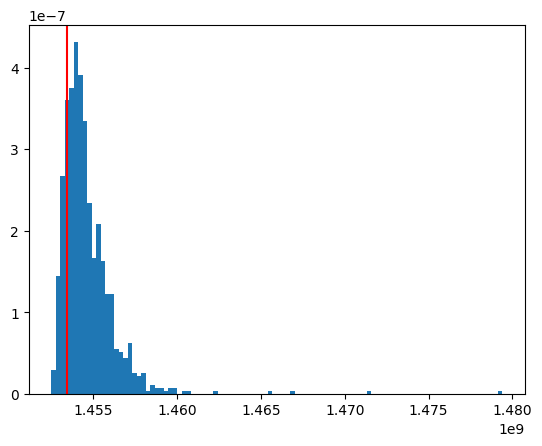

Application_1880024094 [1.04028101e-07]


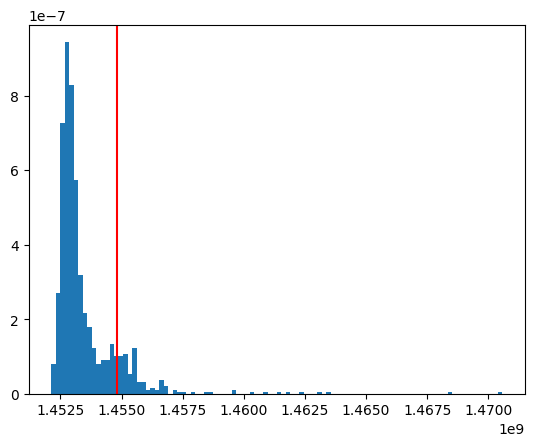

Application_829714042 [3.99899923e-07]


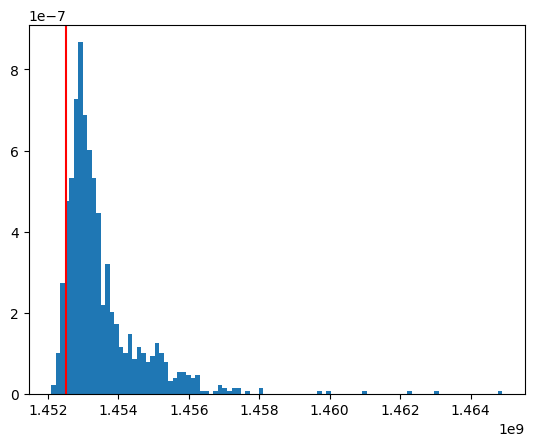

Application_111956933 [9.89079976e-09]


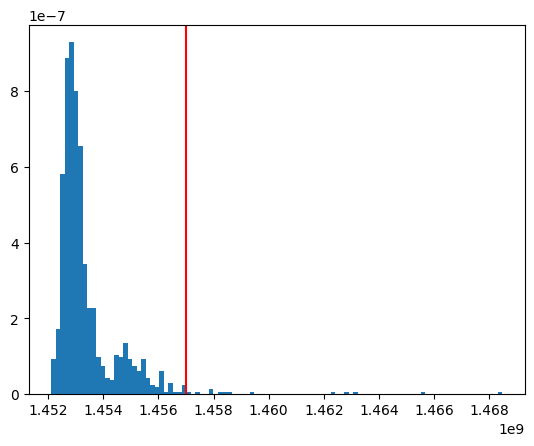

Application_1922956945 [1.00737067e-07]


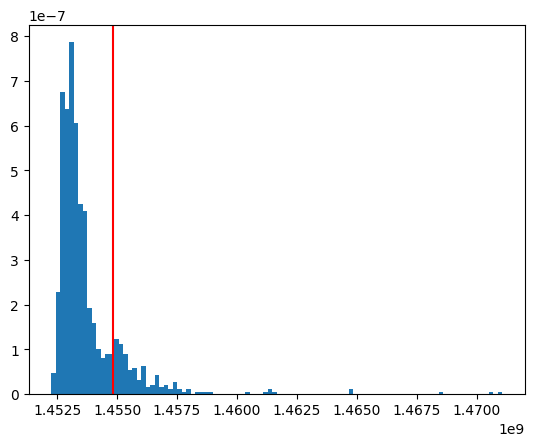

Application_1562741414 [4.25809825e-07]


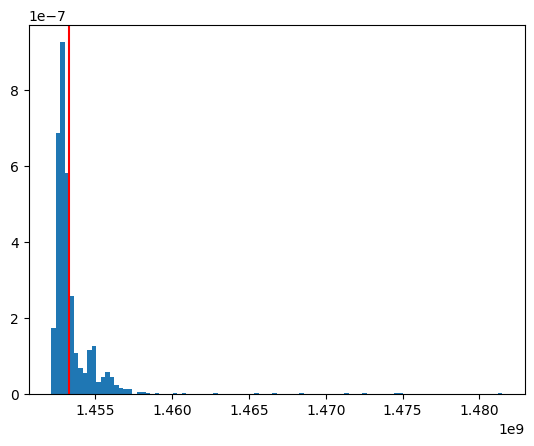

Application_983392205 [3.4953924e-09]


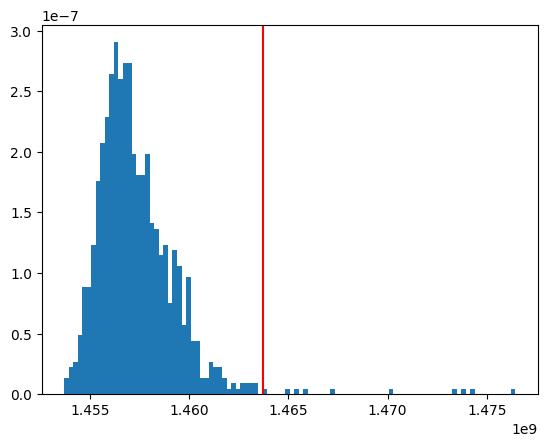

Application_929235447 [1.01078114e-08]


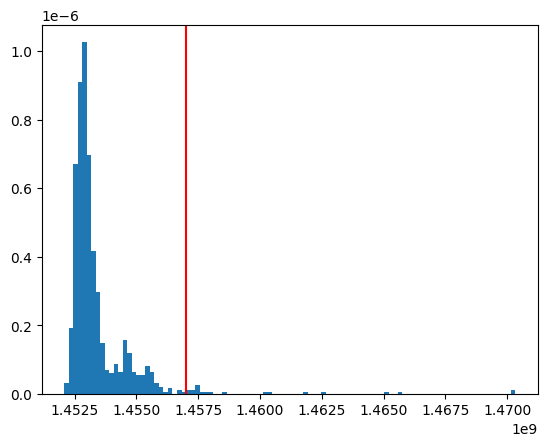

Application_2012524282 [4.49473731e-07]


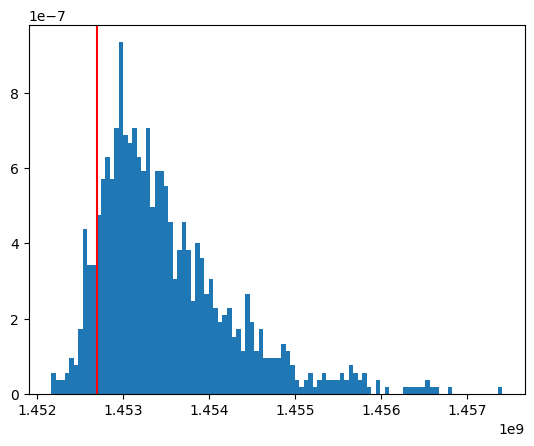

Application_874857207 [1.14788021e-07]


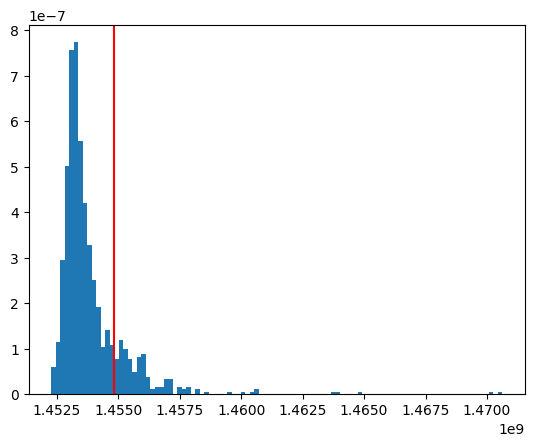

Application_74089970 [1.95958232e-06]


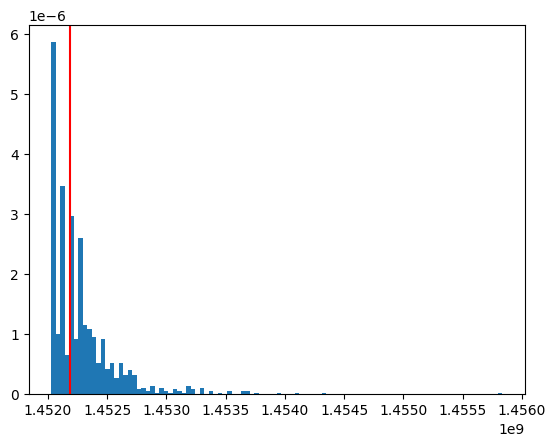

Application_1291947335 [2.25115429e-07]


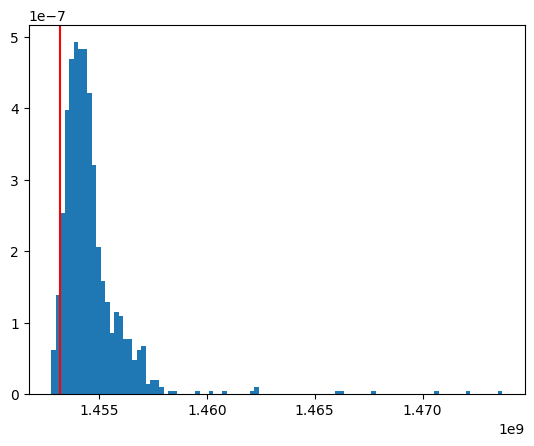

Application_1559270931 [6.59232808e-07]


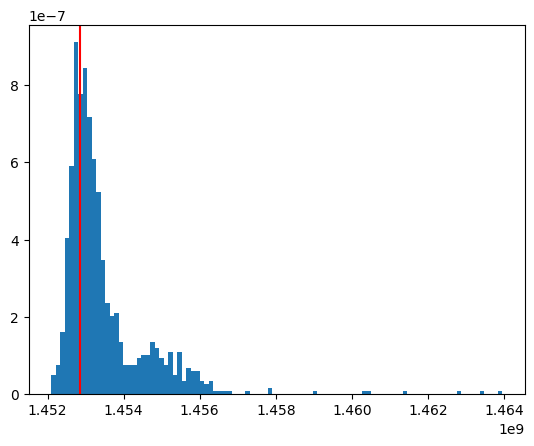

Application_2003843374 [8.25420039e-08]


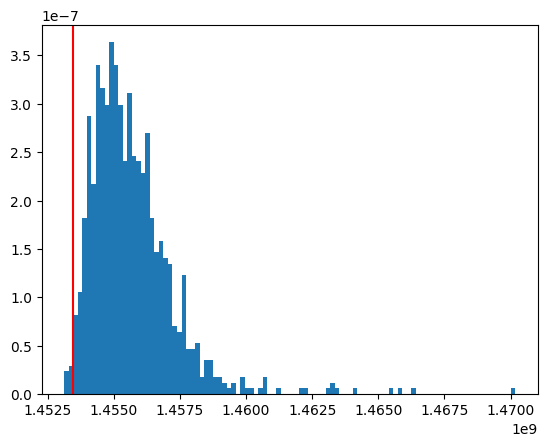

Application_493812399 [3.7651316e-07]


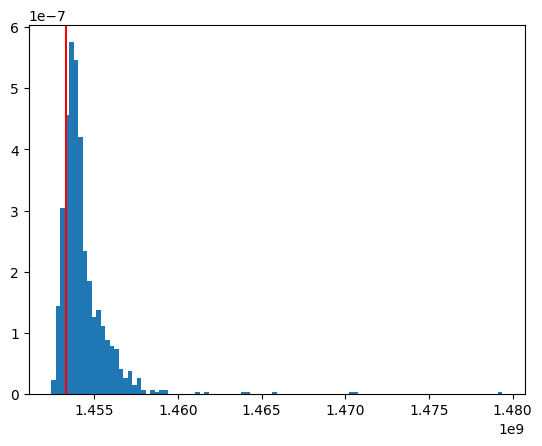

Application_144264435 [1.83236416e-07]


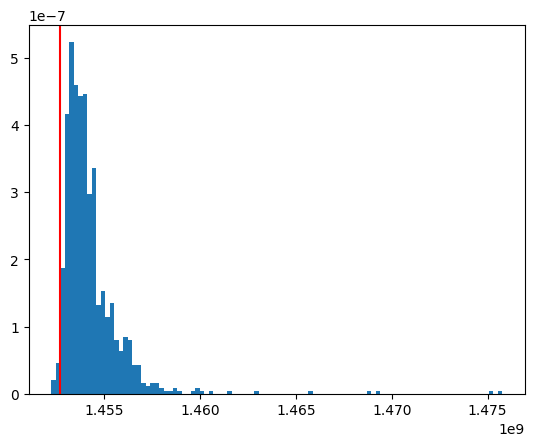

Application_2005183817 [9.18417298e-07]


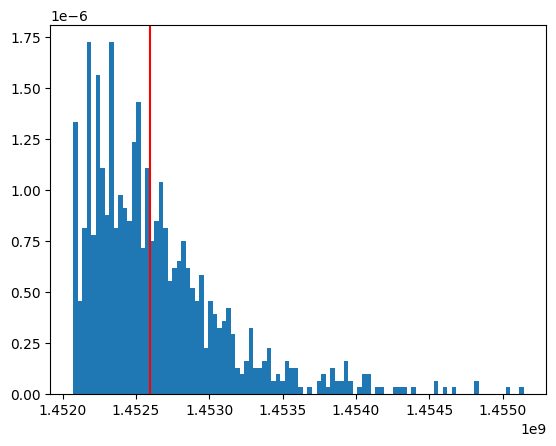

Application_606090913 [8.65721626e-08]


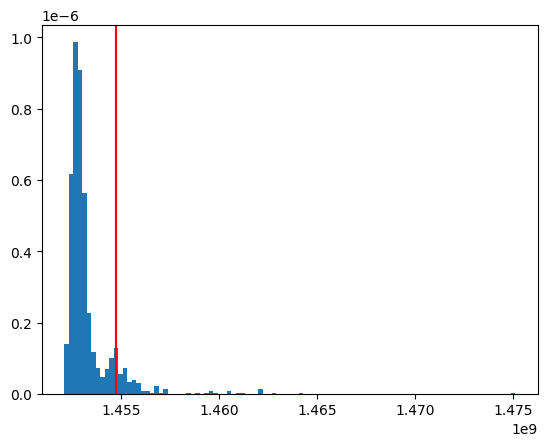

Application_1377264777 [1.93653793e-07]


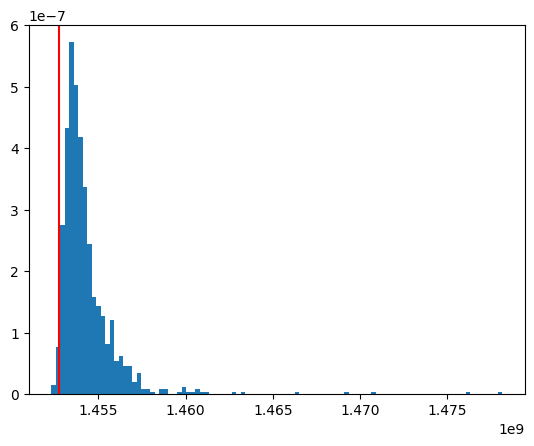

Application_1052983039 [4.25404622e-07]


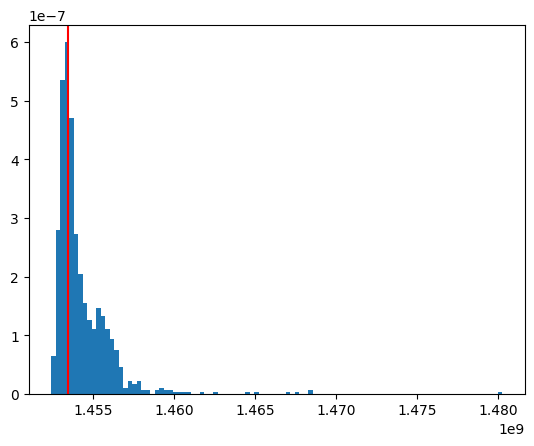

Application_1363165385 [4.62880454e-07]


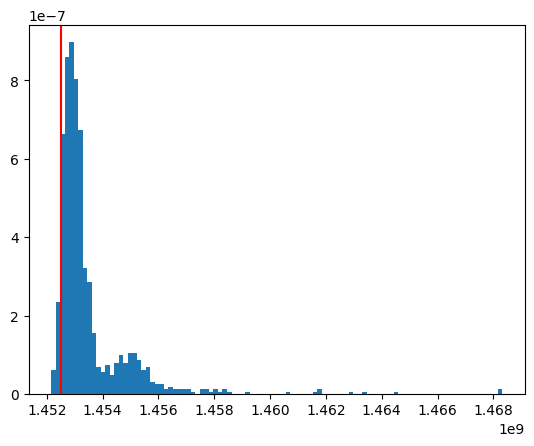

Application_1426271838 [3.18097961e-08]


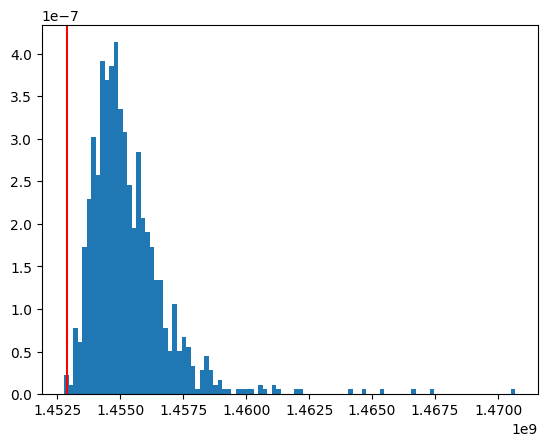

Application_1537110918 [3.24612904e-07]


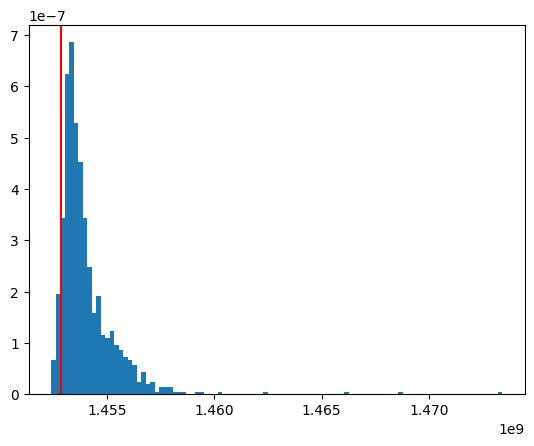

Application_1313879847 [5.23159108e-09]


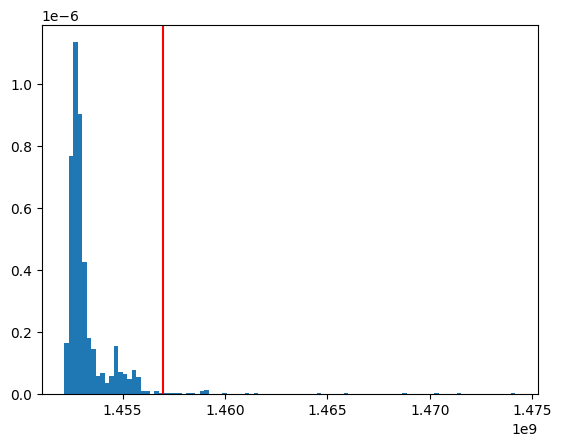

Application_162342266 [1.72775906e-07]


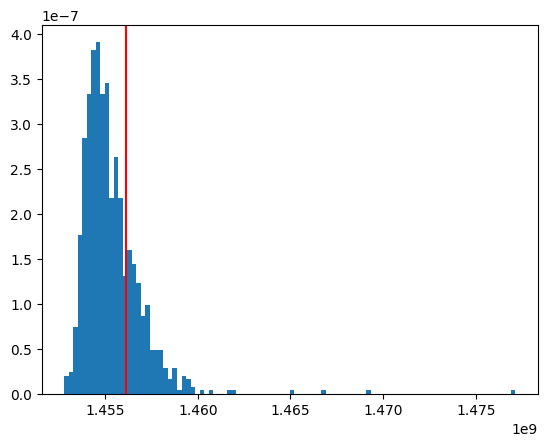

Application_2039499576 [4.96201826e-07]


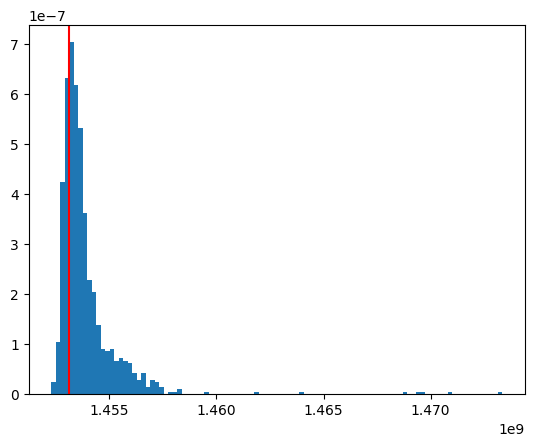

Application_1326688469 [8.69342134e-08]


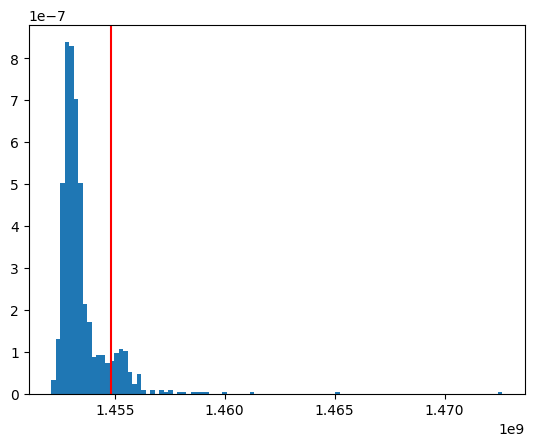

Application_1549864001 [4.97420798e-07]


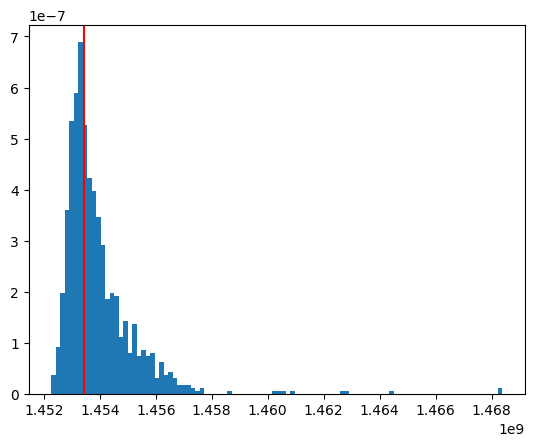

Application_466958327 [4.0981262e-07]


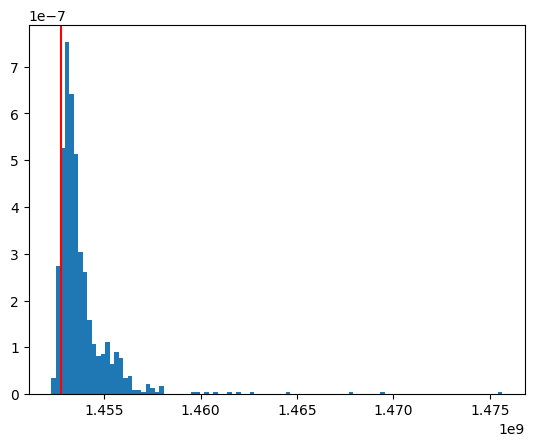

Application_232465255 [4.580521e-07]


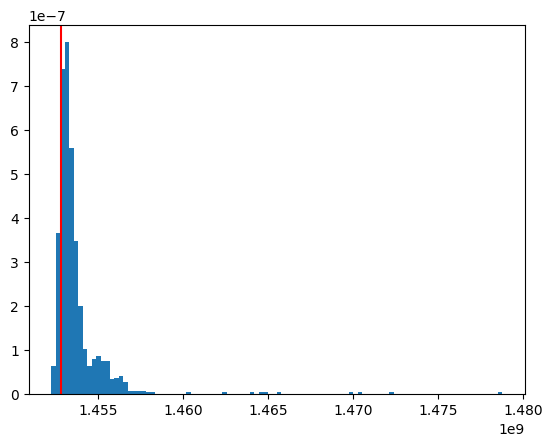

Application_664361440 [9.22096789e-08]


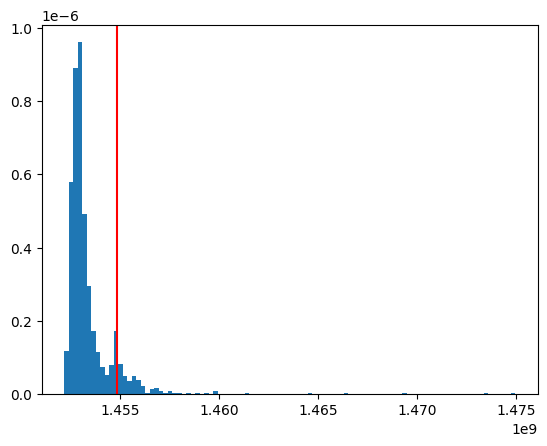

Application_1508103415 [4.15701343e-07]


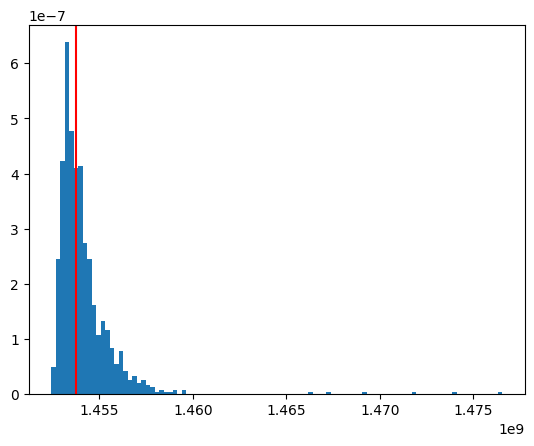

Application_1747572025 [5.89182942e-07]


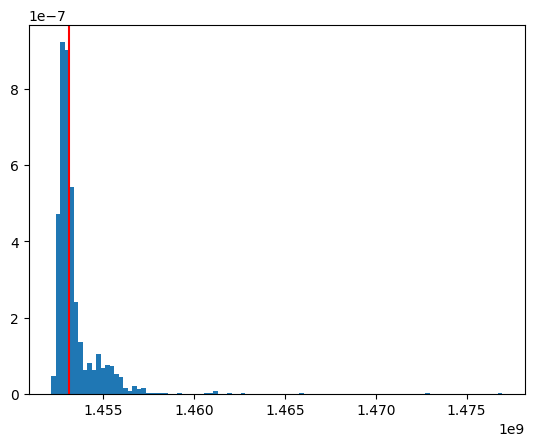

Application_1302654957 [9.64771542e-08]


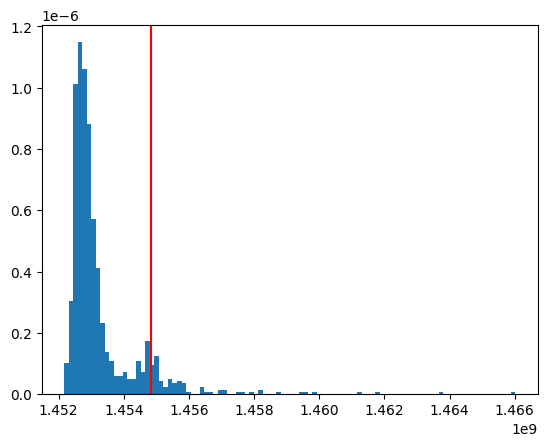

Application_2120232738 [7.17386488e-08]


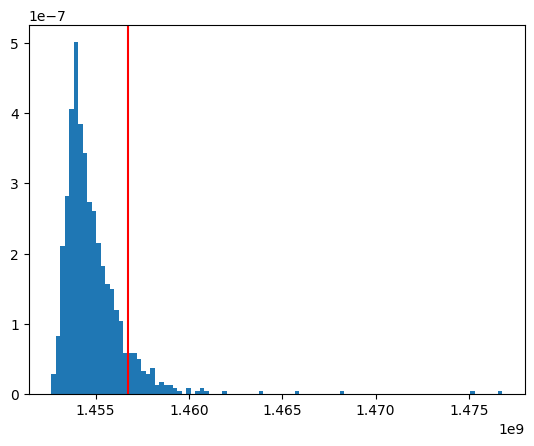

Application_1930715945 [1.06065631e-07]


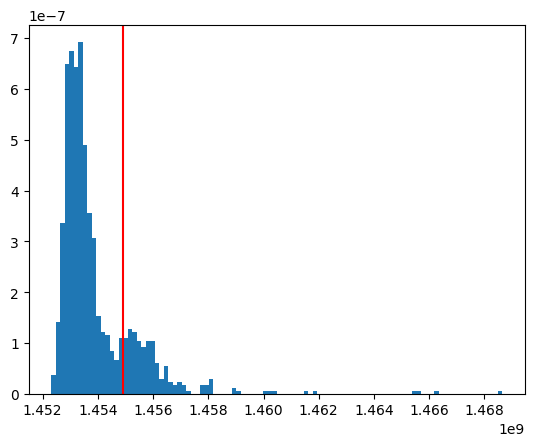

Application_1439119047 [2.17517791e-07]


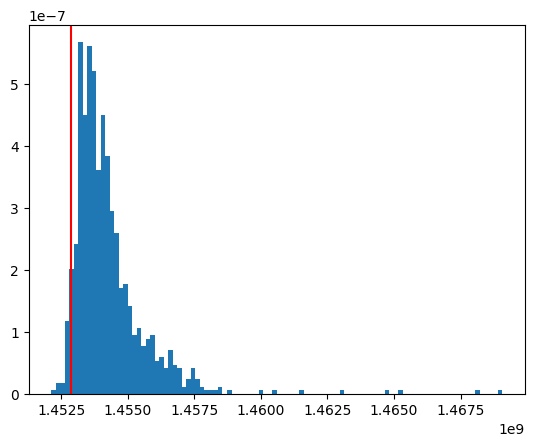

Application_807098596 [1.77466279e-07]


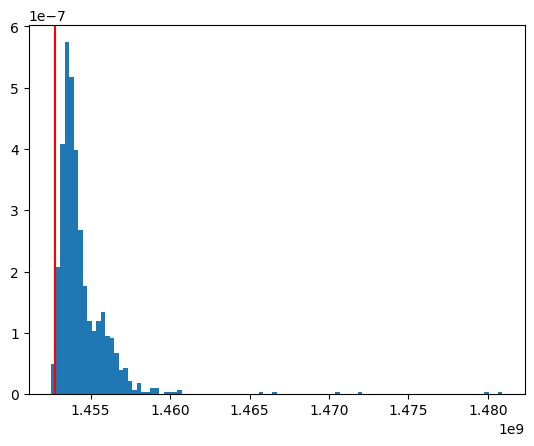

Application_1295329022 [1.48115605e-08]


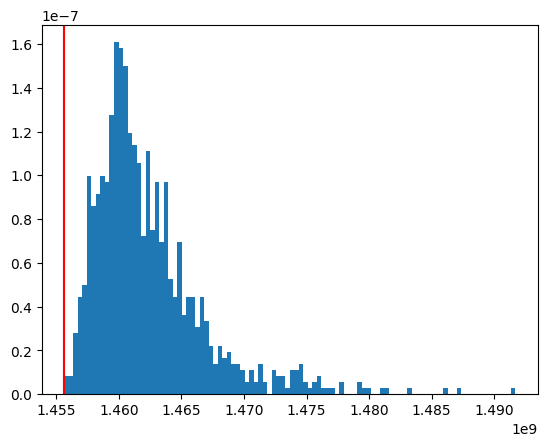

Application_1699815319 [5.36829107e-07]


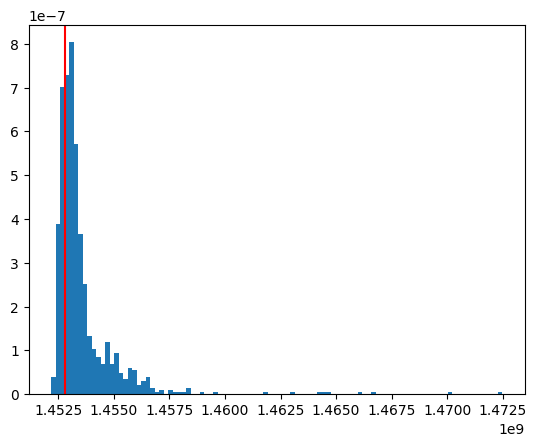

Application_1498056352 [1.3236128e-07]


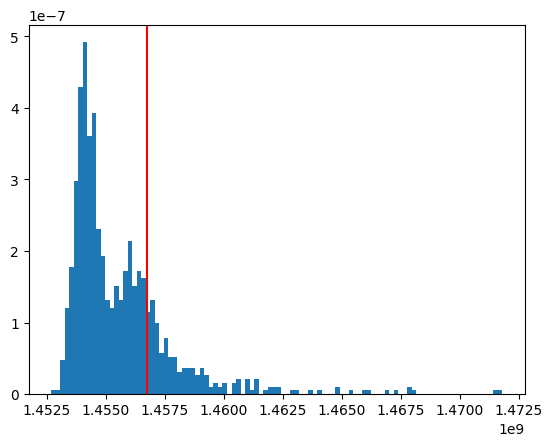

Application_743887463 [3.6628398e-07]


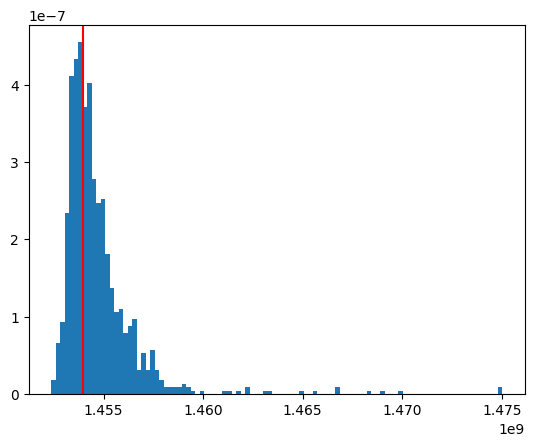

Application_1173759169 [1.276364e-07]


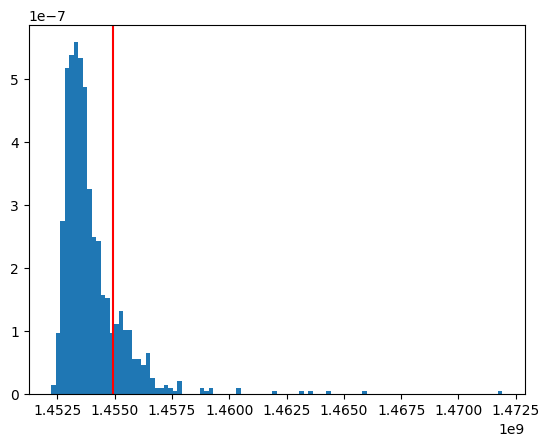

Application_2092350091 [2.04989128e-08]


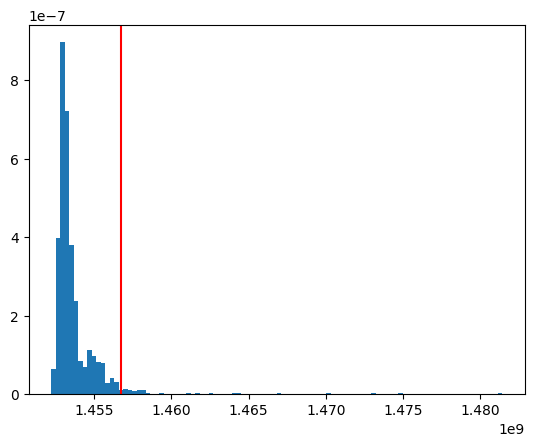

Application_1979284304 [3.86083162e-09]


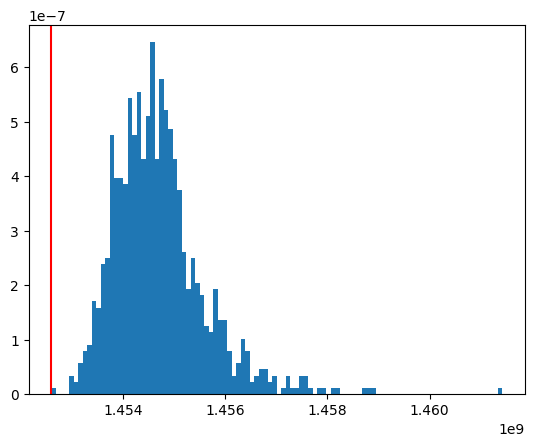

Application_297491355 [5.6987395e-07]


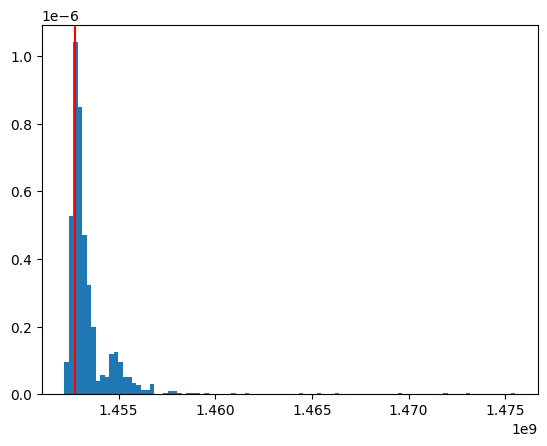

Application_1204730406 [3.7122408e-07]


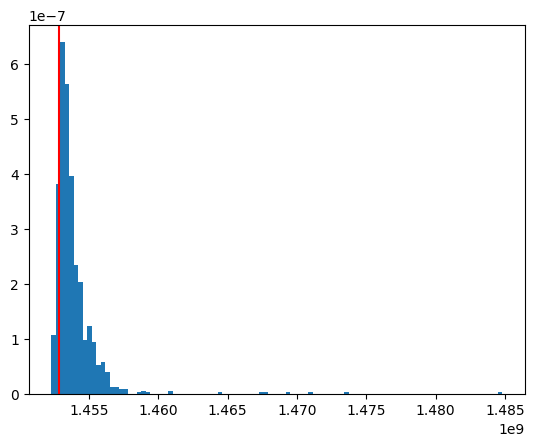

Application_1634651522 [2.97887543e-07]


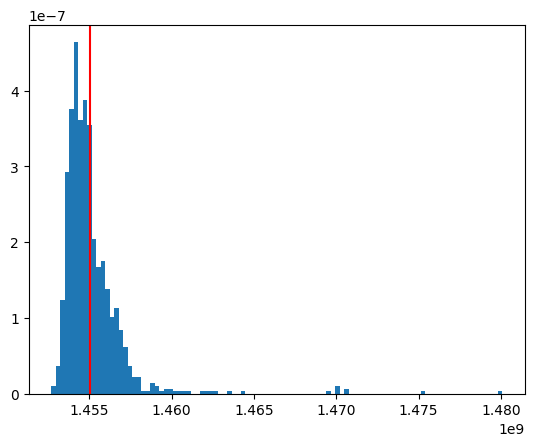

Application_1470184564 [3.368429e-07]


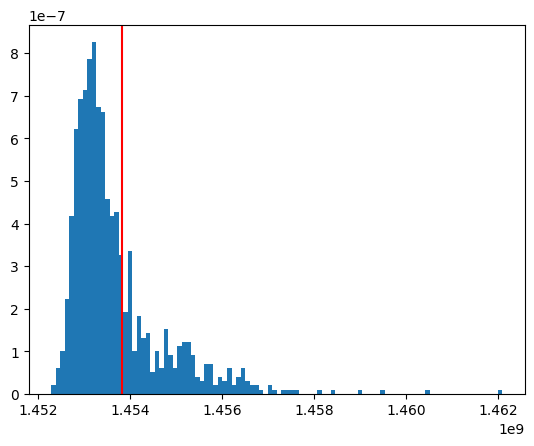

Application_1944285638 [5.50668382e-07]


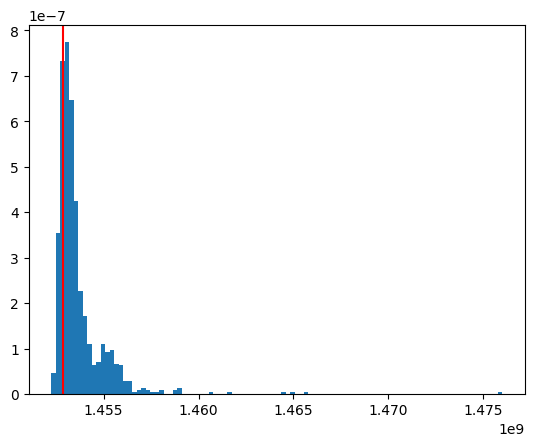

Application_836161395 [1.74434099e-07]


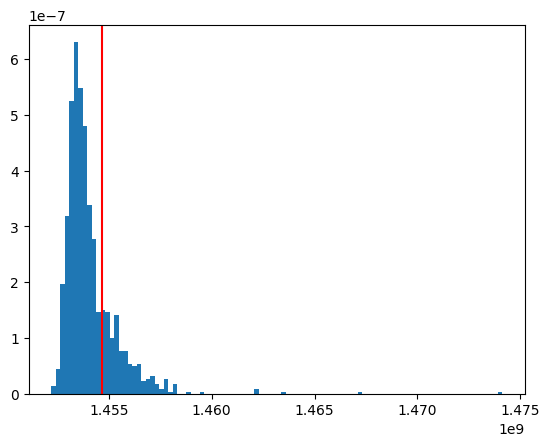

Application_1945220465 [4.84441255e-07]


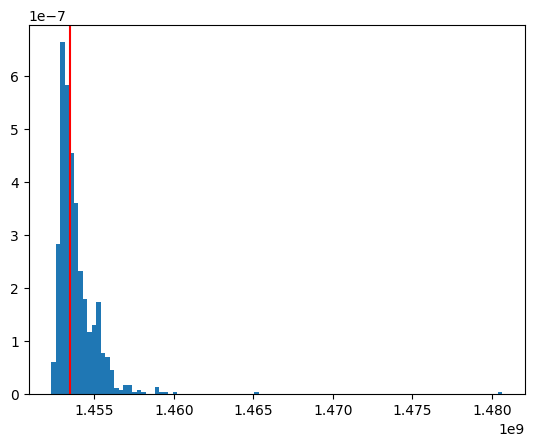

Application_1764180224 [2.21130987e-07]


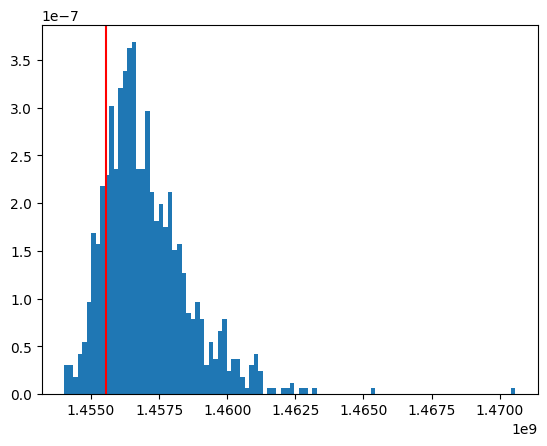

Application_1898813636 [9.73419369e-09]


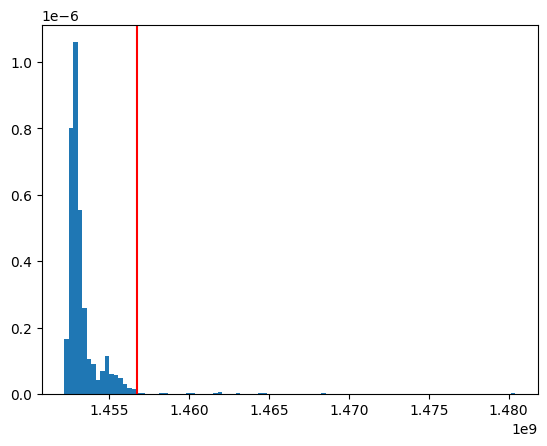

Application_681276588 [1.49568166e-07]


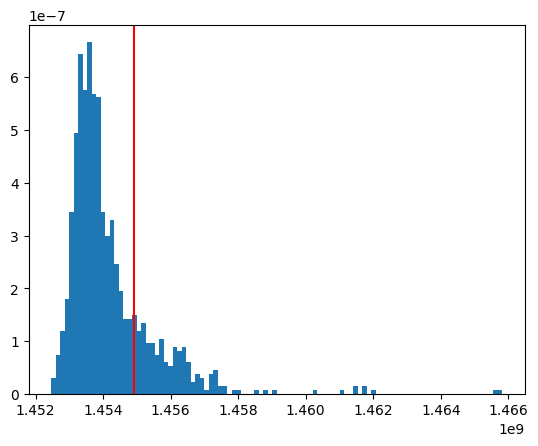

Application_365416480 [8.2037376e-08]


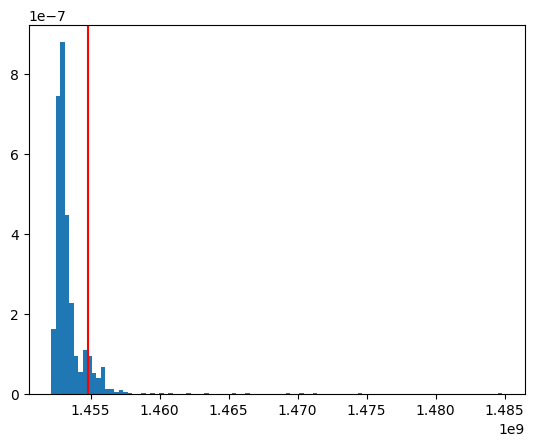

Application_1312956122 [1.93787377e-07]


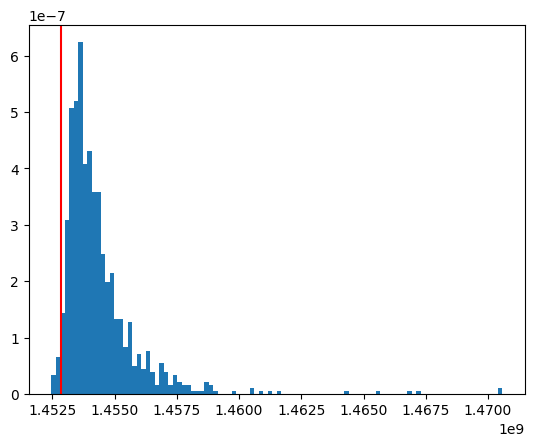

Application_1403474196 [3.97860282e-07]


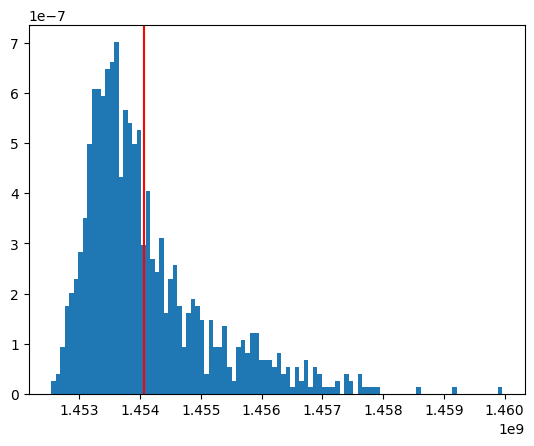

Application_1195697898 [3.59713428e-07]


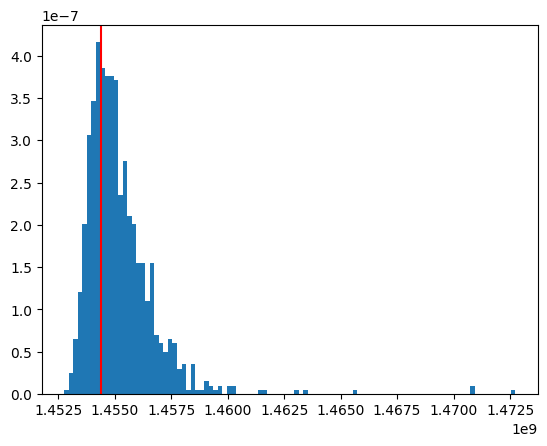

Application_1014301064 [4.79702038e-07]


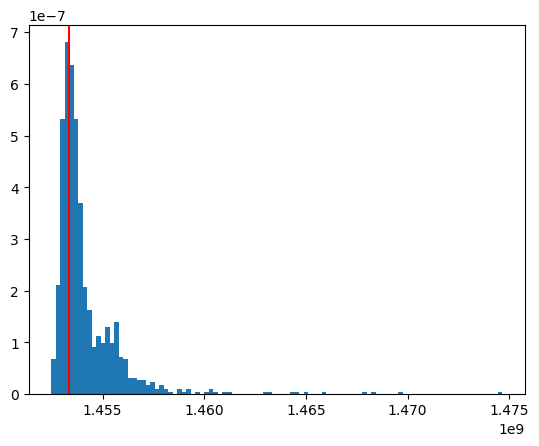

Application_242156921 [2.25873502e-07]


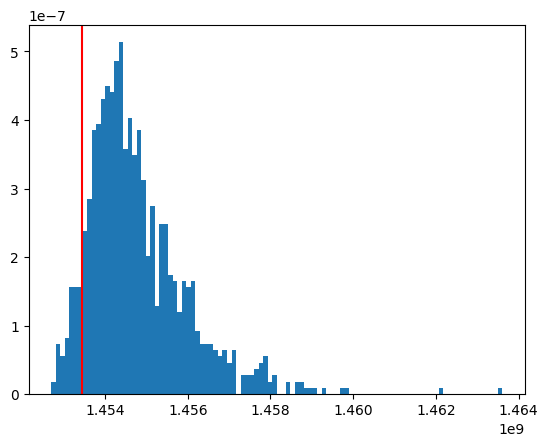

Application_2034562541 [3.81269196e-07]


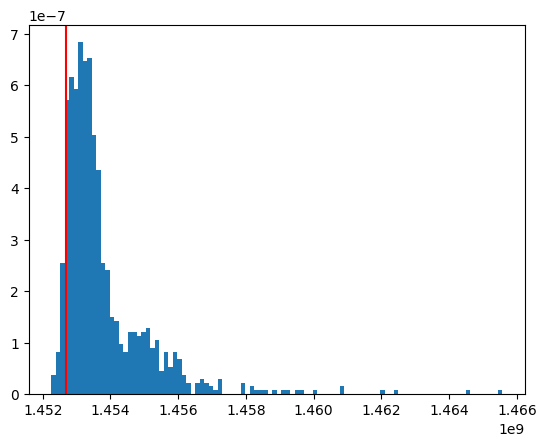

Application_1553446113 [7.57784268e-08]


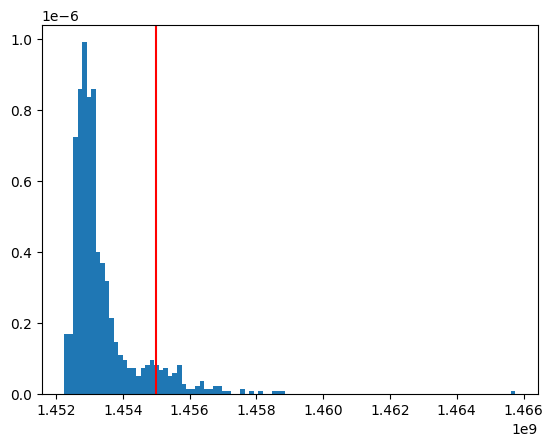

Application_443070493 [1.38108412e-08]


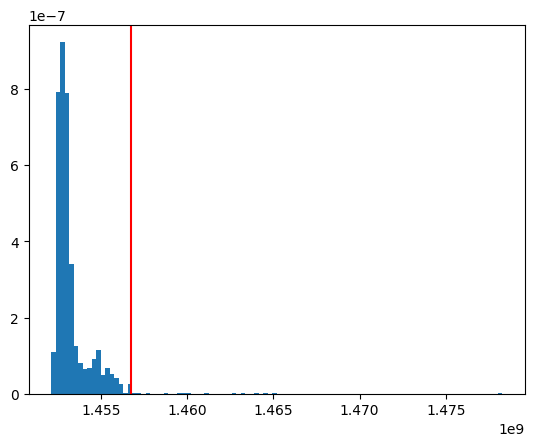

Application_1417516413 [7.79167153e-09]


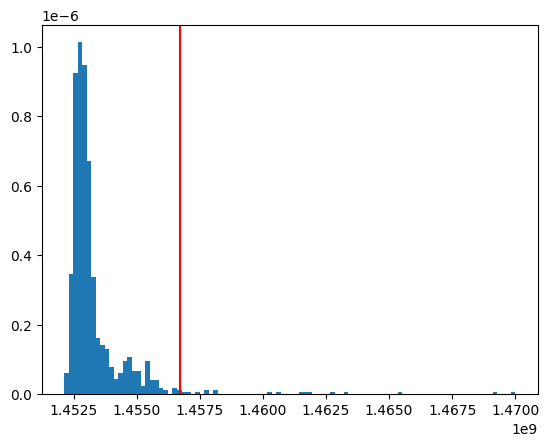

Application_1649139732 [8.78305453e-08]


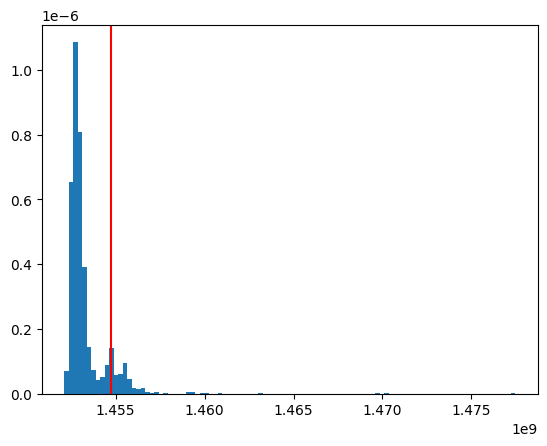

Application_289811958 [4.92559473e-07]


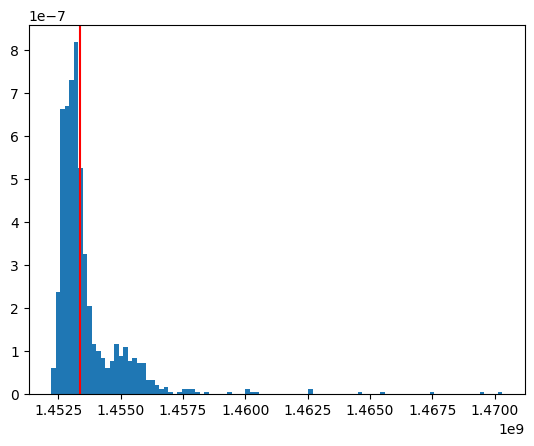

Application_341998174 [8.71263497e-08]


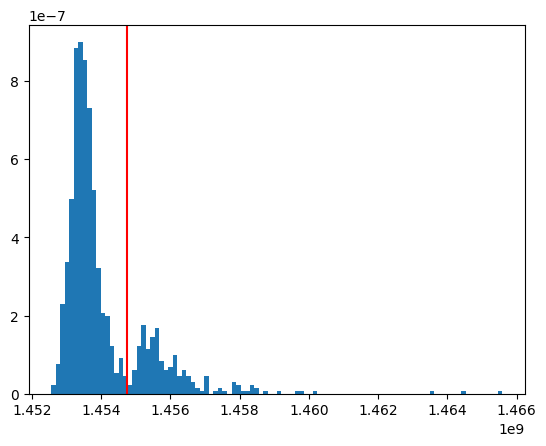

Application_879749975 [1.00830669e-07]


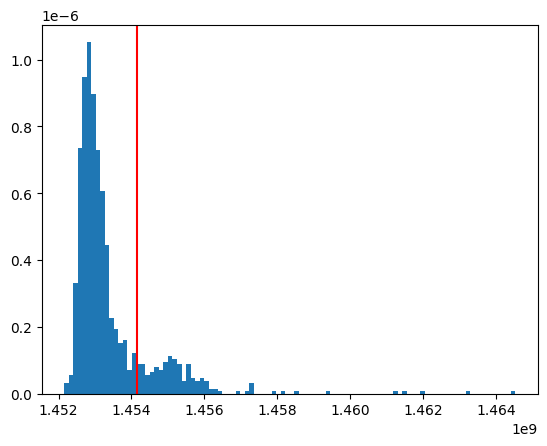

Application_59959307 [3.4938426e-07]


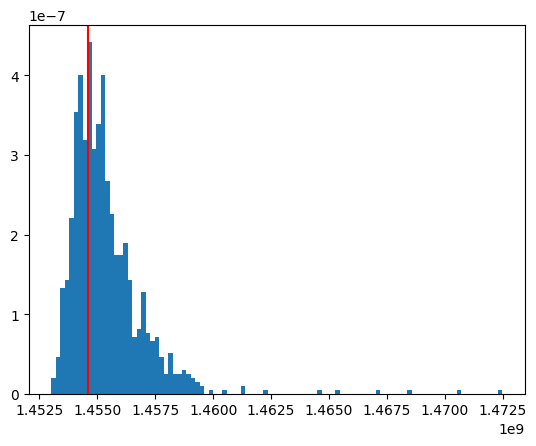

Application_2103337476 [9.41973045e-08]


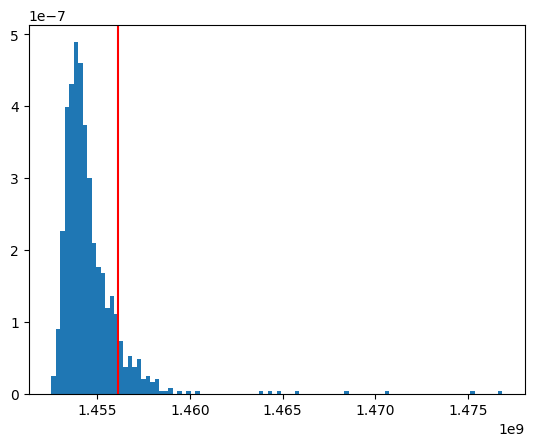

Application_1833362956 [1.43264282e-08]


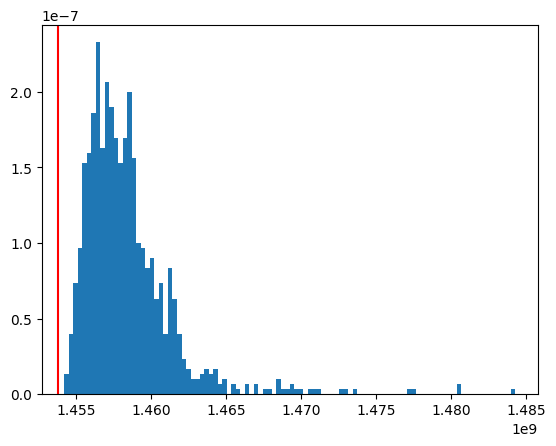

Application_750571787 [5.46017656e-07]


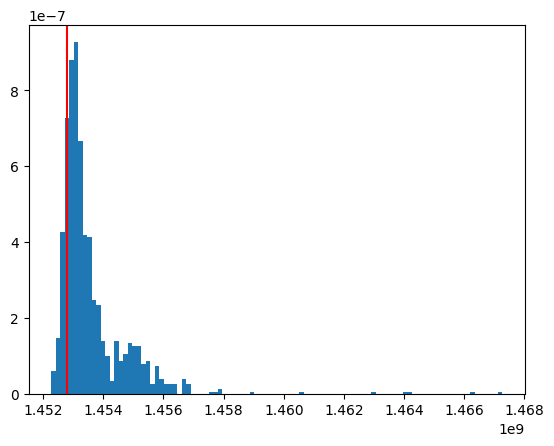

Application_1513129576 [5.00189784e-07]


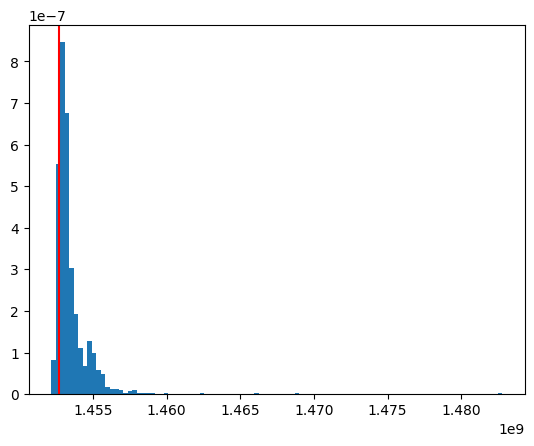

Application_1091101077 [8.14112339e-08]


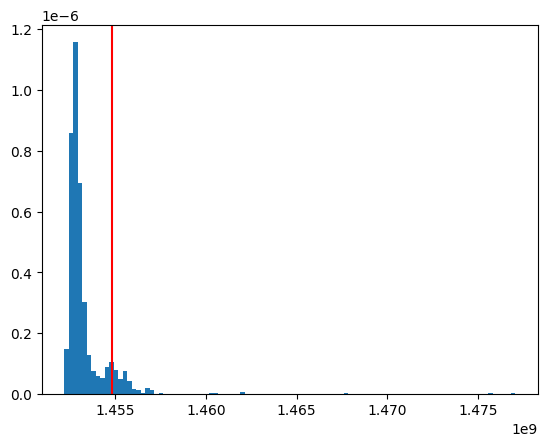

Application_1899463053 [1.84220728e-07]


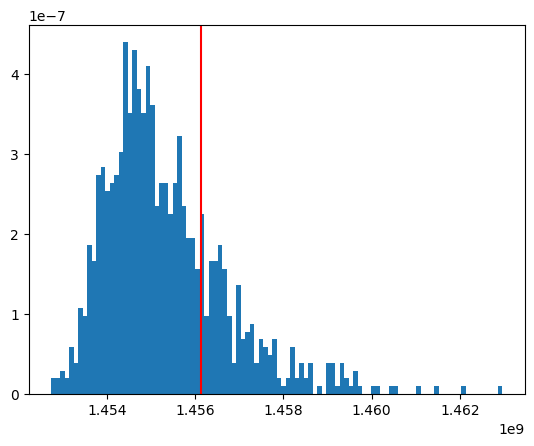

Application_1853330214 [6.5125486e-08]


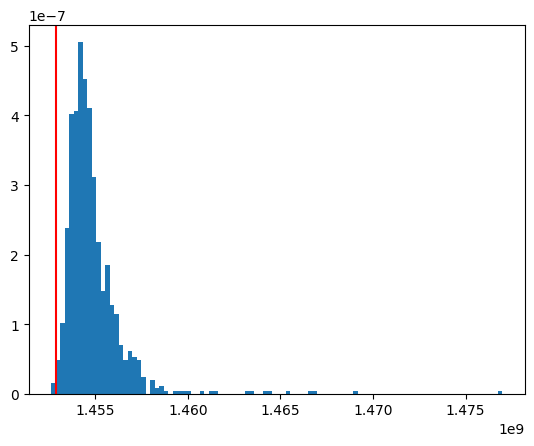

Application_1271512732 [9.35907e-08]


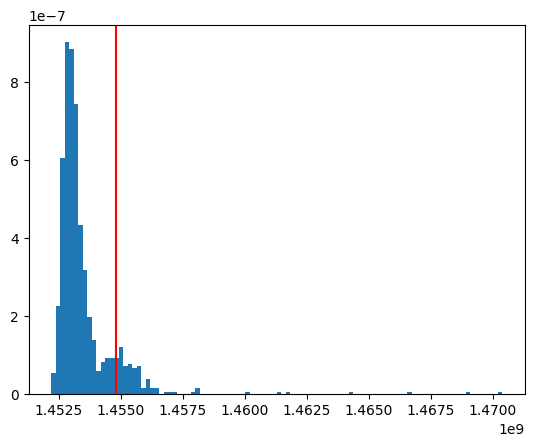

Application_1502516207 [3.68801214e-07]


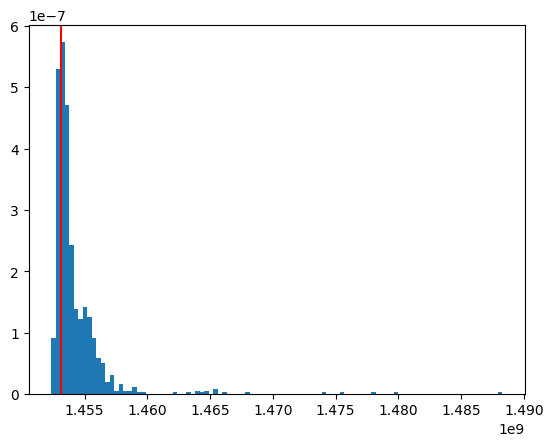

Application_22095206 [7.86546388e-08]


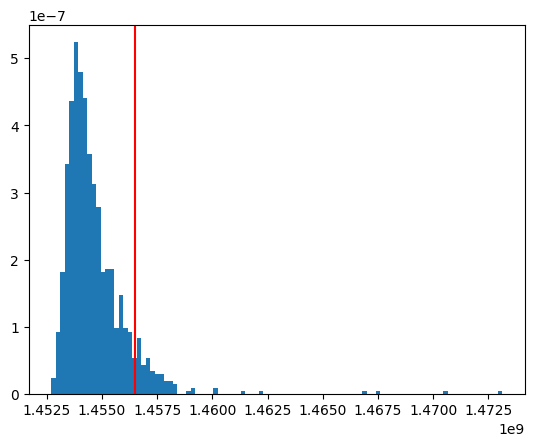

Application_1631137033 [9.71217128e-10]


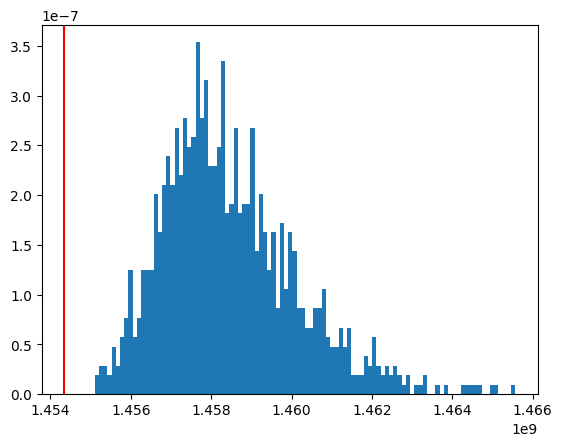

Application_1142700916 [9.39475529e-08]


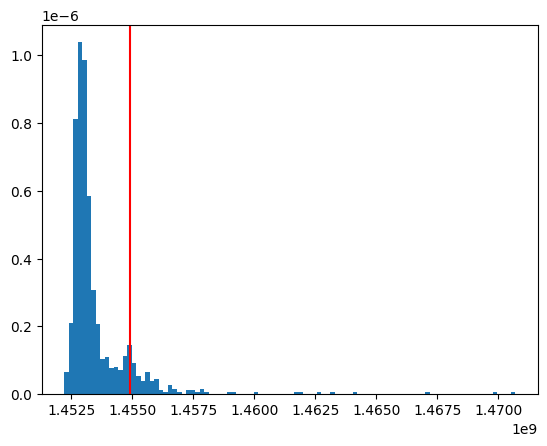

Application_2078253178 [4.53608746e-07]


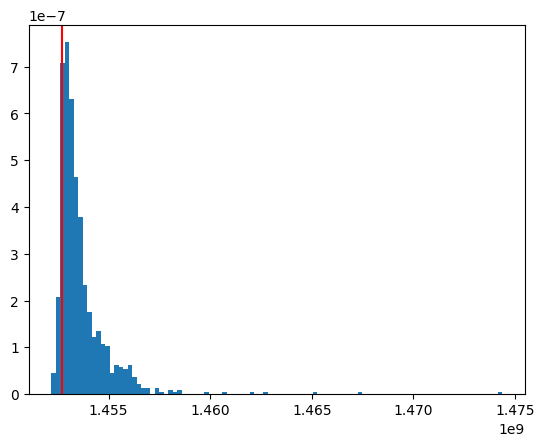

Application_1724196691 [9.41384171e-08]


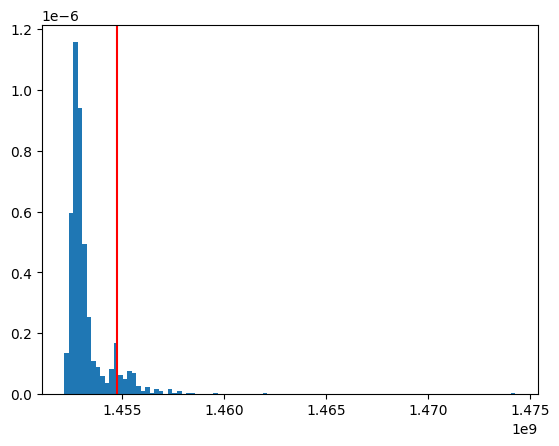

Application_1139007530 [2.45348097e-07]


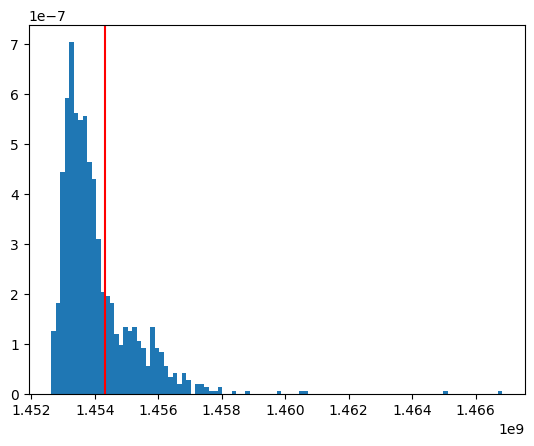

Application_784275418 [1.4260218e-08]


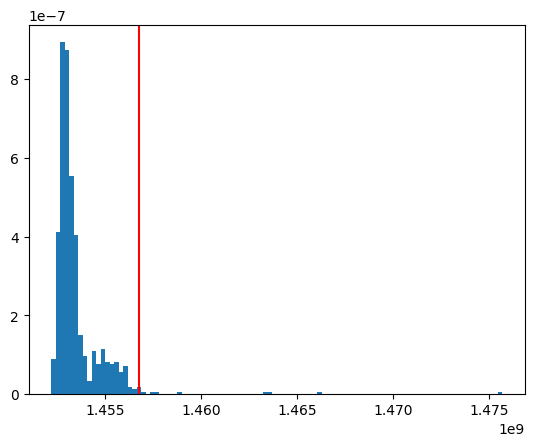

Application_1771304108 [9.3171337e-08]


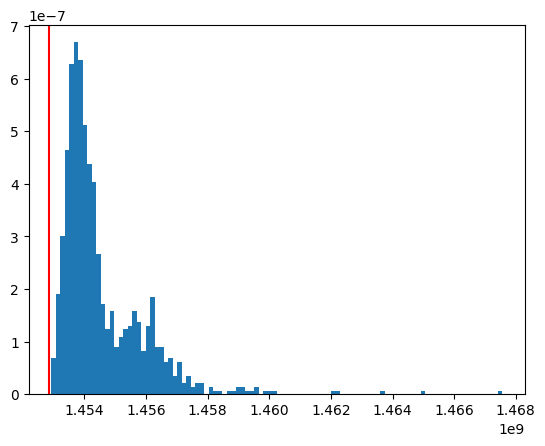

Application_259183799 [8.10102041e-09]


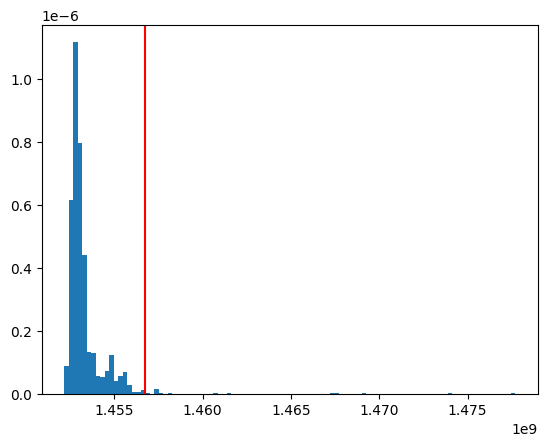

Application_2081147987 [4.94026221e-07]


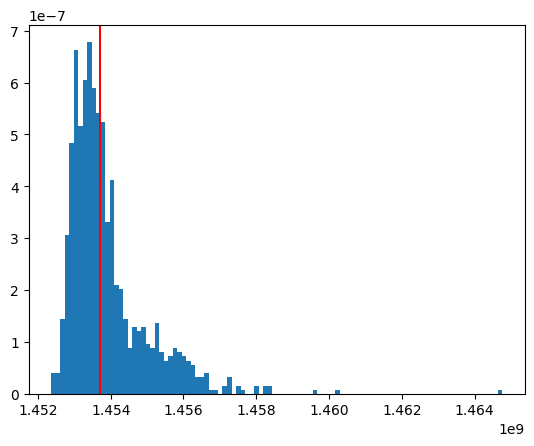

Application_1282765506 [1.78492112e-07]


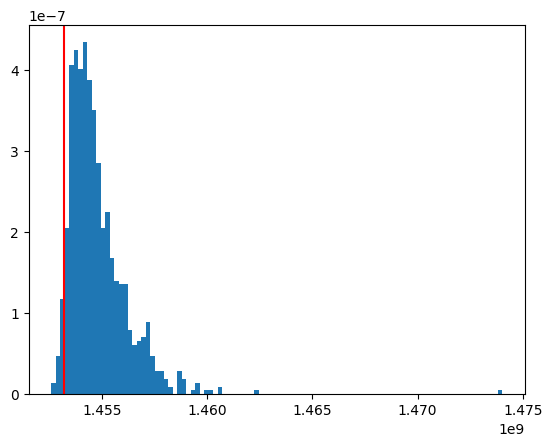

Application_259143826 [2.36599842e-07]


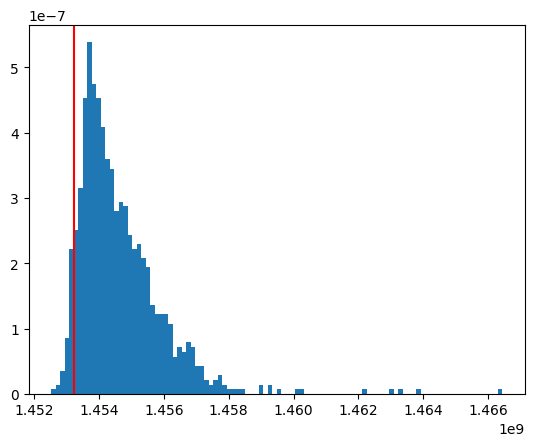

Application_1462703151 [3.75781882e-07]


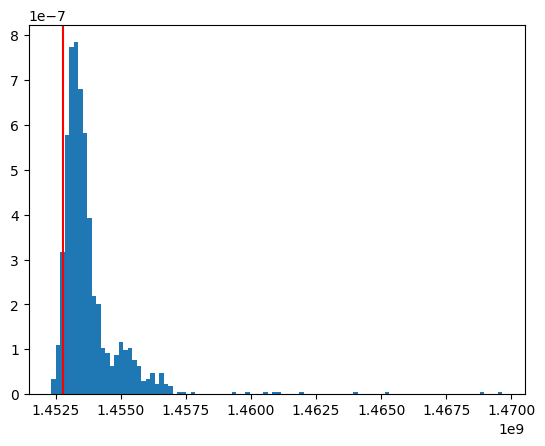

Application_1905015342 [7.17108151e-07]


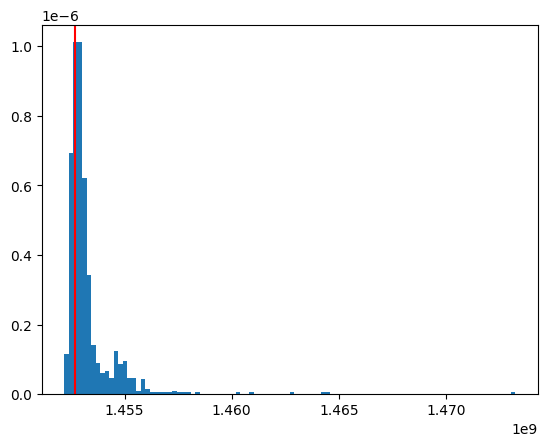

Application_1841789315 [1.00441321e-07]


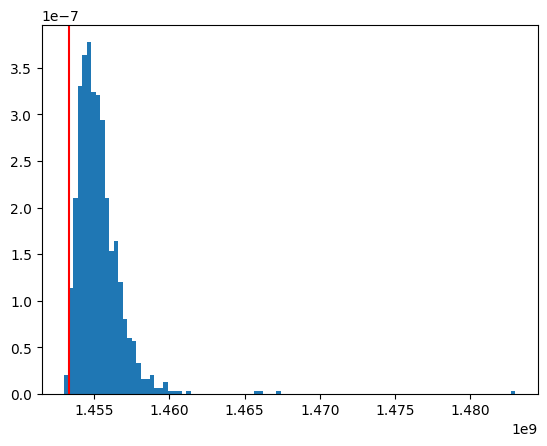

Application_2072694343 [3.17775875e-07]


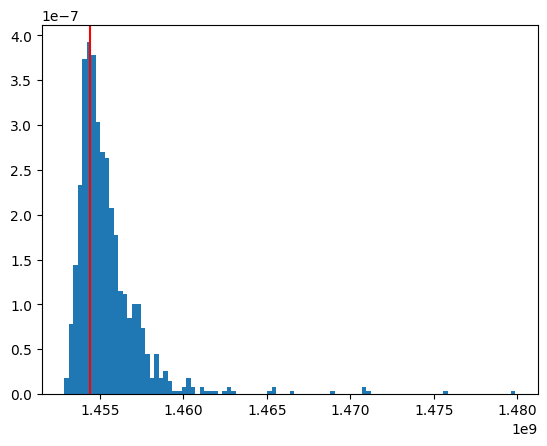

Application_1316947913 [7.20867872e-08]


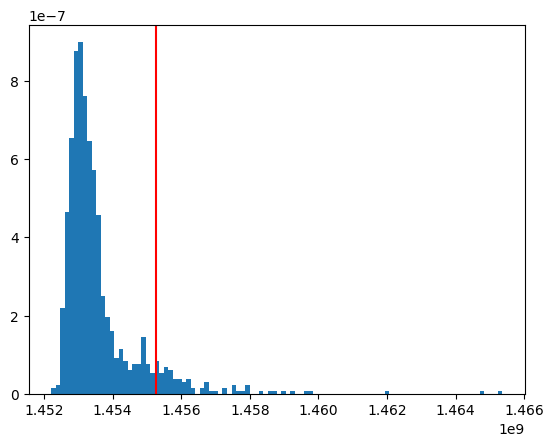

Application_1282768200 [4.29350892e-07]


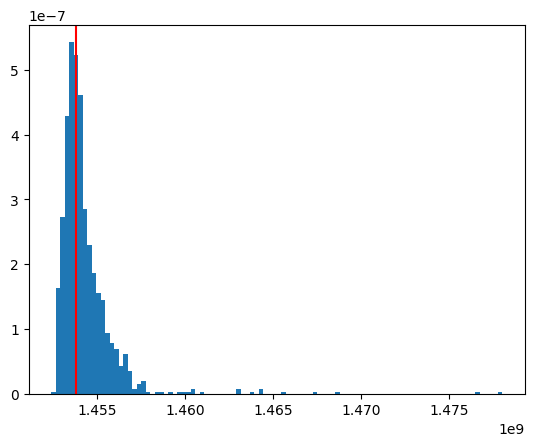

Application_1848603655 [9.07830723e-08]


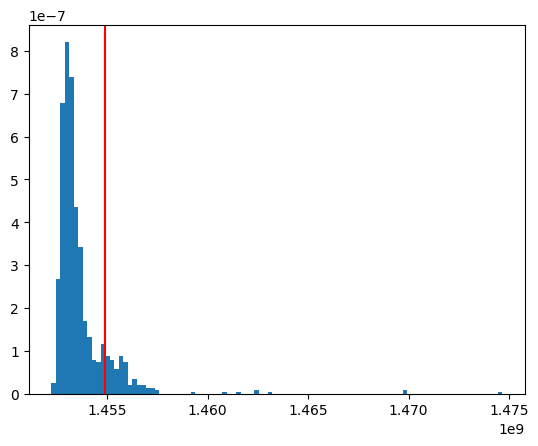

Application_2065677935 [4.55183868e-07]


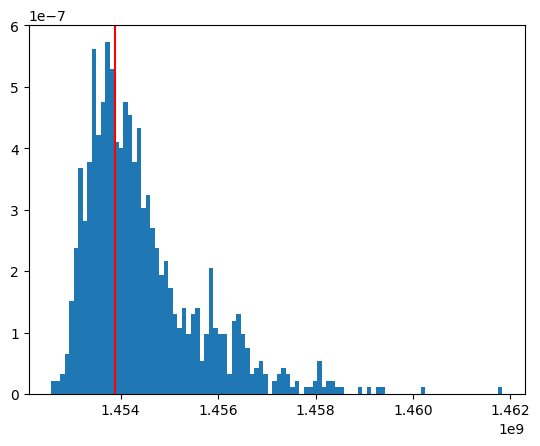

Application_775833032 [4.21643675e-07]


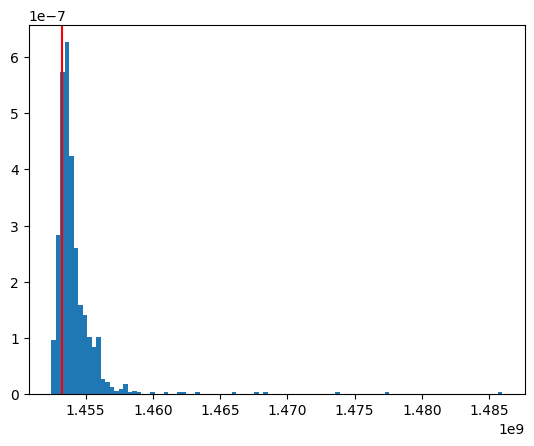

Application_1719274647 [4.9222508e-07]


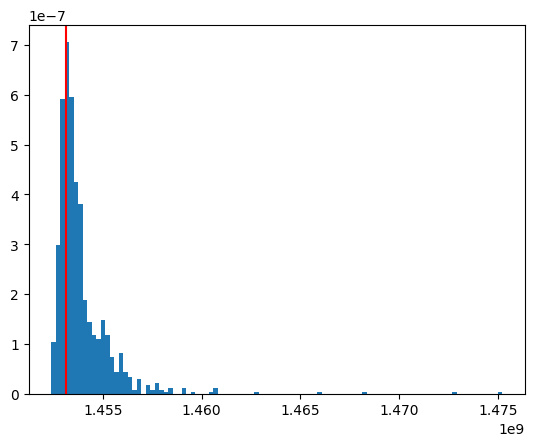

Application_1863611182 [1.00627136e-07]


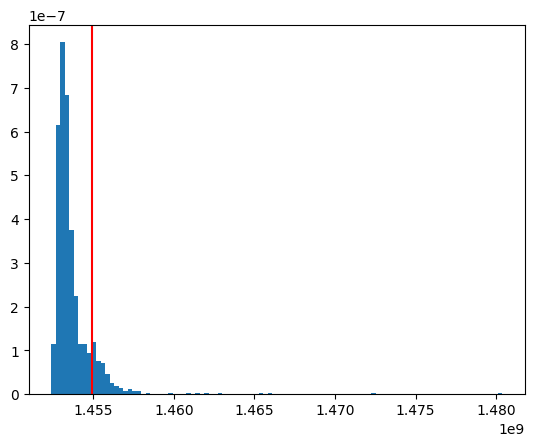

Application_1600150028 [6.9219771e-08]


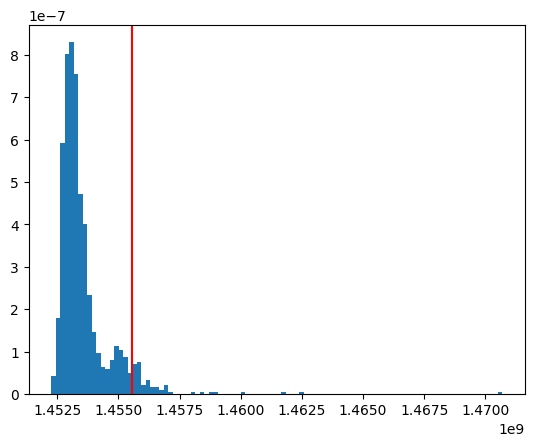

Application_1292397670 [3.07517997e-07]


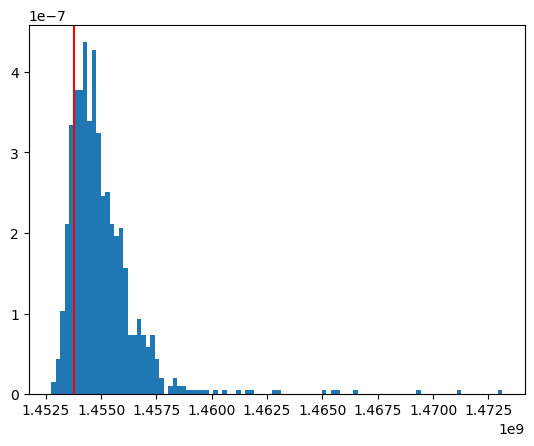

Application_2081911804 [8.63370102e-08]


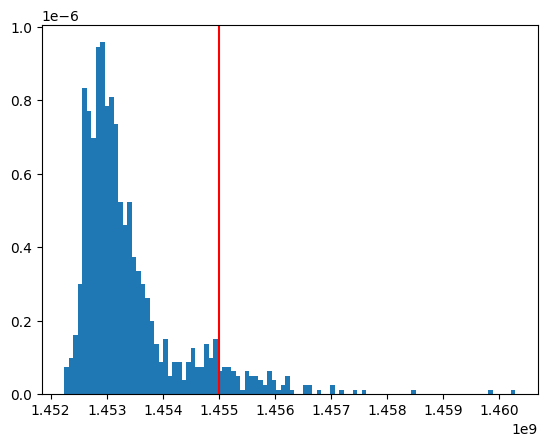

Application_335096189 [3.11594293e-07]


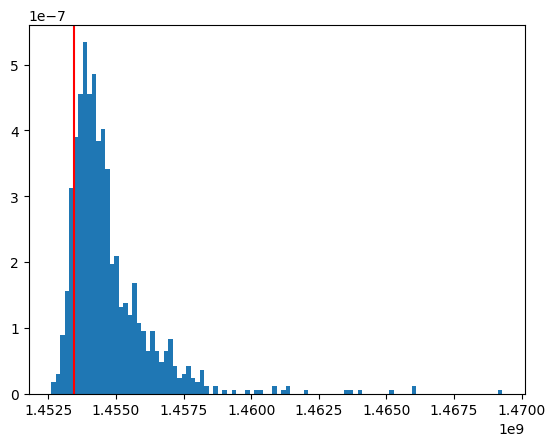

Application_111540759 [1.48974343e-07]


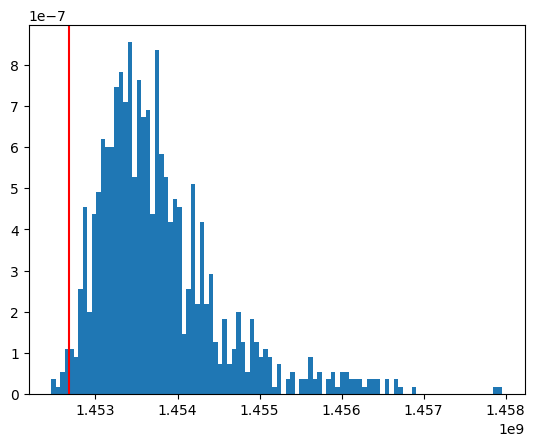

Application_524429786 [8.8411335e-08]


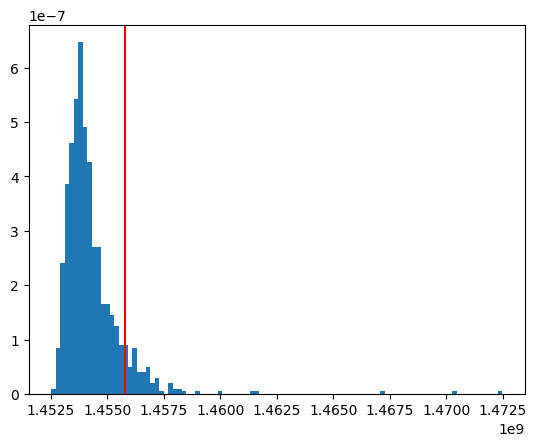

Application_1355798622 [2.02016619e-08]


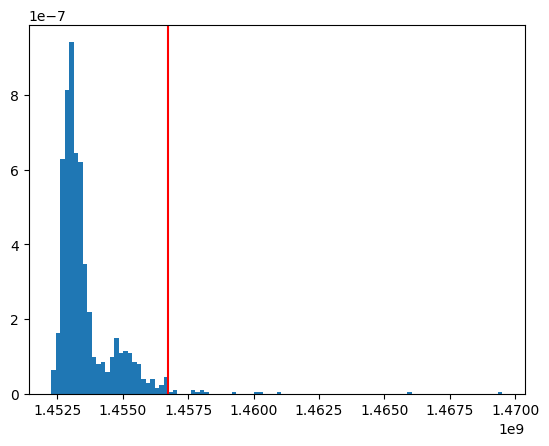

Application_854402455 [5.38640477e-07]


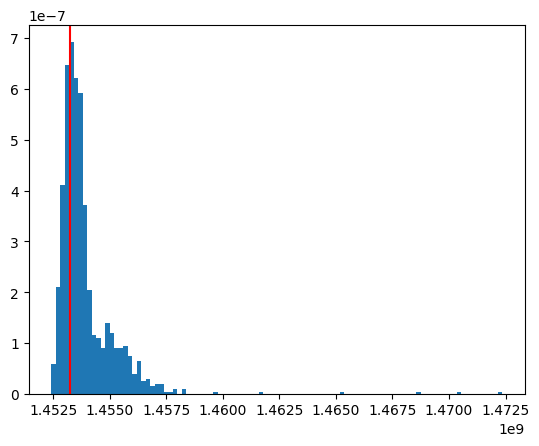

Application_1077411737 [5.19845299e-07]


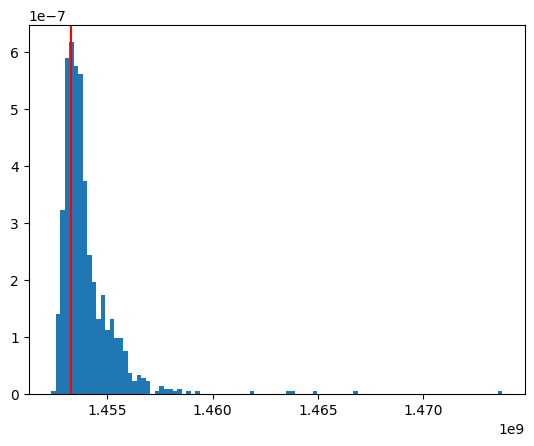

Application_1283783929 [1.19607372e-07]


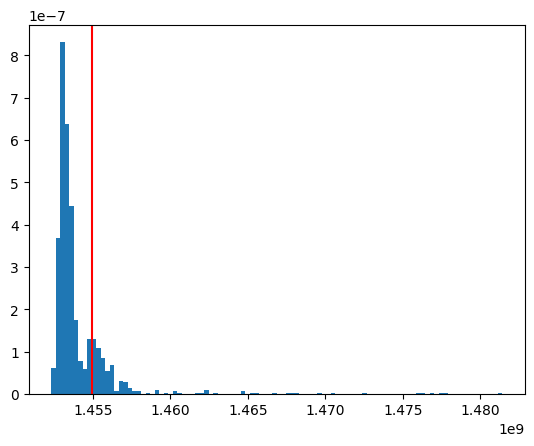

Application_854178970 [9.81500181e-08]


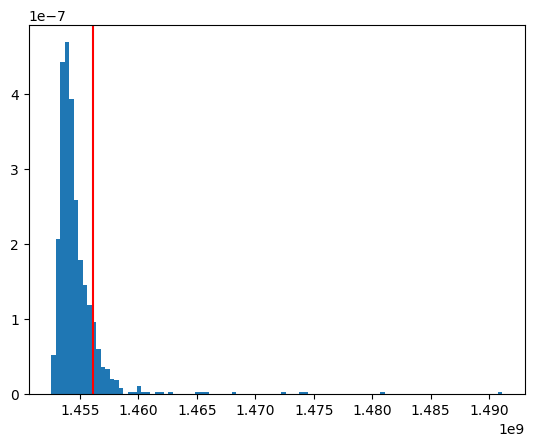

Application_1507218840 [4.48111915e-07]


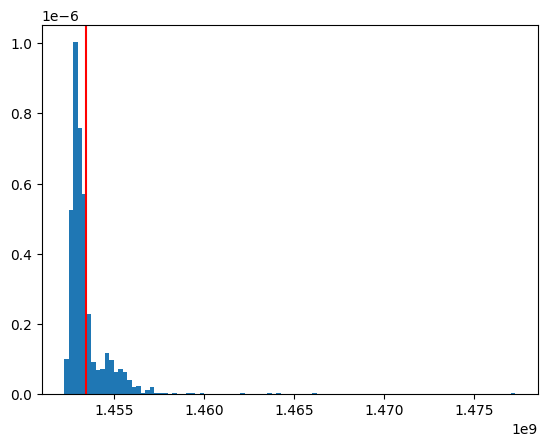

Application_543915014 [3.22504343e-07]


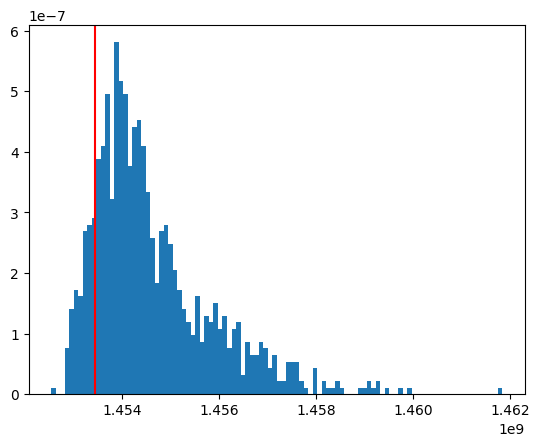

Application_1940130892 [5.26328252e-07]


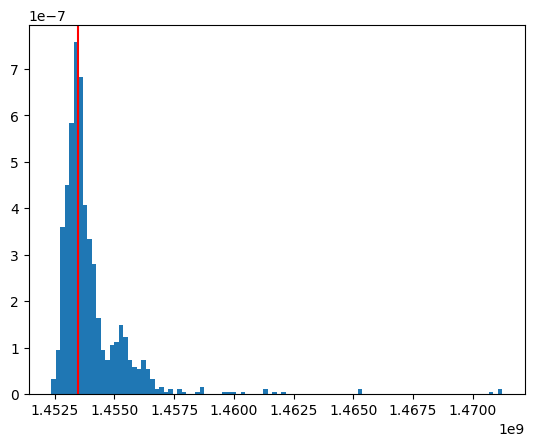

Application_2139889803 [4.0216888e-07]


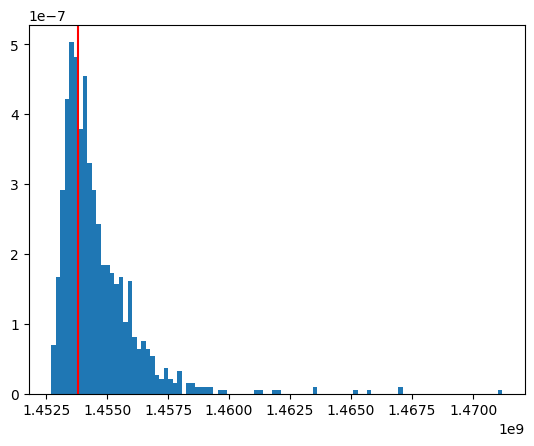

Application_918578724 [5.45786495e-08]


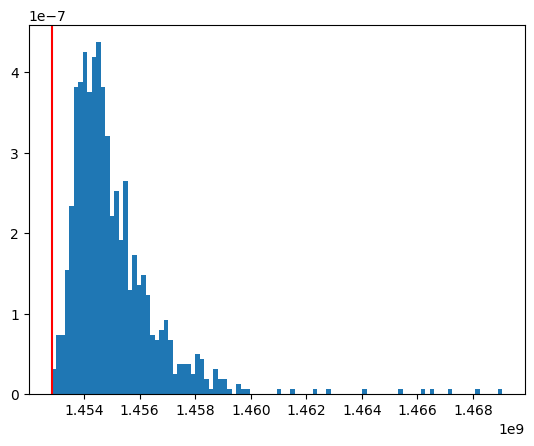

Application_843590096 [3.51745134e-07]


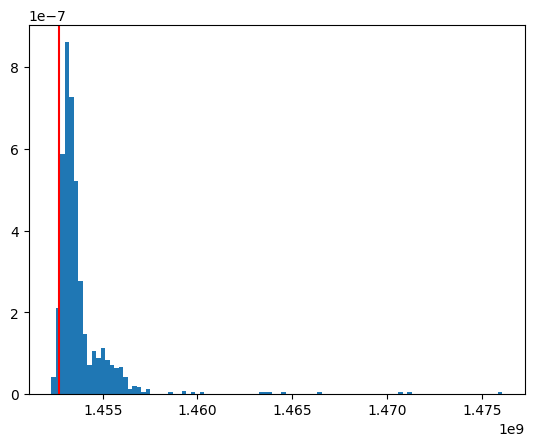

Application_220286199 [5.42446791e-07]


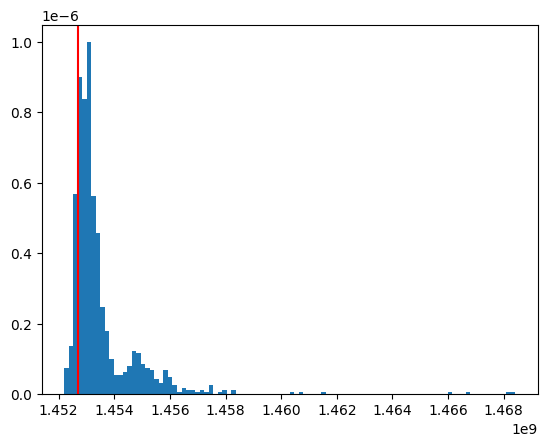

Application_5240566 [5.64800091e-07]


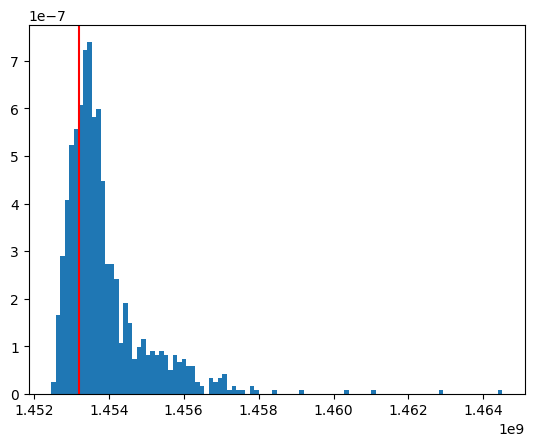

Application_919767326 [2.36560164e-07]


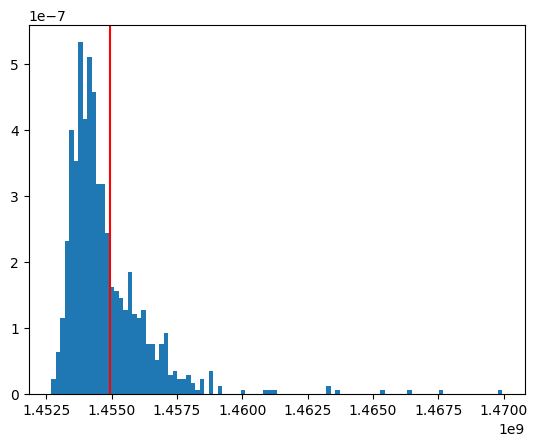

Application_123754331 [2.63411618e-07]


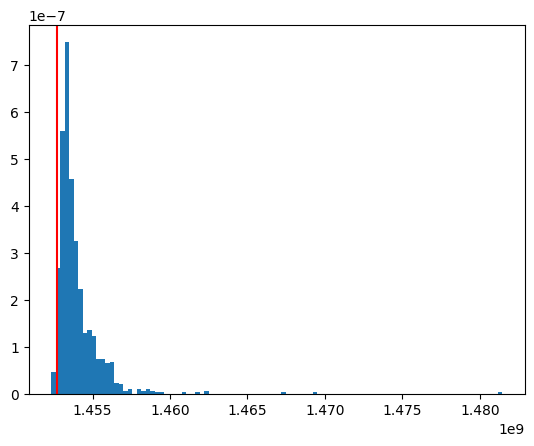

Application_1368129455 [4.91271243e-08]


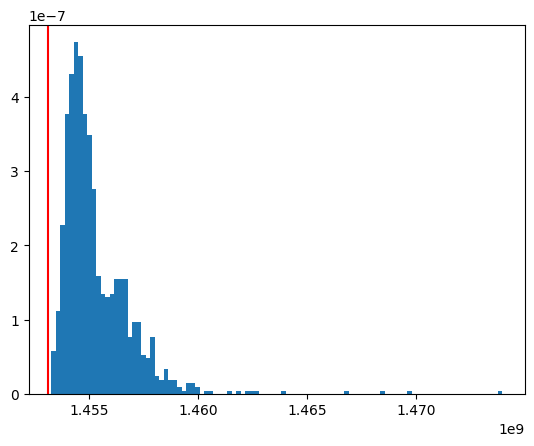

Application_2063334713 [9.61796218e-09]


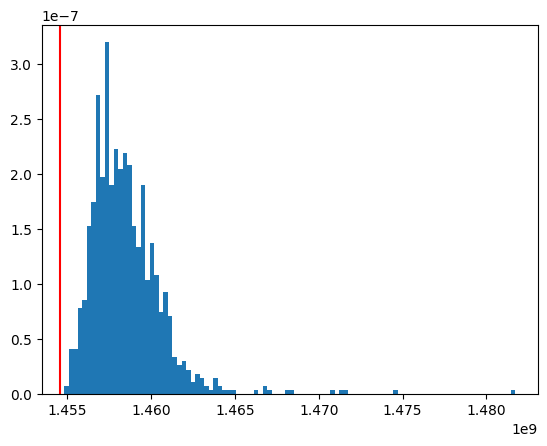

Application_402170266 [8.33668968e-08]


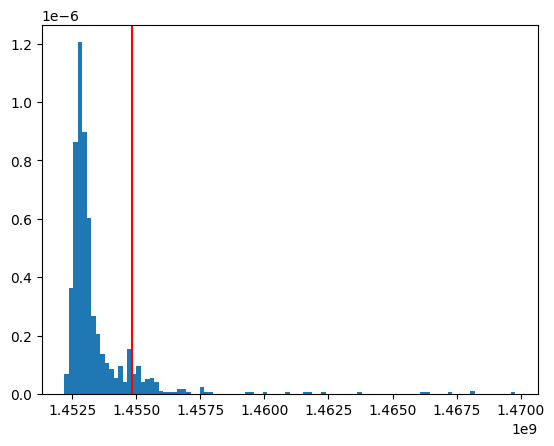

Application_339079436 [4.24830056e-07]


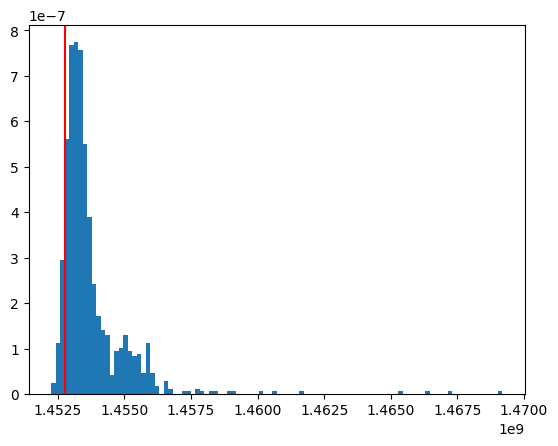

KeyboardInterrupt: 

In [65]:
from scipy.stats import gaussian_kde

kde_likelihood = lambda samples, ground_truth : gaussian_kde(samples)(ground_truth)


n = 1000
for case_name in event_log['case:concept:name'].unique():
    case_samples = [sample_end_time(case_name)[1] for i in range(n)]
    real_end_time = get_real_end_time(case_name)
    likelihood = kde_likelihood(case_samples, real_end_time)
    print(case_name, likelihood)

    plt.figure()
    plt.hist(case_samples, bins=100, density=True)
    plt.axvline(x=real_end_time, color='red')
    plt.show()